<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [40]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Data dictionary
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [41]:
# Load the data
house1 = pd.read_csv('./housing.csv')
house2 = pd.read_csv('./housing.csv')

### Keep only residential areas in MSZoning

In [42]:
print house1.shape
search_for = ['FV', 'RH', 'RL', 'RP', 'RM']
mask = house1['MSZoning'].isin(search_for)
house1 = house1.loc[mask, :]
house1.shape


(1460, 81)


(1450, 81)

### Identify outliers in SalePrice

outer range
[[-1.81625312]
 [-1.798565  ]
 [-1.6381085 ]
 [-1.63179132]
 [-1.60020539]
 [-1.60020539]
 [-1.5559851 ]
 [-1.53703354]
 [-1.53703354]
 [-1.53703354]]
high range
[[ 3.83257369]
 [ 4.04529857]
 [ 4.50219529]
 [ 4.71697958]
 [ 4.73695452]
 [ 5.06989544]
 [ 5.43280508]
 [ 5.60138548]
 [ 7.11750987]
 [ 7.24385357]]


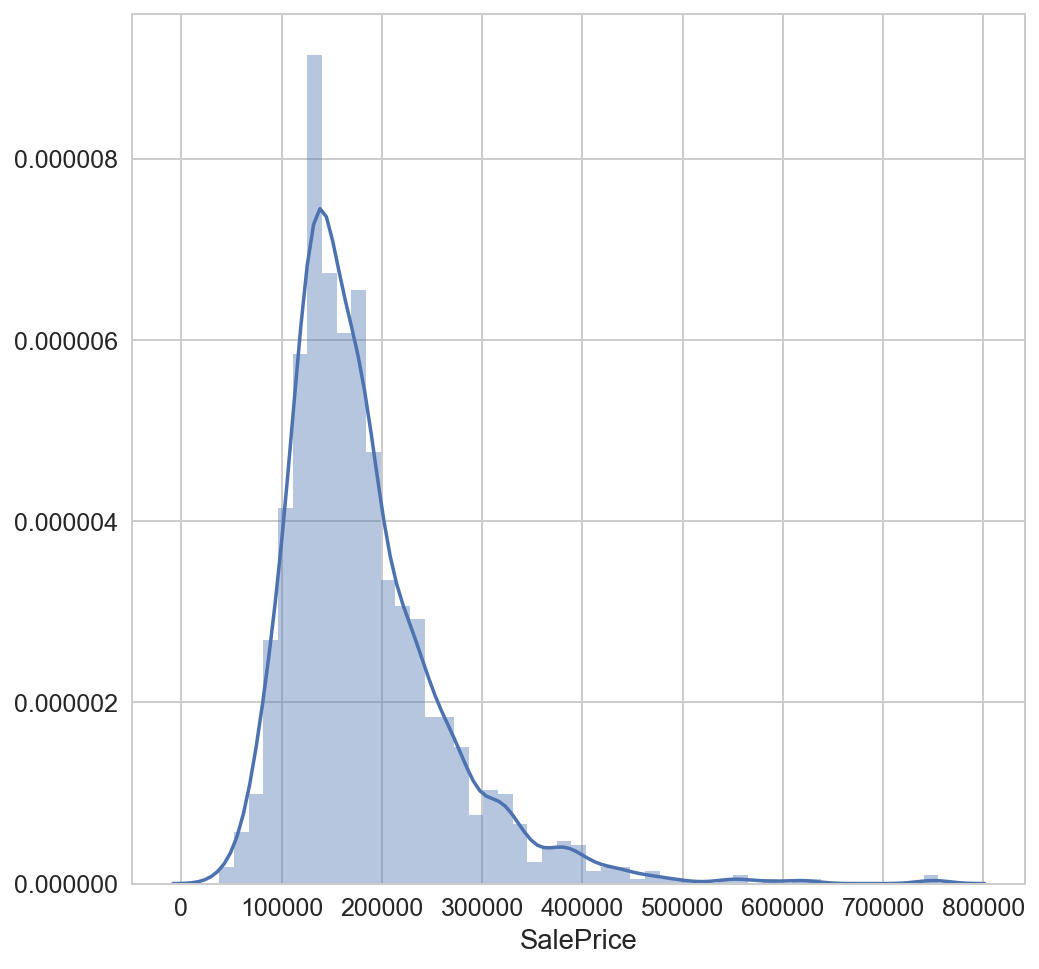

In [43]:
plt.figure(figsize=(8,8))
sns.distplot(house1['SalePrice'])

target_scaled = StandardScaler().fit_transform(house1['SalePrice'][:,np.newaxis])
low_range = target_scaled[target_scaled[:,0].argsort()][:10]
high_range = target_scaled[target_scaled[:,0].argsort()][-10:]
print 'outer range'
print low_range
print 'high range'
print high_range

# Some pretty crazy outliers in the 5+, 7+ range. 

house1.nlargest(5, 'SalePrice').index

house1.drop(house1.nlargest(5, 'SalePrice').index, inplace=True)

### Removing outliers in our data

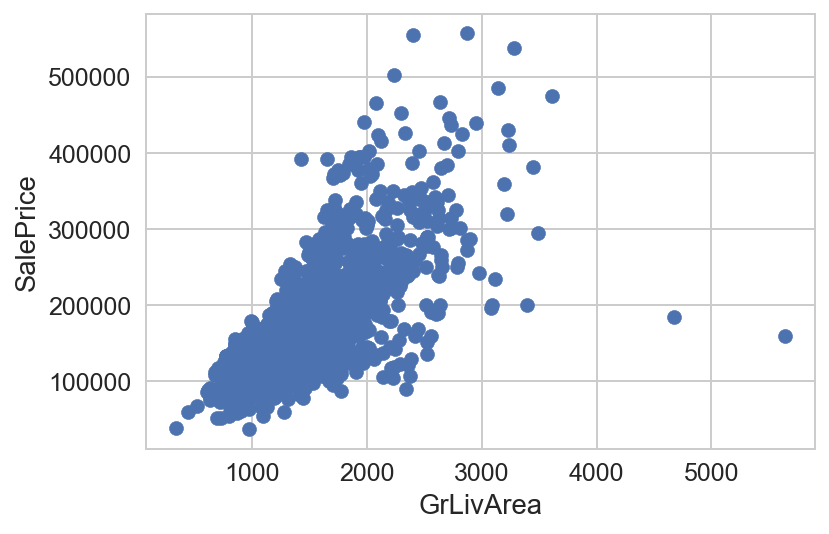

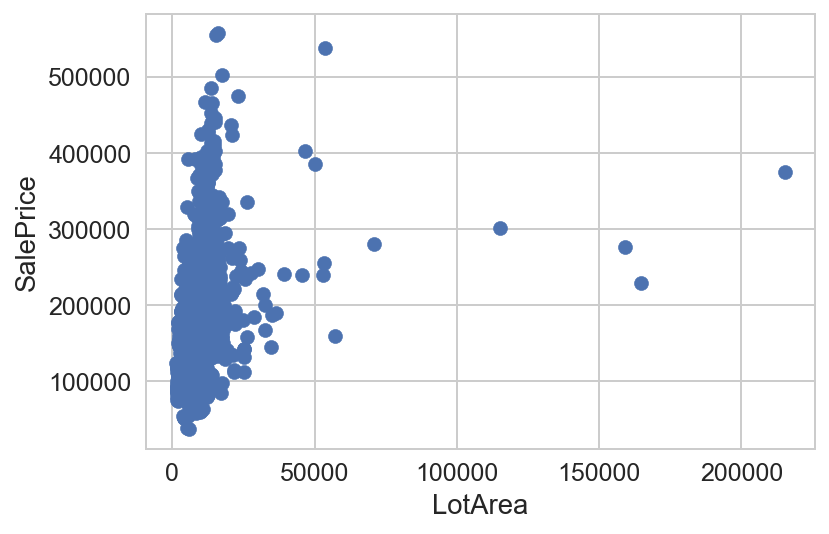

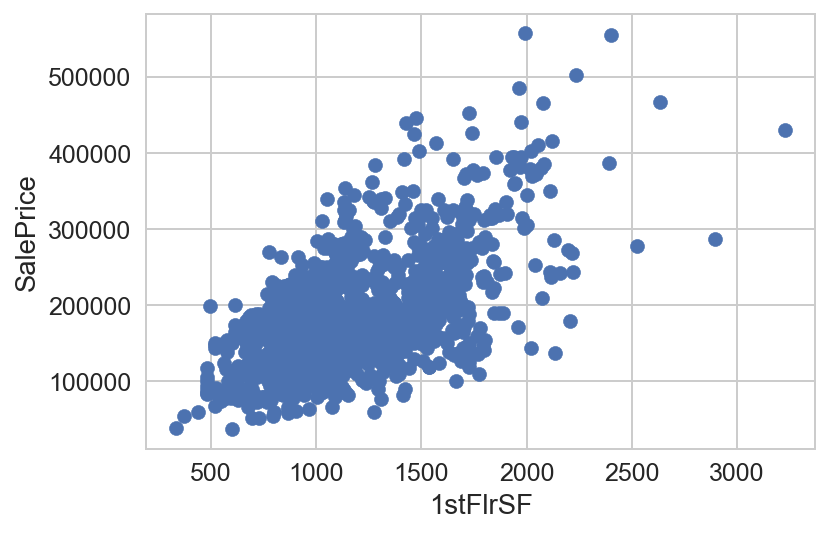

(162, 81)
(162, 81)


In [44]:
#plt.subplot(121)
plt.scatter(house1.GrLivArea, house1.SalePrice)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

house1 = house1[house1['GrLivArea'] < 4000]
#GrLivArea outliers handled.

plt.scatter(house1.LotArea, house1.SalePrice)
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

house1 = house1[house1['LotArea'] < 20000] 
#LotArea outliers handled. 

plt.scatter(house1['1stFlrSF'], house1.SalePrice)
plt.xlabel('1stFlrSF')
plt.ylabel('SalePrice') 
#Get rid of the outliers.
plt.show()

to_drop = house1.loc[ house1['1stFlrSF']>2000,:].loc[house1['SalePrice'] <300000,:]
house1.drop(to_drop.index, axis=0, inplace=True)
plt.show()

house2 = house1.copy()
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house1['YrSold'] == 2010].shape


(162, 81)
(162, 81)


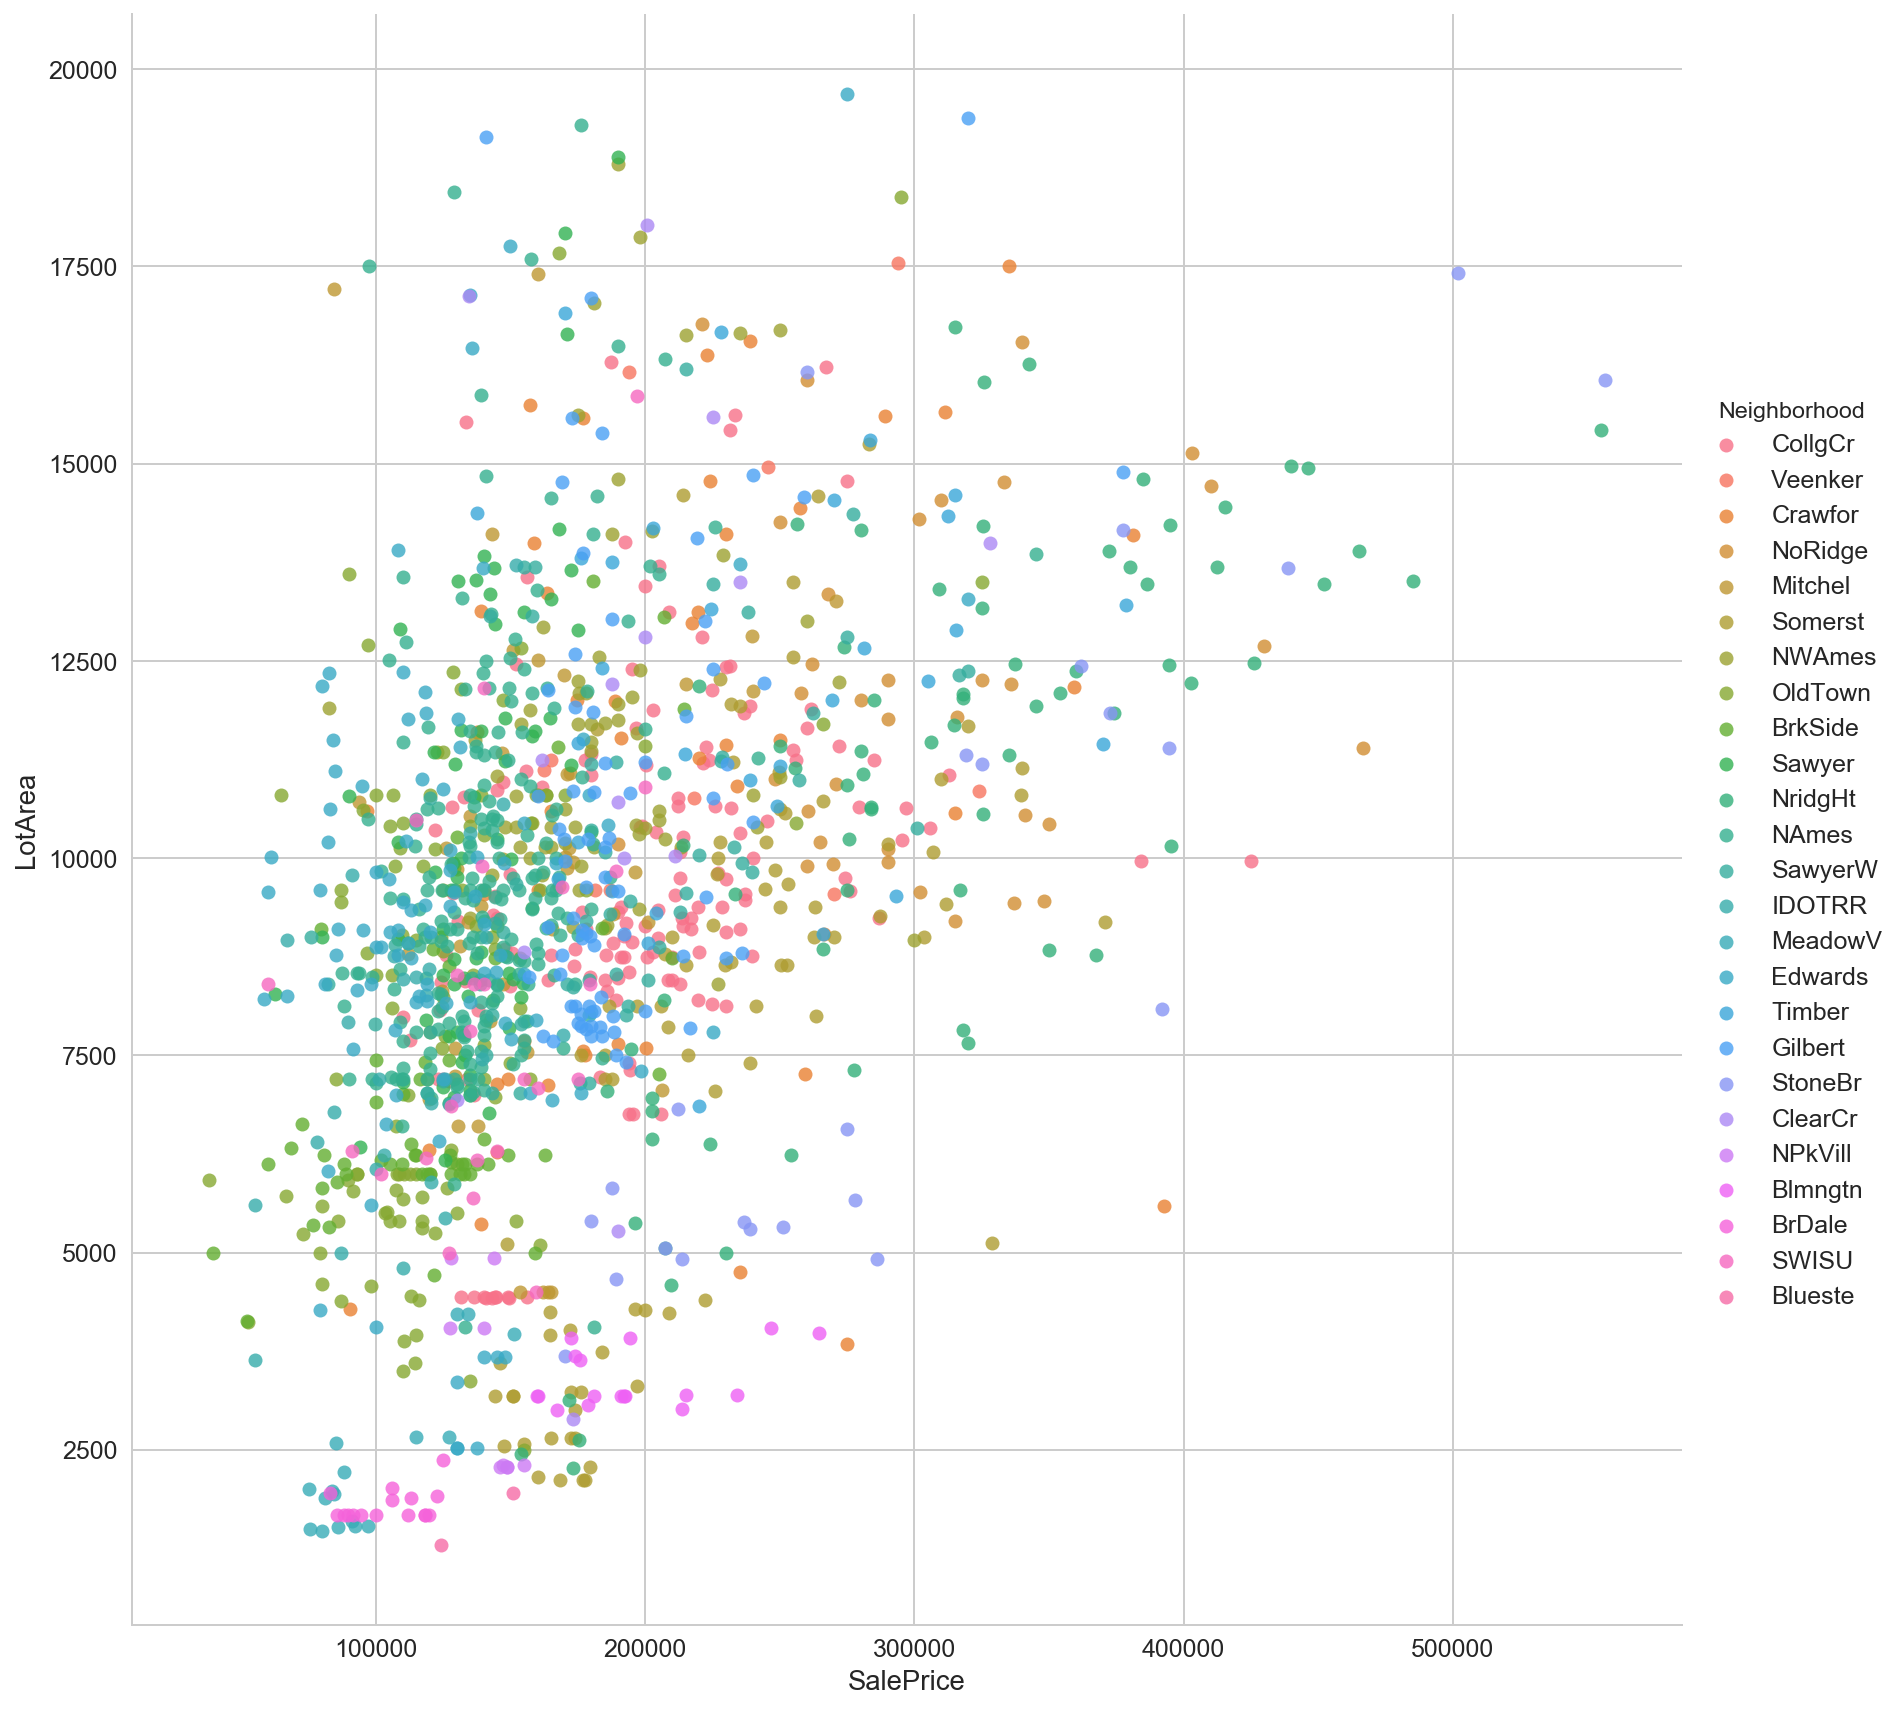

In [45]:
sns.lmplot(x="SalePrice", y = "LotArea", hue="Neighborhood", data=house1, fit_reg=False, size=12)
#A lot of outliers in LotArea and SalePrice. I want to Remove LotArea > 50,000 and SalePrice > 500,000 
#house1 = house1[house1['SalePrice'] < 500000]
#house1 = house1[house1['LotArea'] < 50000]
#sns.lmplot(x="SalePrice", y = "LotArea", hue="Neighborhood", data=house1, fit_reg=False, size=12)

#neigh = house1[house1['LotArea'] < 20000]
#neigh2 = neigh[neigh['SalePrice'] < 400000]
#sns.lmplot(x="SalePrice", y = "LotArea", hue="Neighborhood", data=neigh2, fit_reg=False, size = 10)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape



### 1. Identify fixed and un-fixed features (we only want fixed features)


In [46]:
#All columns that have 'Qual' or 'Cond' are unfixed features. so, remove. 
unfixed_features = []
unfixed_features.append(house1.loc[:,house1.columns.str.contains('Qual')].columns)
unfixed_features.append(house1.loc[:,house1.columns.str.contains('Cond')].columns)


house1.drop(house1.loc[:,house1.columns.str.contains('Qual')].columns, axis=1, inplace=True)
house1.drop(house1.loc[:,house1.columns.str.contains('Cond')].columns, axis=1, inplace=True)
print house1.shape

unfixed = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'BsmtFinSF1', 'BsmtFinType2',
        'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Functional', 'Fireplaces',
        'FireplaceQu','GarageType', 'GarageYrBlt', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence'
          ,'HouseStyle', 'YearRemodAdd', 'BsmtExposure', 'BsmtFinType1', 'GarageCars', 'MiscFeature']

unfixed_features.append(unfixed)

house1.drop(unfixed, axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(1380, 68)
(162, 38)
(162, 81)


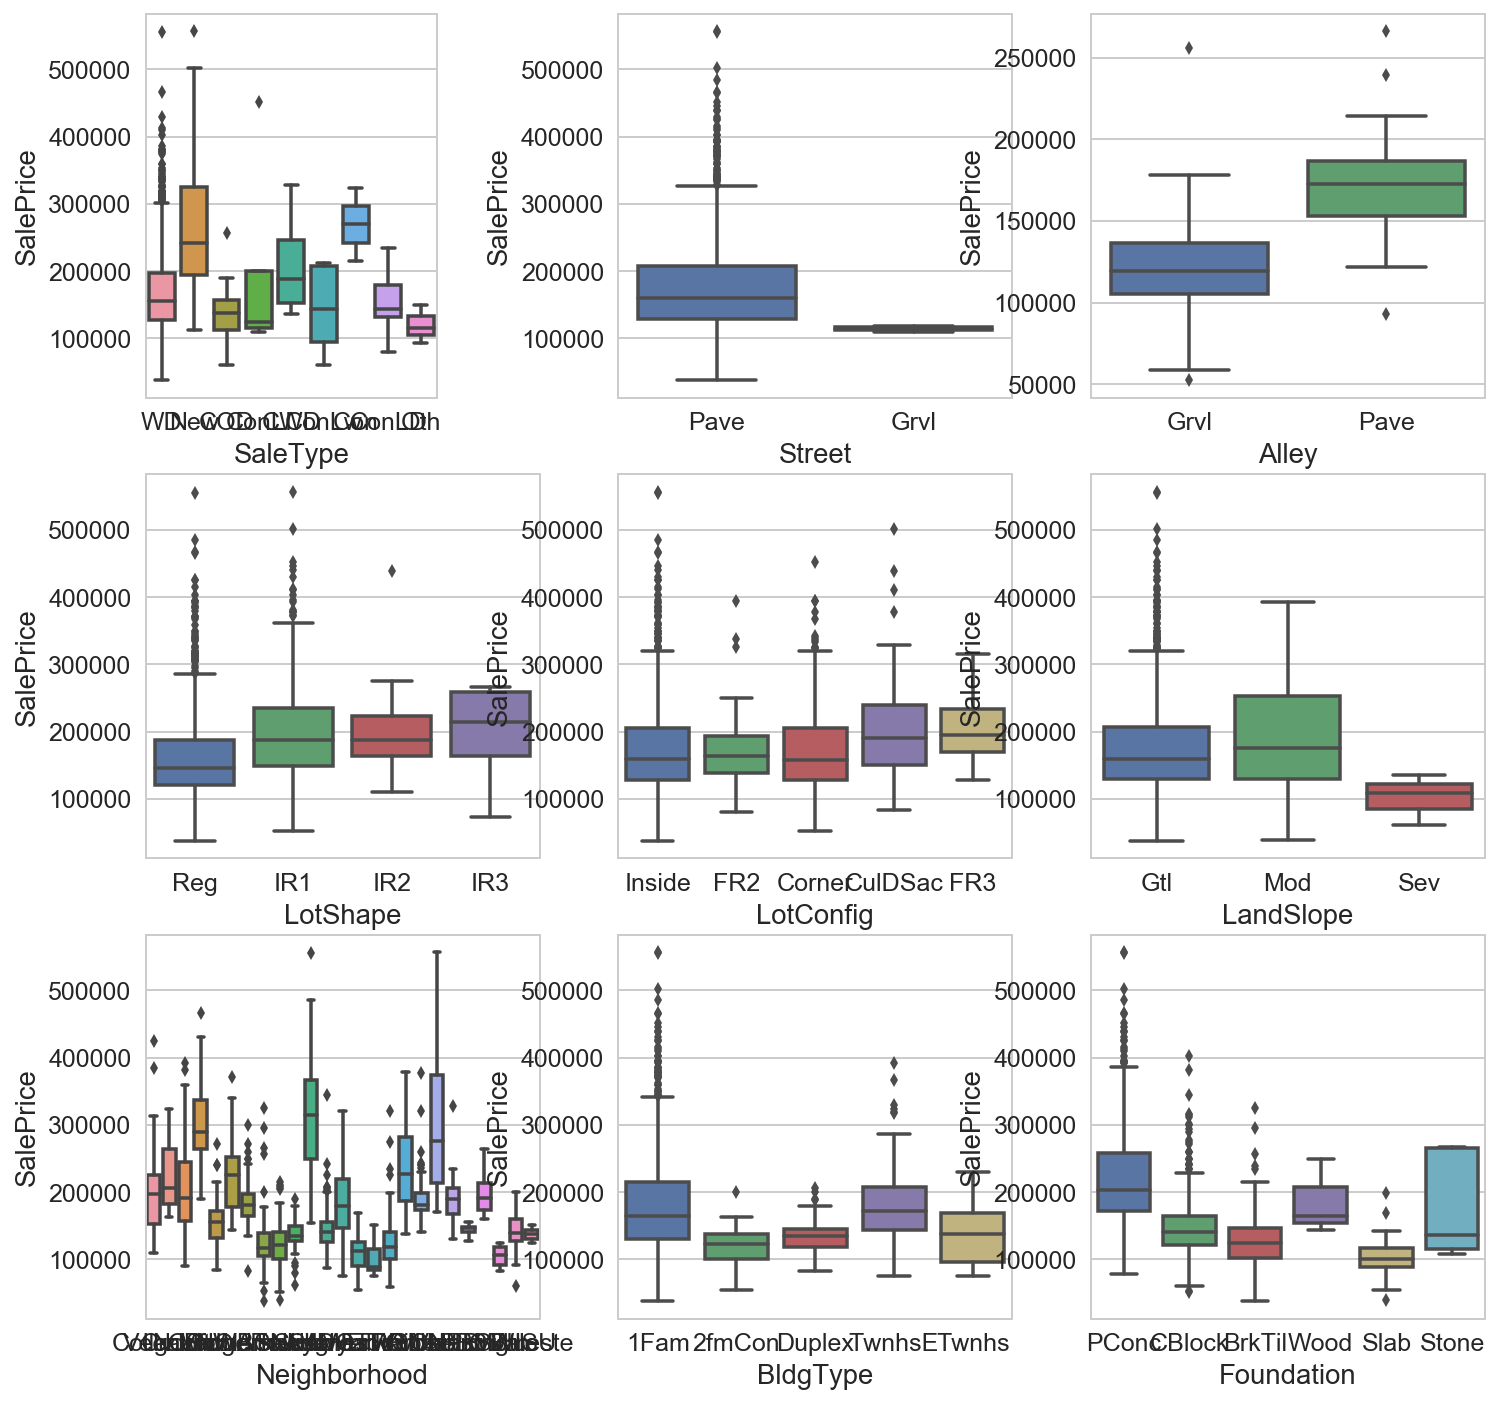

In [47]:
house1.columns
plt.figure(figsize =[12,12])
plt.subplot(331)
sns.boxplot('MSZoning', 'SalePrice', data =house1)
plt.subplot(332)
sns.boxplot('Street', 'SalePrice', data=house1)
plt.subplot(333)
sns.boxplot('Alley', 'SalePrice', data=house1)
plt.subplot(334)
sns.boxplot('LotShape', 'SalePrice', data=house1)
plt.subplot(335)
sns.boxplot('LotConfig','SalePrice', data=house1)
plt.subplot(336)
sns.boxplot('LandSlope', 'SalePrice', data=house1)
plt.subplot(337)
sns.boxplot('Neighborhood', 'SalePrice', data=house1)
plt.subplot(338)
sns.boxplot('BldgType', 'SalePrice', data=house1)
plt.subplot(339)
sns.boxplot('Foundation', 'SalePrice', data=house1)
plt.subplot(341)
sns.boxplot('SaleType', 'SalePrice', data=house1)

### Handling 'Neighborhood'

In [48]:
haha = house1.groupby("Neighborhood")['SalePrice'].mean()
house1['Neighborhood'] = house1['Neighborhood'].map(haha)

#Instead of using neighborhood names, use the average sale price of house in the neighborhood

###  Remove Street, Alley, LotShape, LotConfig, LandSlope due to low variance in data

In [49]:
to_drop = ['Street','Alley','LotShape','LotConfig','LandSlope']
house1.drop(house1[to_drop], axis=1, inplace=True)

#Drop multiple columns at once by df.drop(df[cols_to_drop]). Interesting!

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape



(162, 33)
(162, 81)


### For remaining categorical features, remove those with very one sided date. (i.e all the data is in one category)

In [50]:
newlist = house1.select_dtypes(exclude=['int64', 'float64']).head().columns
newlist = list(newlist)
for i in newlist:
    print house1[i].value_counts()
    


RL    1083
RM     217
FV      65
RH      15
Name: MSZoning, dtype: int64
Lvl    1263
Bnk      56
HLS      42
Low      19
Name: LandContour, dtype: int64
1Fam      1146
TwnhsE     114
Duplex      50
Twnhs       43
2fmCon      27
Name: BldgType, dtype: int64
PConc     620
CBlock    591
BrkTil    139
Slab       22
Stone       5
Wood        3
Name: Foundation, dtype: int64
WD       1202
New       114
COD        38
ConLD       7
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


In [51]:
house1.MSZoning.value_counts()

#Srop BldgType and SaleType, LandContour, and MSZoning because data too imbalanced. 
house1.drop(house1[['BldgType','SaleType', 'LandContour', 'MSZoning']], axis=1, inplace=True)

#Foundation: Take only 2 category PConoc and CBlock. Remaining category merge into PConc. 
house1.Foundation = house1.Foundation.map(lambda x: 'CBlock' if x == 'CBlock' else 'PConc')

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 29)
(162, 81)


### GrLivArea is the sum of 1stFlrSF and 2ndFlrSF.

In [52]:
house1.drop('1stFlrSF', axis=1, inplace=True)
house1.drop('2ndFlrSF', axis=1, inplace=True)

SalePrice = house1['SalePrice']
house1.drop('SalePrice', axis=1, inplace=True)
house1.shape
house1['SalePrice'] = SalePrice

In [53]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 27)
(162, 81)


In [54]:
#Drop due to missing data.
#house1.drop('LotFrontage', axis=1, inplace=True)
house1.drop('3SsnPorch', axis=1, inplace=True)
house1.drop('ScreenPorch', axis=1, inplace=True)
house1.drop('PoolArea', axis=1, inplace=True)
house1.drop('MiscVal', axis=1, inplace=True)

#OpenPorchSF and WoodDeckSF a bit too many missing values. Got to get rid of them as well.
house1.drop('OpenPorchSF', axis=1, inplace=True)
house1.drop('WoodDeckSF', axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape




(162, 21)
(162, 81)


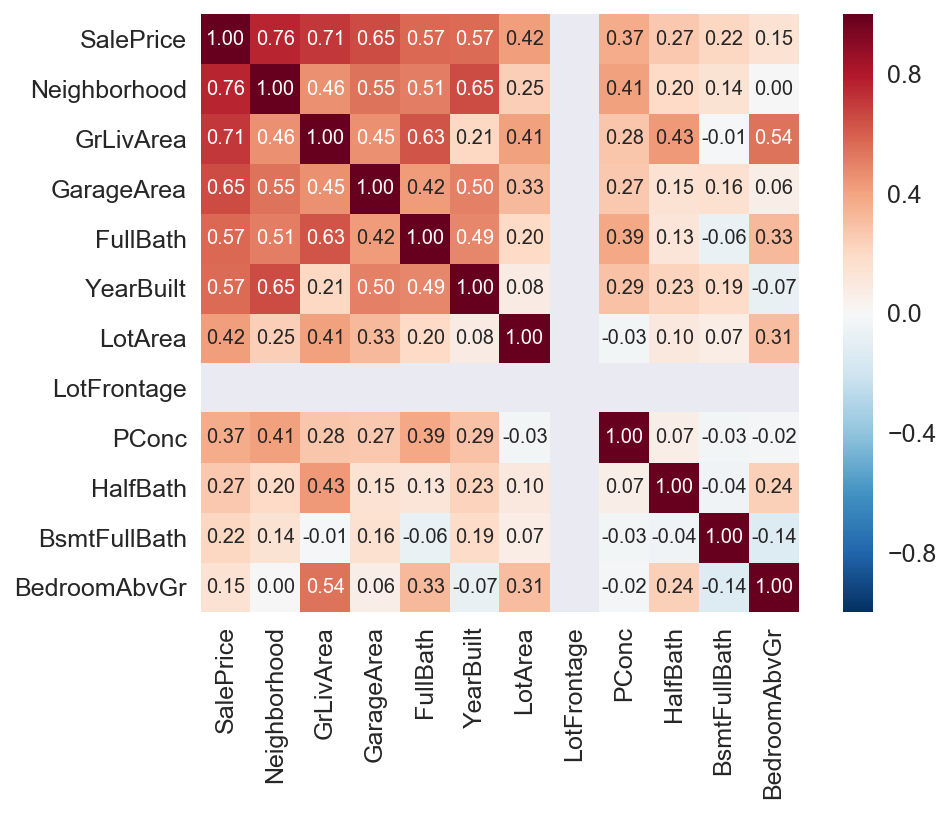

(162, 17)
(162, 81)


In [55]:
#TotalRmsAbvGrd and GrLivArea very correlated. Drop TotalRmsAbvGrd.

#1stFlrSF and TotalBsmtSF very correlated. Drop TotalBsmtSF as it has some missing values.

house1.drop('TotRmsAbvGrd', axis=1, inplace=True)
house1.drop('TotalBsmtSF', axis=1,inplace=True)

#get_dummies for foundation
found = pd.get_dummies(house1.Foundation)
house1 = pd.concat([house1, found], axis=1)

house1.drop('Foundation', axis=1, inplace=True)
house1.drop('CBlock', axis=1, inplace=True)

#Heatmap with highest k correlated features with SalePrice

k = 12 #number of variables for heatmap
corrmat = house1.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house1[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

house1.drop('Id', axis=1, inplace=True)
house1.drop('LotFrontage', axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


# Running the regressors. Findings:
###  Linear regression:  0.853668769093

### Elastic Net(alpha 0.5, l1 = 0.001):  0.840873643935

### XGBoost(learning_rate=0.292929292929) :  0.898104

thank you mr tianqi chen

In [56]:
test = house1[house1['YrSold'] == 2010]
train = house1[house1['YrSold'] != 2010]

X_train = train.loc[:,train.columns != 'SalePrice'] #all cols except SalesPrice
 
y_train = train['SalePrice']

X_test = test.loc[:,test.columns != 'SalePrice']

y_test = test['SalePrice']

#StandardScalar on  x_train, x_test
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [57]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 81)


In [58]:
#Trying with Linear Regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(Xs_train, y_train)
print linreg.coef_
y_pred = linreg.predict(Xs_test)
np.sqrt(mean_squared_error(y_test, y_pred))
print linreg.score(Xs_test, y_test)

[ -4.80818012e+03   4.99811867e+03   2.08615829e+04   1.19856220e+04
   4.19961794e+04   8.02824962e+03   2.67931286e+03  -1.27785291e+03
  -3.95515707e+03  -9.49789595e+03  -5.79075559e+03   8.25897105e+03
   4.96936291e+02   1.35656742e+03  -2.79068241e+01   2.51429294e+03]
0.846441384237


In [59]:
#Trying with linreg, without scaling

linreg.fit(X_train, y_train)
print linreg.coef_
y_pred = linreg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))
print linreg.score(X_test, y_test) #Score improved a lot.

[ -1.14640171e+02   1.50028144e+00   3.83058012e-01   3.94092433e+02
   8.76847150e+01   1.58352554e+04   1.09066475e+04  -2.35544982e+03
  -7.84348487e+03  -1.17925927e+04  -2.66271910e+04   3.91585104e+01
   8.33007726e+00   5.04636360e+02  -2.47877553e+01   5.09361169e+03]
0.853668769093


In [60]:
#Trying with ElasticNet

enet = ElasticNet(alpha=0.5, l1_ratio=0.001)

enet.fit(X_train, y_train)

print enet.coef_
y_pred = enet.predict(X_test)

from sklearn import metrics
print np.sqrt(mean_squared_error(y_test, y_pred))
print enet.score(X_test, y_test)

[ -1.43655867e+02   1.29186907e+00   4.34830086e-01   4.21139919e+02
   7.50301338e+01   5.17910202e+03   8.05578861e+02  -1.20686988e+03
  -1.89325877e+03  -6.13965374e+03  -2.13892457e+03   4.63661455e+01
   1.74497044e+01   3.98629473e+02   1.43094013e+02   1.22253987e+03]
27197.7586199
0.840873643935


In [61]:
#Trying with xgboost
from xgboost import XGBRegressor
model = XGBRegressor(seed=42, learning_rate=0.5)
model.fit(X_train, y_train)
model.score(X_test, y_test)
y_hat = model.predict(X_test) #this is the y_hat to use for question 2
residuals = y_hat - y_test
numbers = np.linspace(0, 1, 100)
tracker = {}
for i in numbers:
    model = model = XGBRegressor(seed=42, learning_rate=i)
    model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    #print 'learning rate of ' + str(i) + ' and our score is ' +  str(scores)
    tracker[i] = scores
print tracker


scores_xgboost = pd.DataFrame.from_dict(tracker, orient='index')
scores_xgboost.rename(index=str, columns={0:'XGboost score'}, inplace=True)
scores_xgboost.sort_values('XGboost score', ascending=False)



{0.0: -6.4243336199847416, 1.0: 0.79264102063719755, 0.29292929292929293: 0.89810412081096191, 0.6262626262626263: 0.84179752224389559, 0.23232323232323235: 0.88391405231181042, 0.58585858585858586: 0.86681075712510769, 0.80808080808080818: 0.8264955492944065, 0.17171717171717174: 0.87865027988981237, 0.8787878787878789: 0.81037765350905933, 0.27272727272727276: 0.88005382253383058, 0.96969696969696972: 0.78535646397366532, 0.85858585858585867: 0.80635158864797696, 0.28282828282828287: 0.87842005395978595, 0.50505050505050508: 0.861842416629226, 0.61616161616161624: 0.85471546443648672, 0.78787878787878796: 0.81763492772240309, 0.95959595959595967: 0.77962011122489683, 0.75757575757575768: 0.81810421633895958, 0.54545454545454553: 0.87352255607983498, 0.68686868686868696: 0.84811764523473521, 0.71717171717171724: 0.82766231379637289, 0.090909090909090912: 0.88122126399204825, 0.44444444444444448: 0.8865154945010133, 0.010101010101010102: -0.22657280132636107, 0.060606060606060608: 0.87

XGboost score
0.292929292929        0.898104
0.212121212121        0.890985
0.383838383838        0.889840
0.373737373737        0.888348
0.131313131313        0.888083
0.151515151515        0.887079
0.444444444444        0.886515
0.434343434343        0.886330
0.181818181818        0.885057
0.363636363636        0.884886
0.222222222222        0.884834
0.242424242424        0.884353
0.262626262626        0.884310
0.111111111111        0.883920
0.232323232323        0.883914
0.494949494949        0.883667
0.343434343434        0.881954
0.121212121212        0.881720
0.313131313131        0.881287
0.0909090909091       0.881221
0.272727272727        0.880054
0.161616161616        0.879996
0.191919191919        0.879087
0.171717171717        0.878650
0.282828282828        0.878420
0.252525252525        0.877575
0.464646464646        0.877041
0.0707070707071       0.877032
0.0808080808081       0.875566
0.323232323232        0.875558
...                        ...
0.777777777778        0.829472
0.030303030303        0.828490
0.717171717172        0.827662
0.808080808081        0.826496
0.909090909091        0.825971
0.767676767677        0.822117
0.929292929293        0.819937
0.757575757576        0.818104
0.787878787879        0.817635
0.737373737374        0.816611
0.838383838384        0.814030
0.878787878788        0.810378
0.949494949495        0.808888
0.79797979798         0.807352
0.727272727273        0.806903
0.858585858586        0.806352
0.919191919192        0.805158
0.89898989899         0.804897
0.868686868687        0.802354
0.989898989899        0.796421
1.0                   0.792641
0.939393939394        0.788350
0.969696969697        0.785356
0.888888888889        0.782496
0.959595959596        0.779620
0.979797979798        0.779583
0.828282828283        0.777310
0.020202020202        0.673753
0.010101010101       -0.226573
0.0                  -6.424334

[100 rows x 1 columns]

In [62]:
#Try gridsearch xgboost 

from sklearn.model_selection import GridSearchCV

xg_params = {'learning_rate': [0.1, 0.2, 0.3], 
            'max_depth' : [1, 2, 3, 4, 5, 6],
            'n_estimators': [100, 500]}
xg_gridsearch = GridSearchCV(XGBRegressor(), xg_params, cv=2, verbose=1)
xg_gridsearch.fit(X_train, y_train)
print 'gridsearching: best score'
print xg_gridsearch.best_score_
print 'gridsearch best params'
print xg_gridsearch.best_params_
best_xg = xg_gridsearch.best_estimator_
best_xg.score(X_test, y_test)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
gridsearching: best score
0.856337314359
gridsearch best params
{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 2}


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   11.8s finished


0.88693490542249309

In [63]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 81)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Grab renovatable features. Do some EDA. get_dummies on categorical 


In [64]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 81)


In [65]:
house2.columns

unfixed = [u'Utilities',u'Condition1',u'Condition2',u'HouseStyle',u'OverallQual',u'OverallCond',u'RoofStyle',u'RoofMatl'
          ,u'Exterior1st',u'Exterior2nd',u'ExterQual',u'ExterCond',u'BsmtQual',u'BsmtCond',u'BsmtExposure',u'BsmtFinType1',
          u'Heating',u'HeatingQC',u'CentralAir', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'YrSold'
          ]

house2 = house2[unfixed]
house2.columns
house2['SalePrice'] = house1['SalePrice']

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 26)


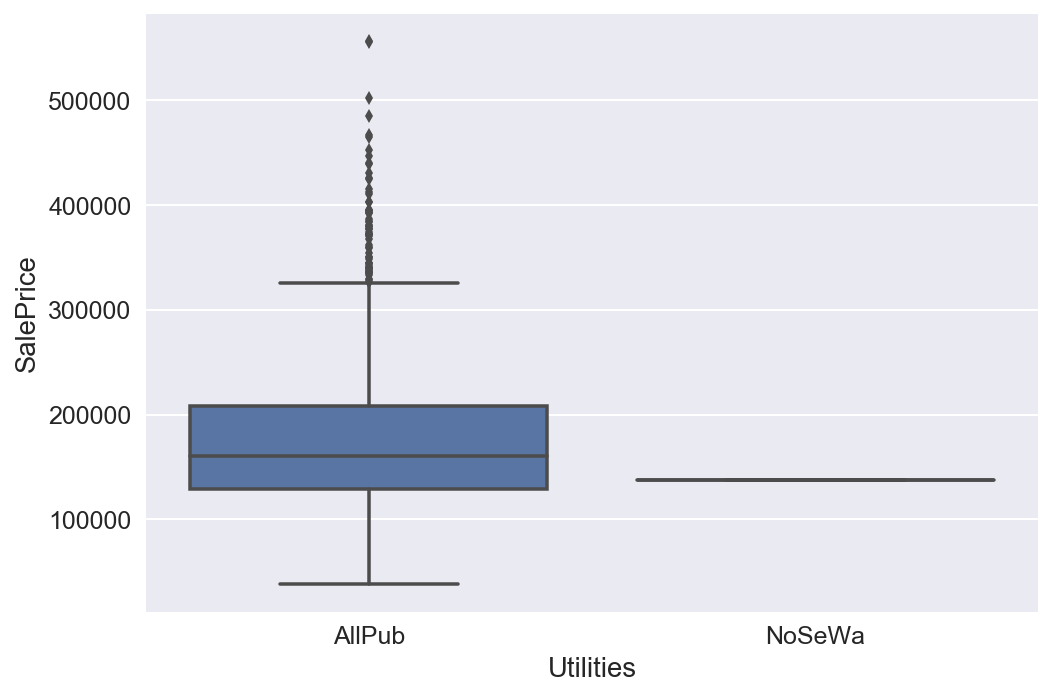

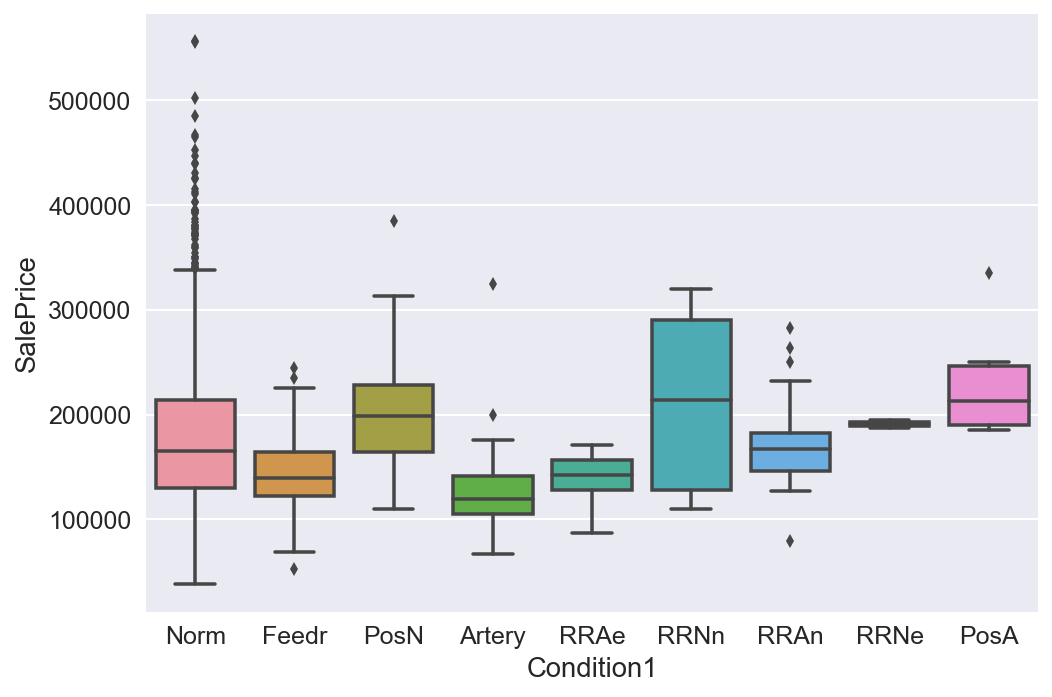

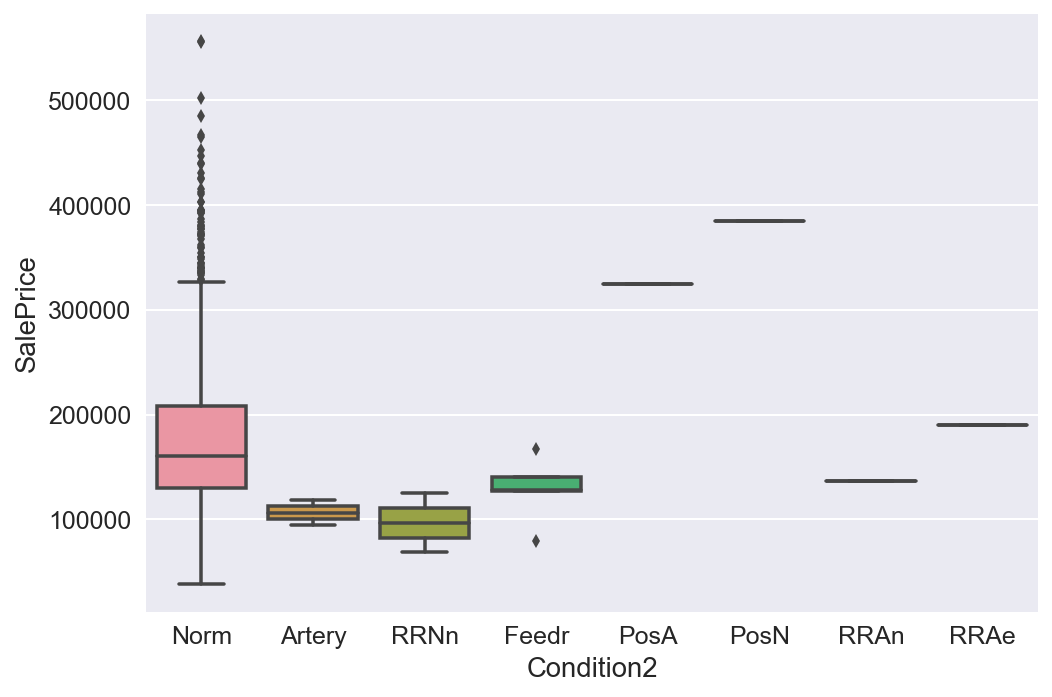

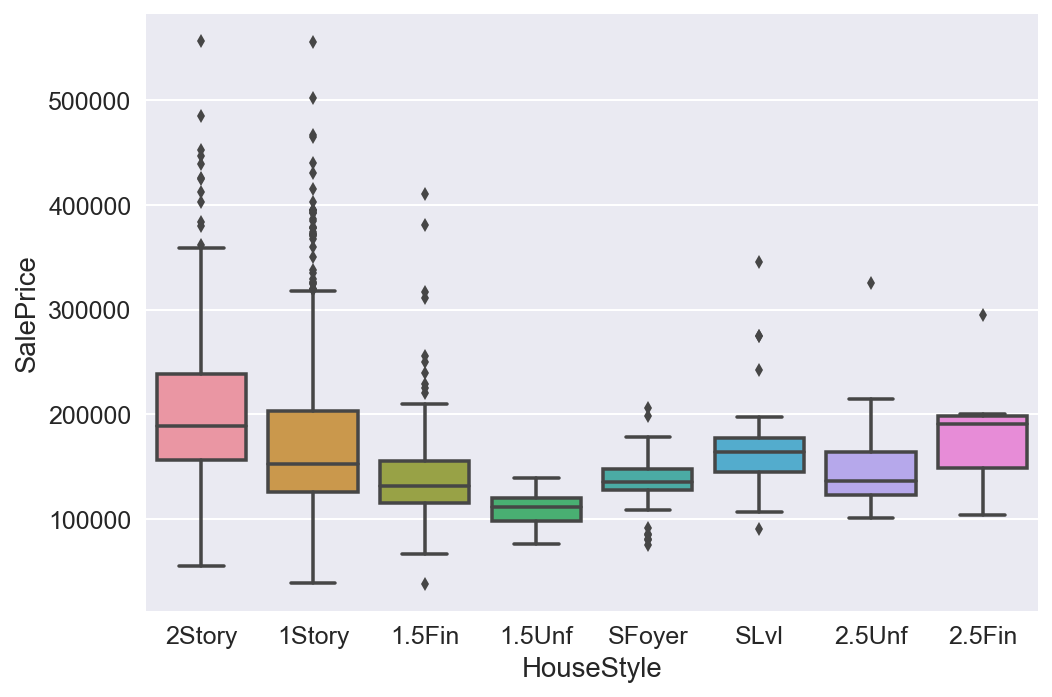

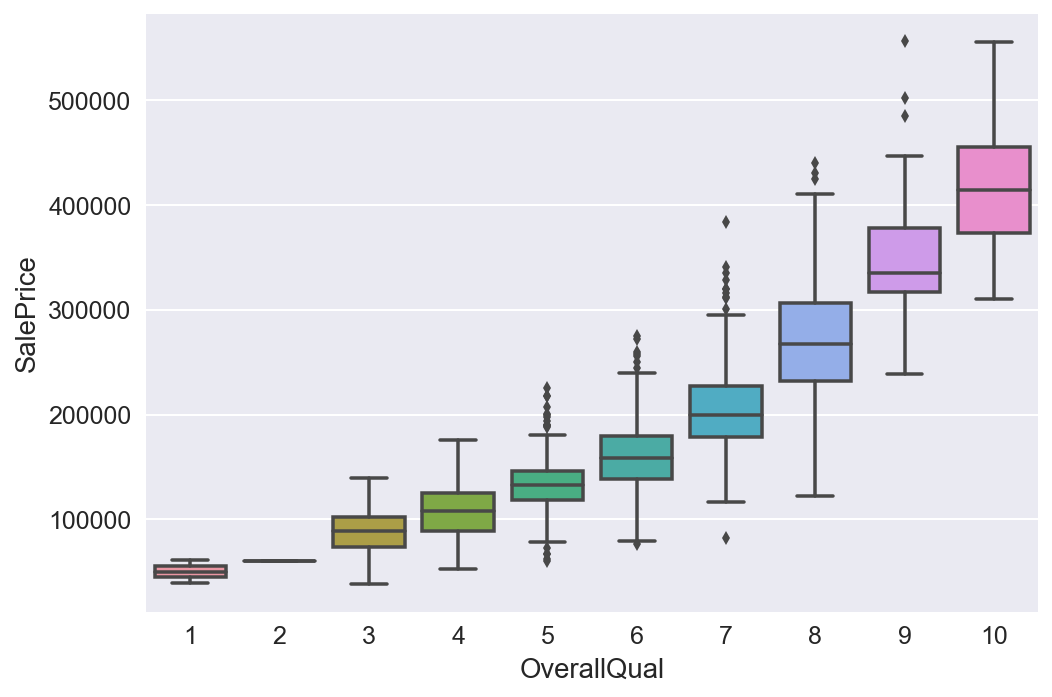

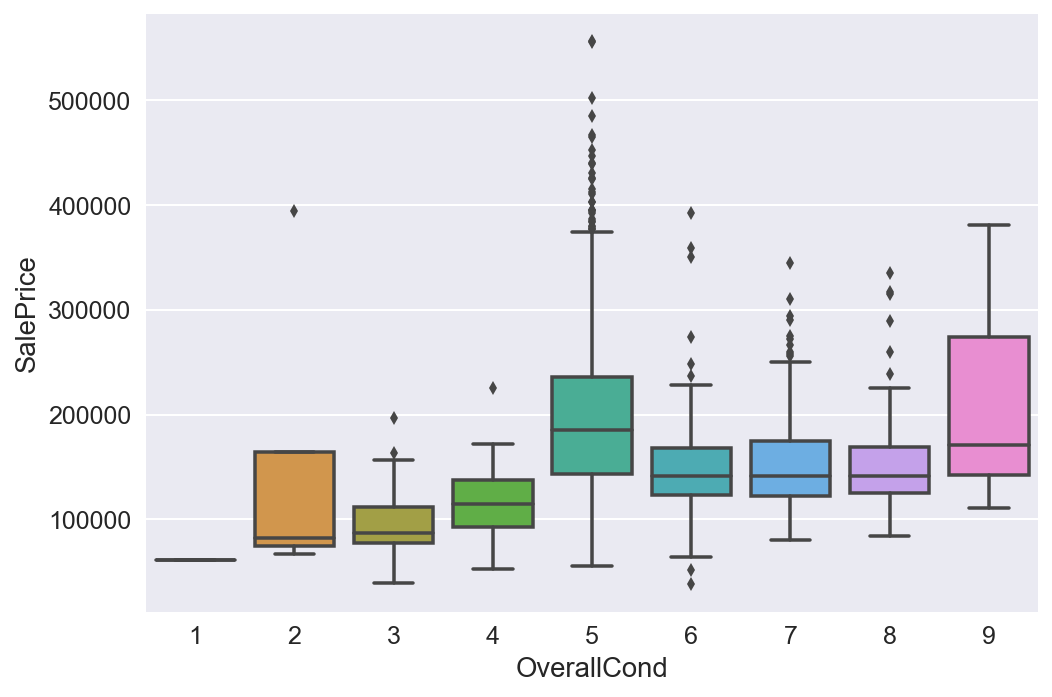

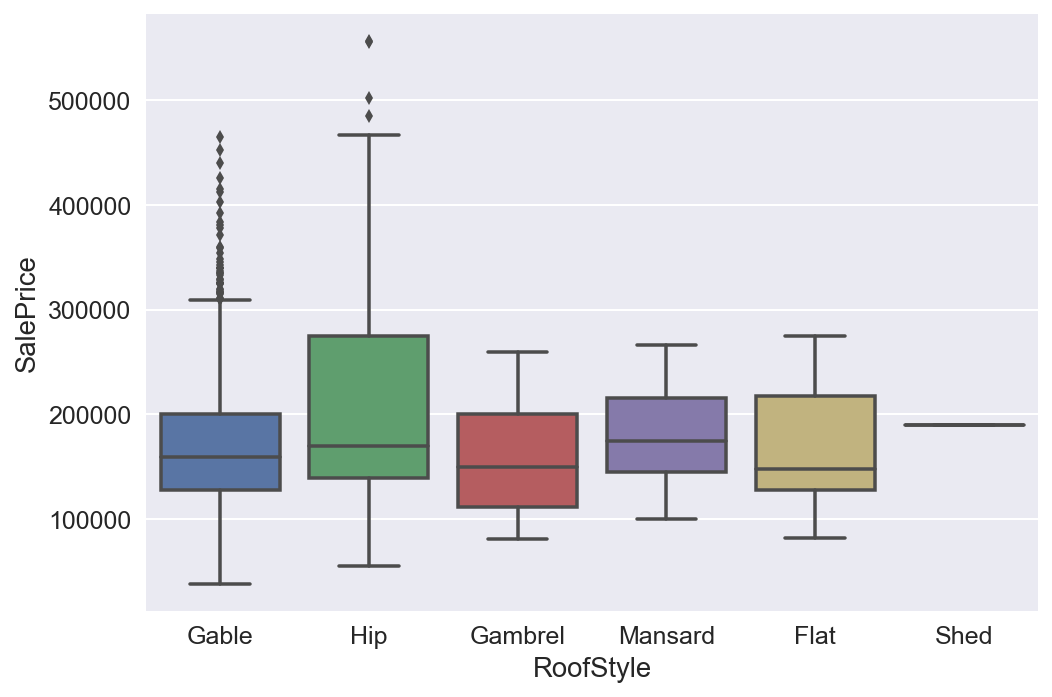

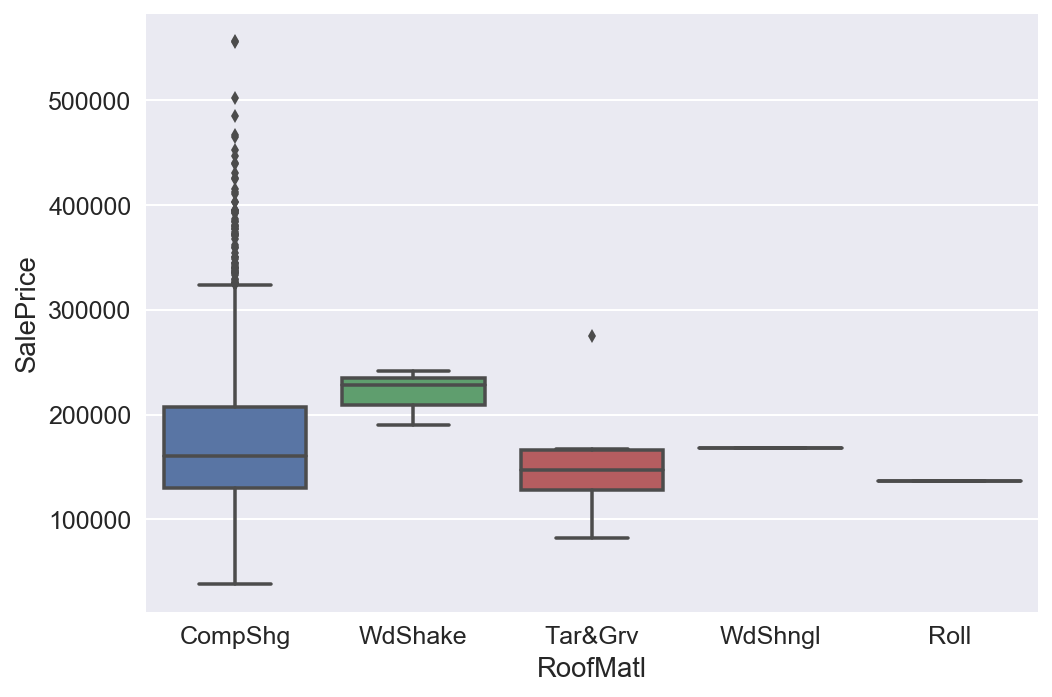

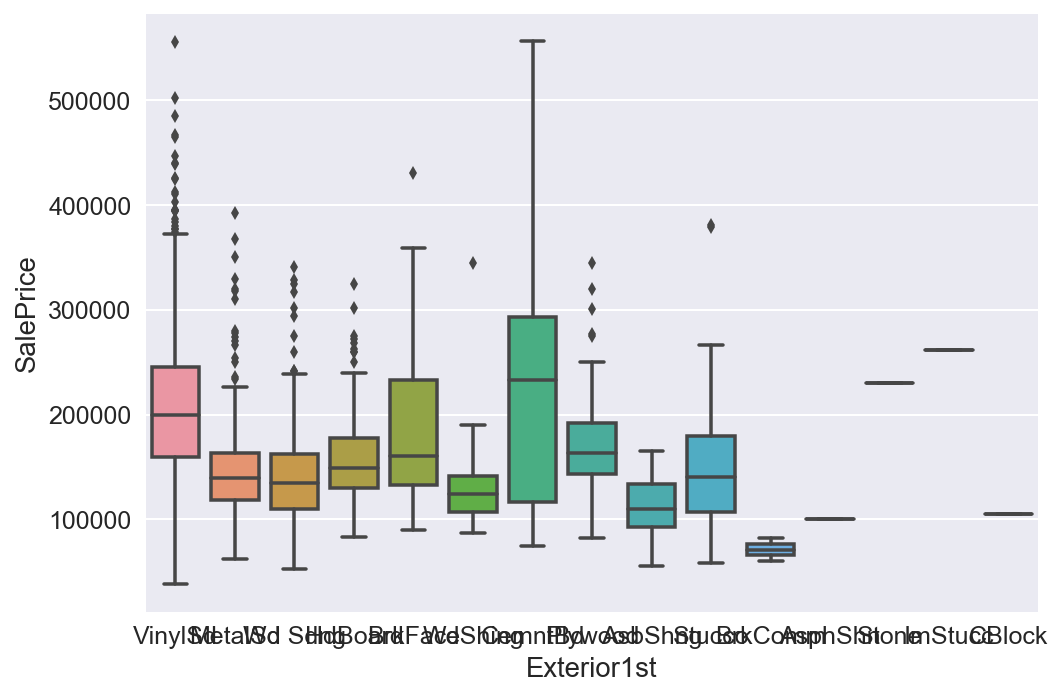

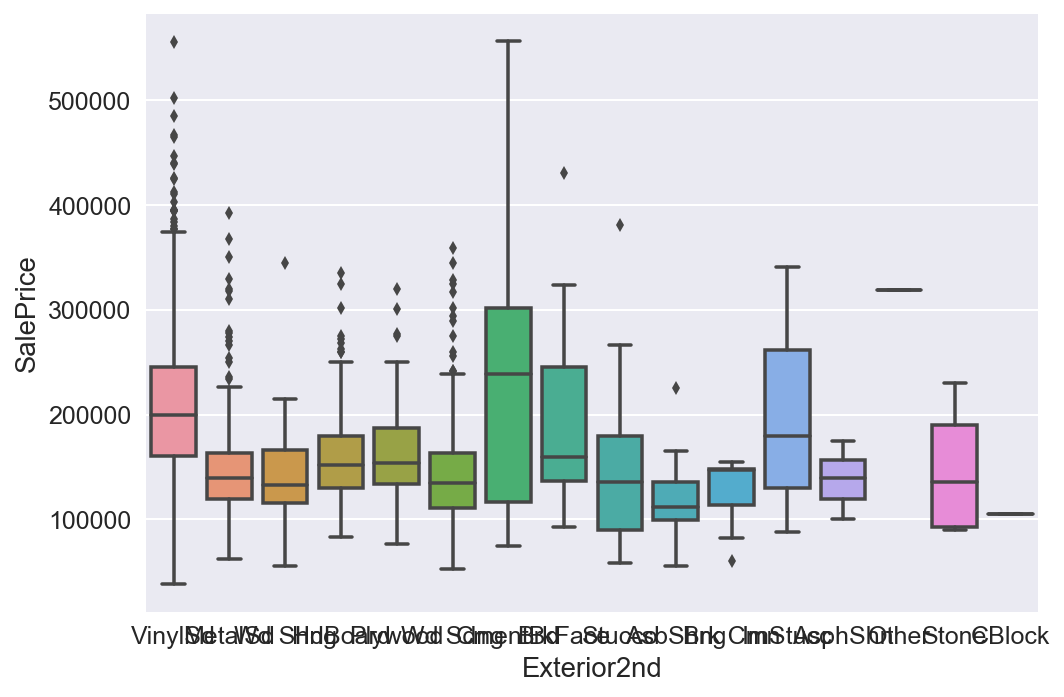

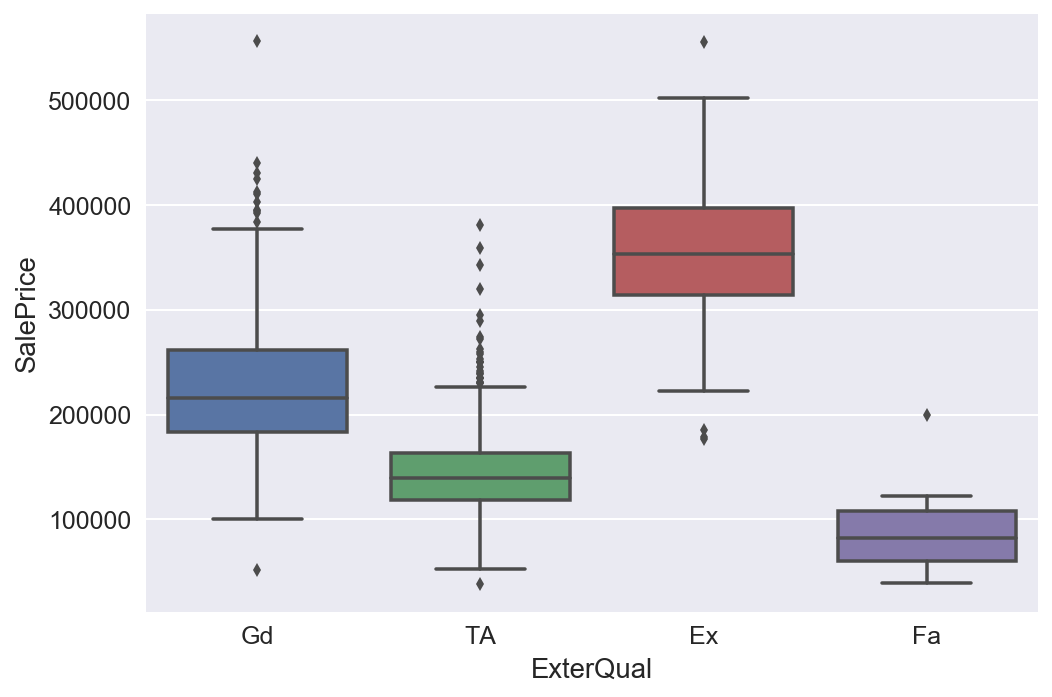

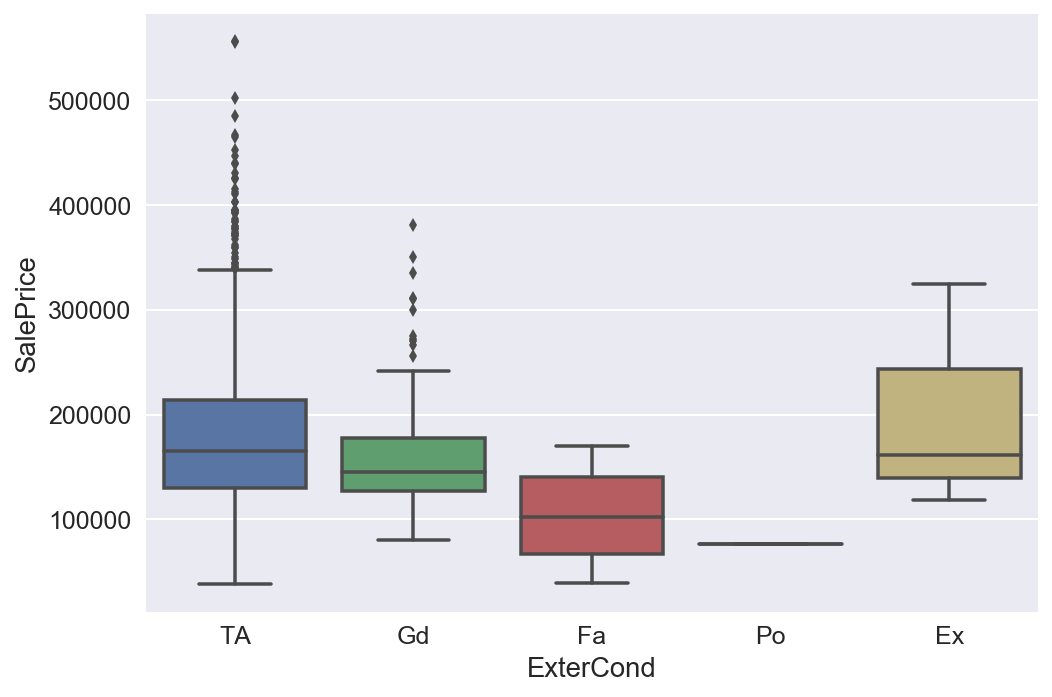

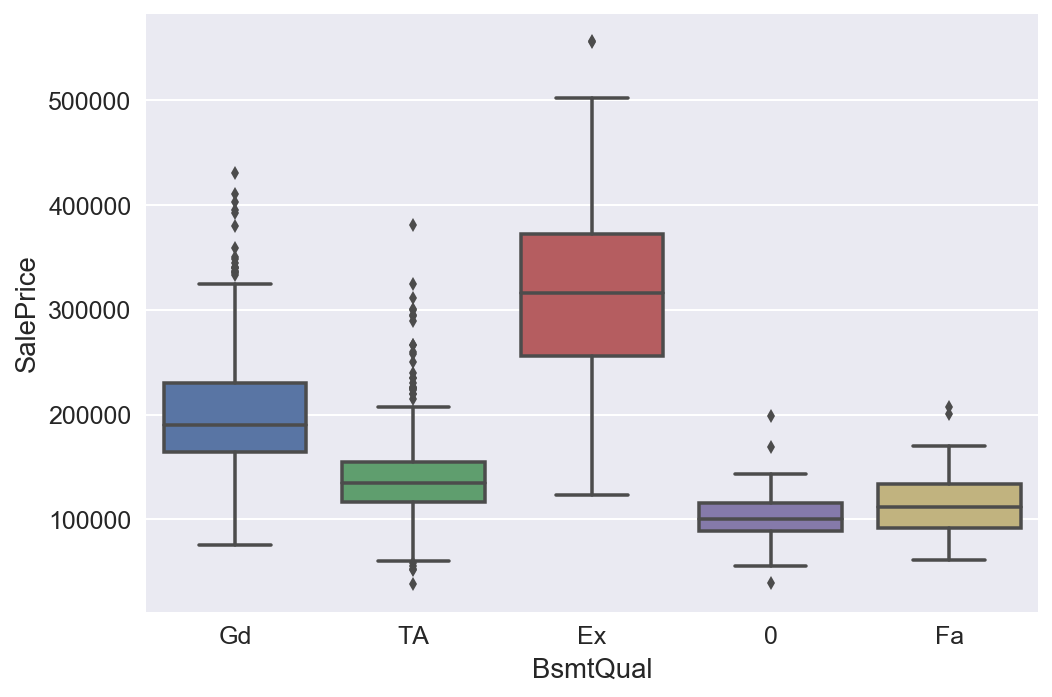

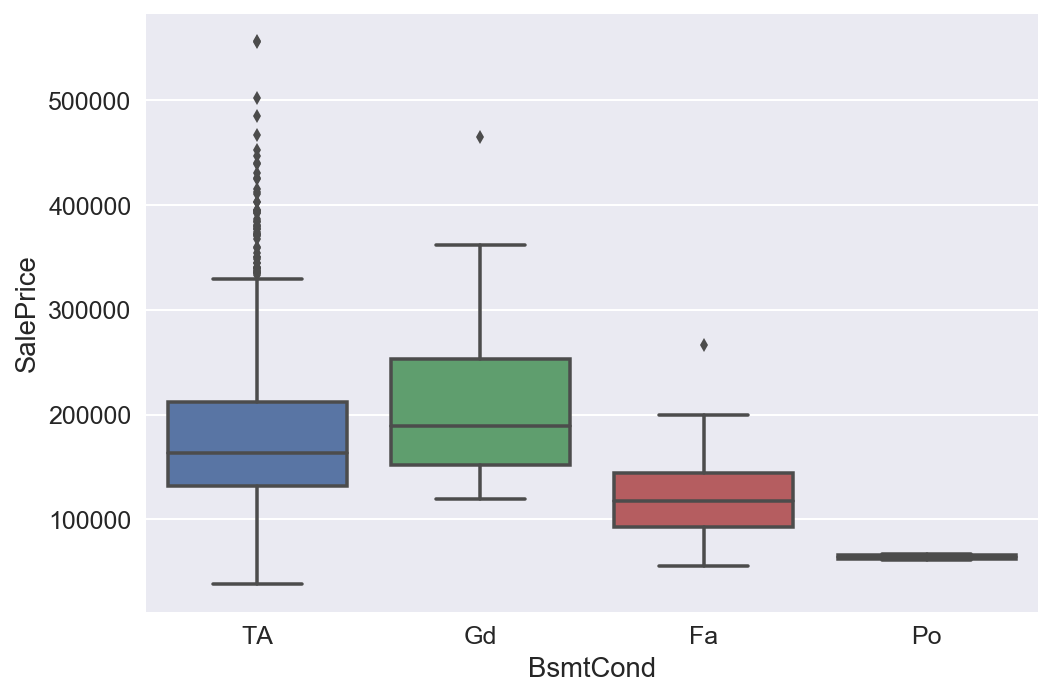

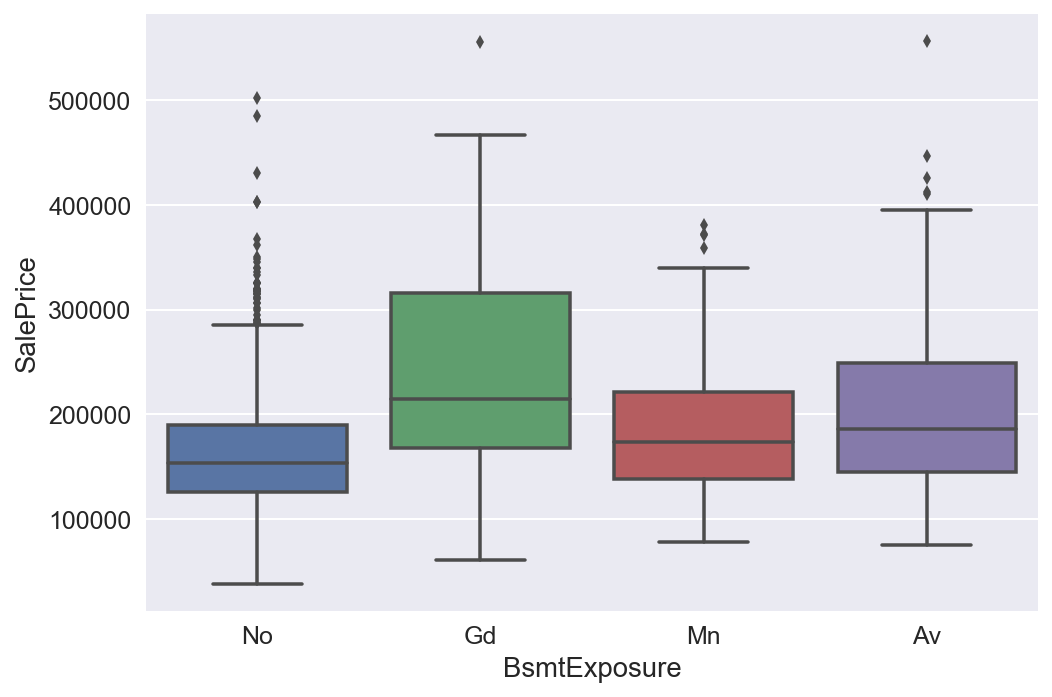

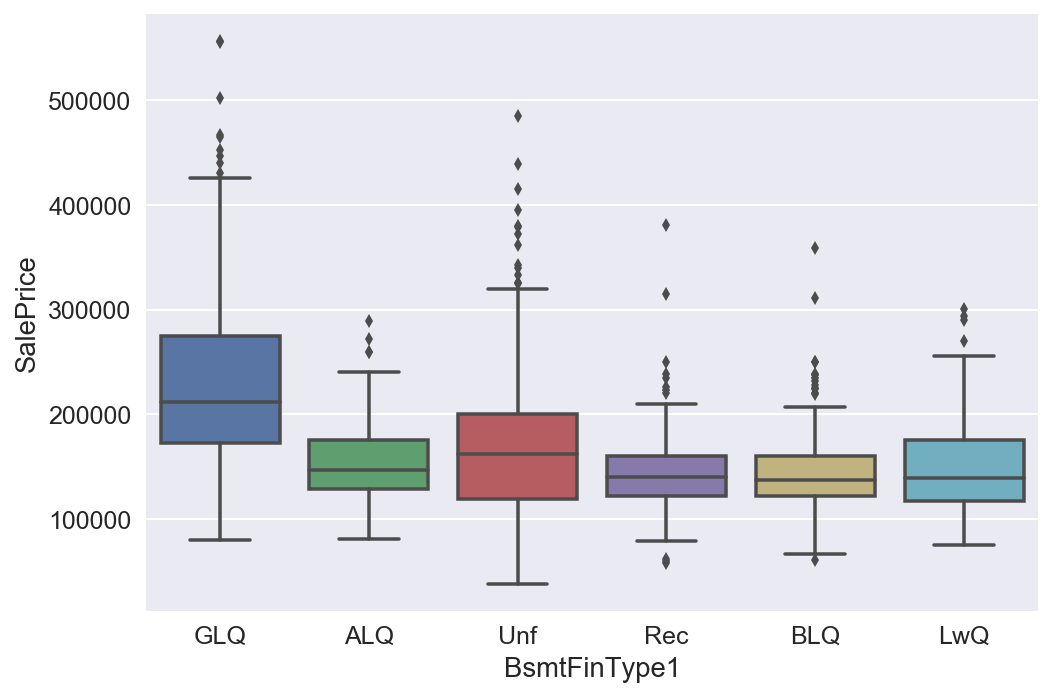

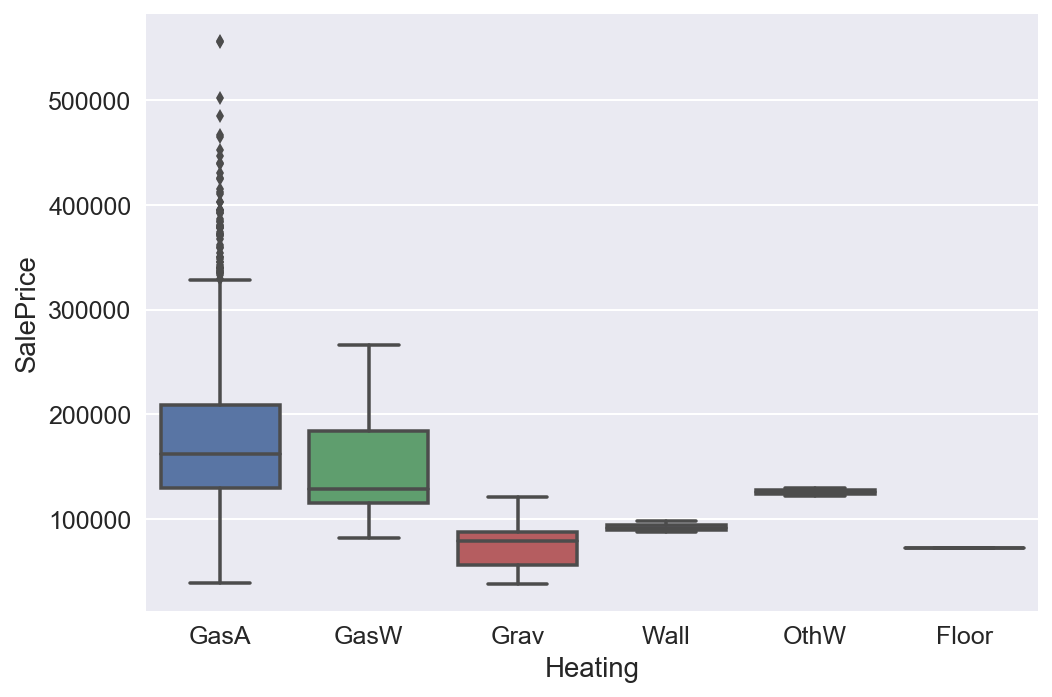

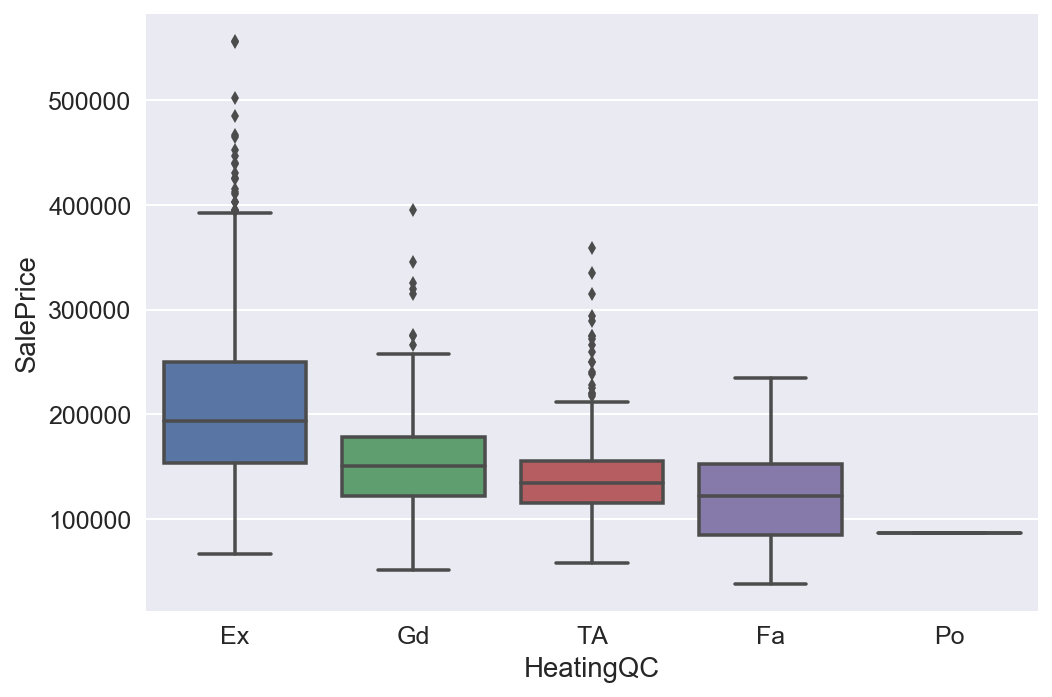

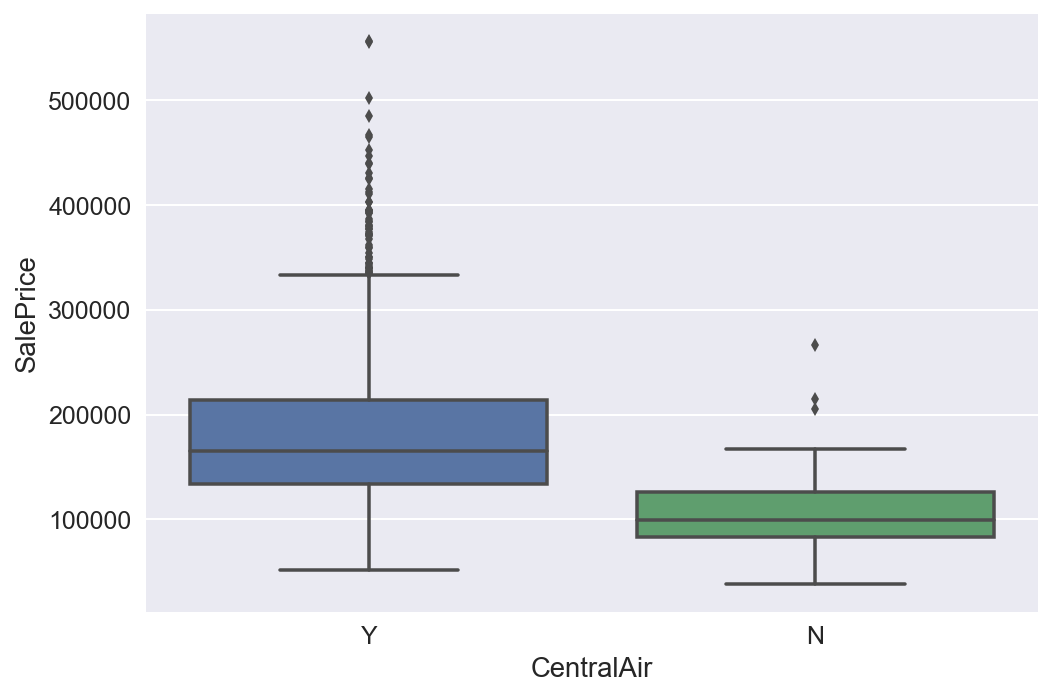

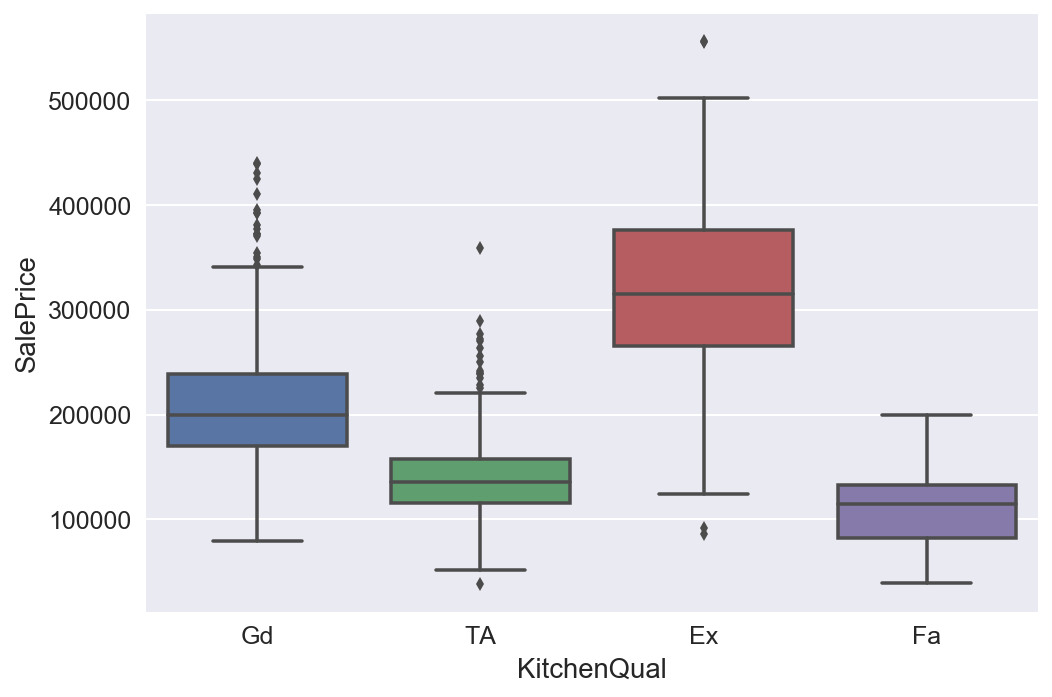

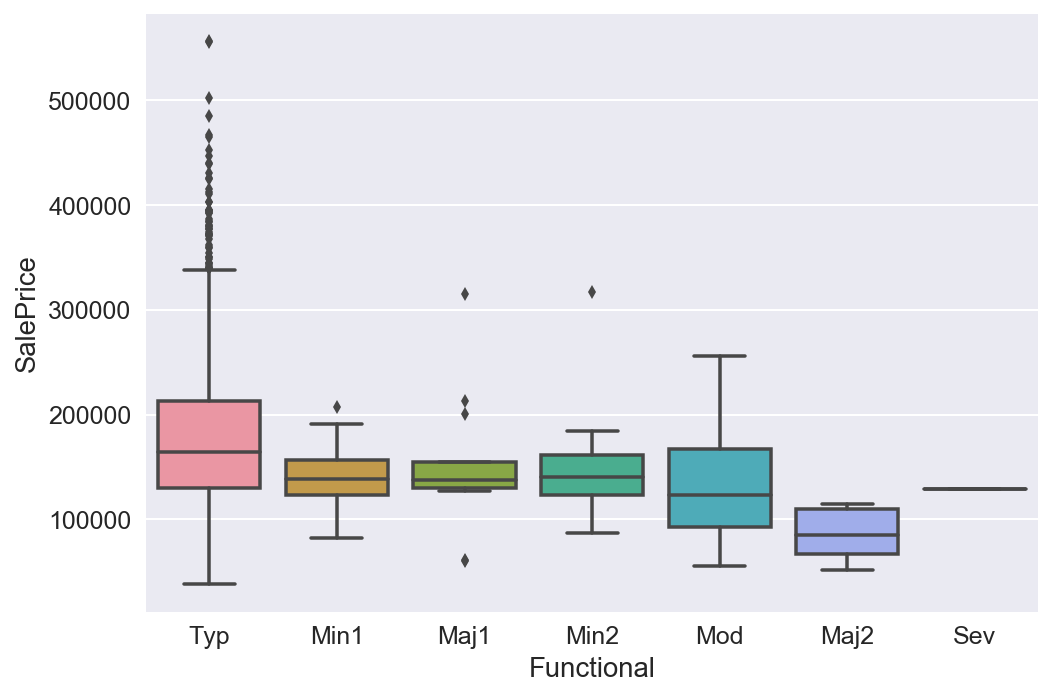

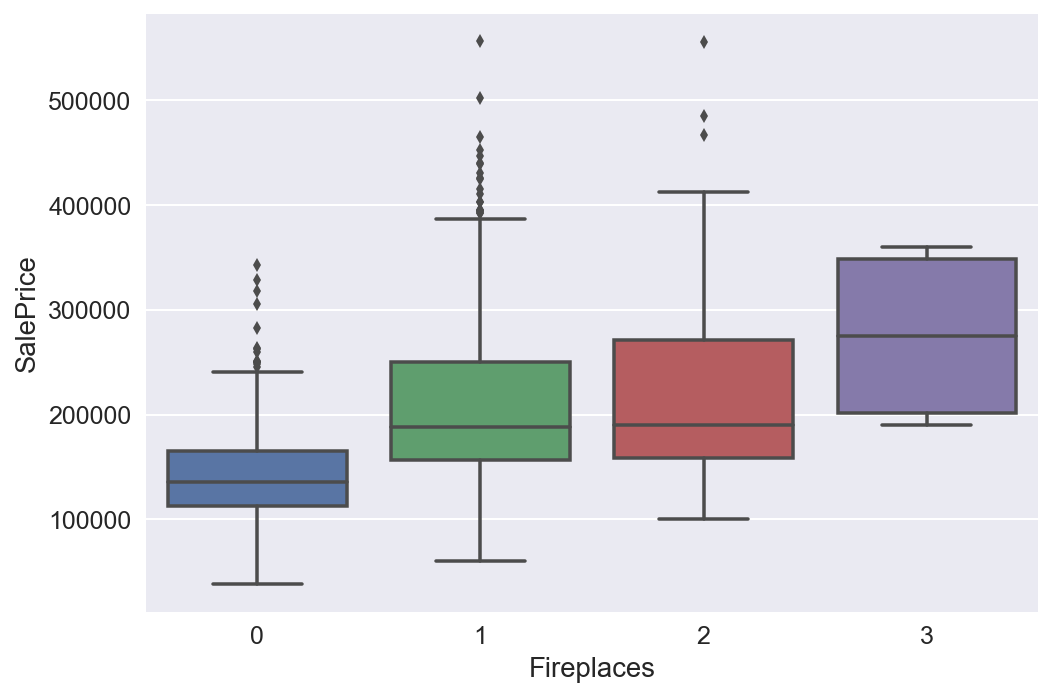

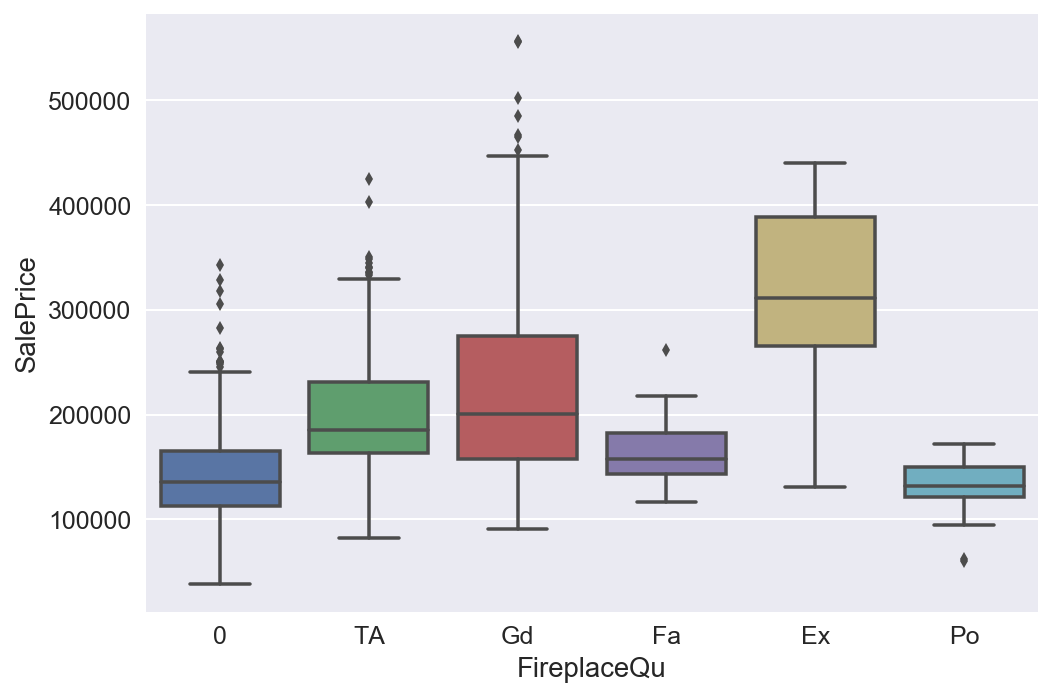

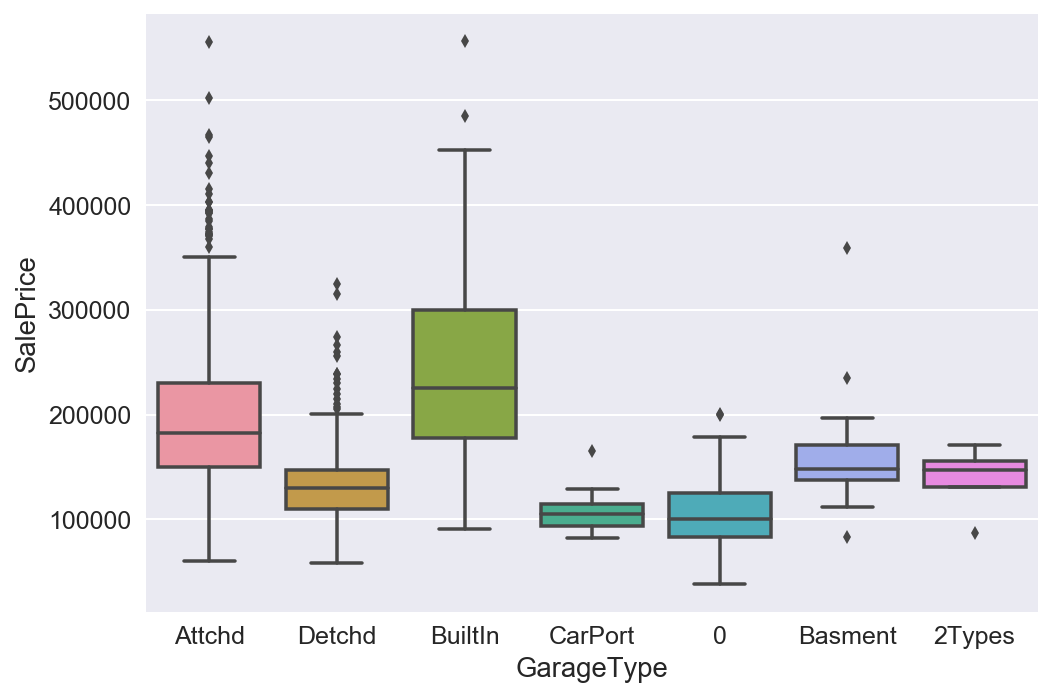

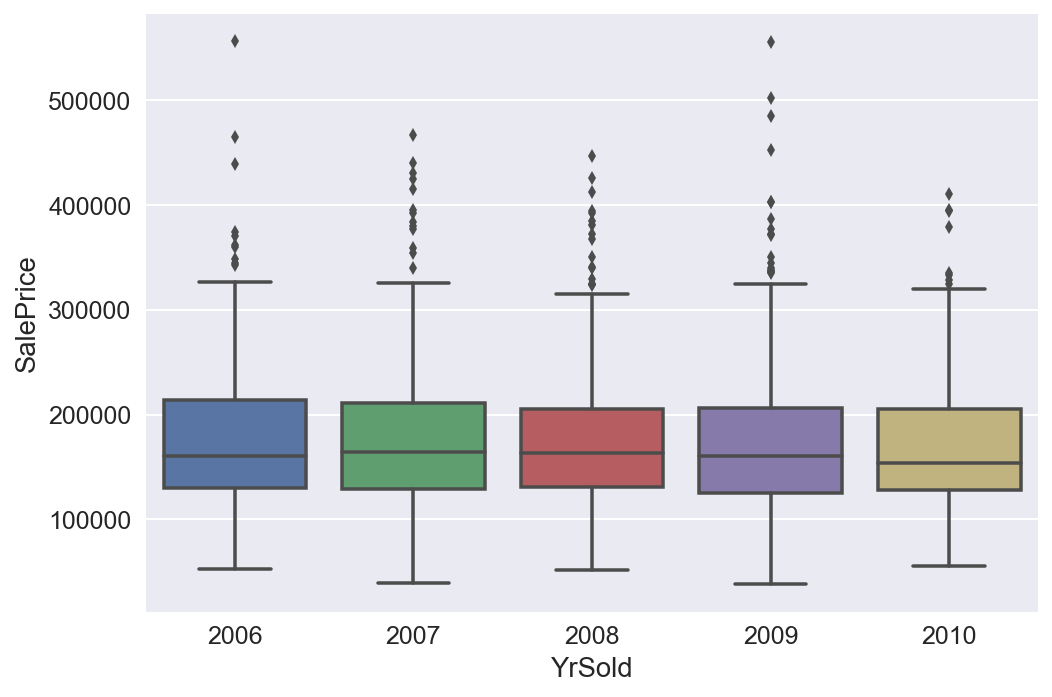

In [66]:

#Find null and missing values.
house2.isnull().sum()
house2.BsmtQual.fillna(0, inplace=True)
house2.FireplaceQu.fillna(0, inplace=True)
house2.GarageType.fillna(0, inplace=True)
house2.isnull().sum()

#sns.lmplot(house2.OverallQual, house2.SalePrice, data=house2, hue='Utilities')
plt.show()
for i in unfixed:
    sns.boxplot(i, 'SalePrice', data=house2)
    plt.show()


In [67]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 26)


In [68]:
to_drop= ['Utilities', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' ]
house2.drop(to_drop, axis=1, inplace=True)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 16)


In [69]:
#All feature modification goes here
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == 'SFoyer' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '1.5Unf' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '2.5Unf' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '2.5Fin' else x)

house2.ExterCond.value_counts()
#house2.drop(house2.loc['ExterCond'] == 'Ex', inplace=True)
house2.ExterCond.value_counts()


print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 16)


In [70]:
temp = pd.get_dummies(house2.HouseStyle, prefix='HouseStyle')
house2 = pd.concat([house2, temp], axis=1,)
house2.drop('HouseStyle', axis=1, inplace=True)

temp = pd.get_dummies(house2.ExterCond, prefix='ExterCond')
house2 = pd.concat([house2, temp], axis=1)
house2.drop('ExterCond', axis=1, inplace=True)

to_get_dumb = ['CentralAir', 'KitchenQual', 'Fireplaces', 'Functional', 'HeatingQC', 'ExterQual', 'BsmtQual', 
              'Heating', 'FireplaceQu', 'GarageType']
for i in to_get_dumb:
    temp = pd.get_dummies(house2[i], prefix = i)
    house2 = pd.concat([house2, temp], axis=1)
    house2.drop(i, axis=1, inplace=True)

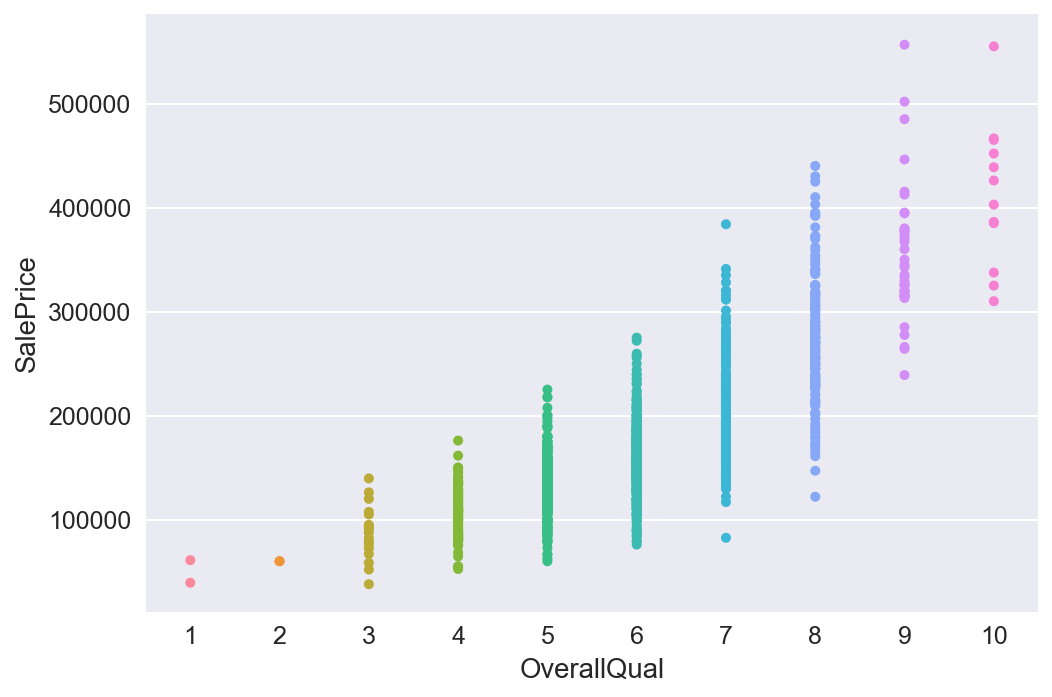

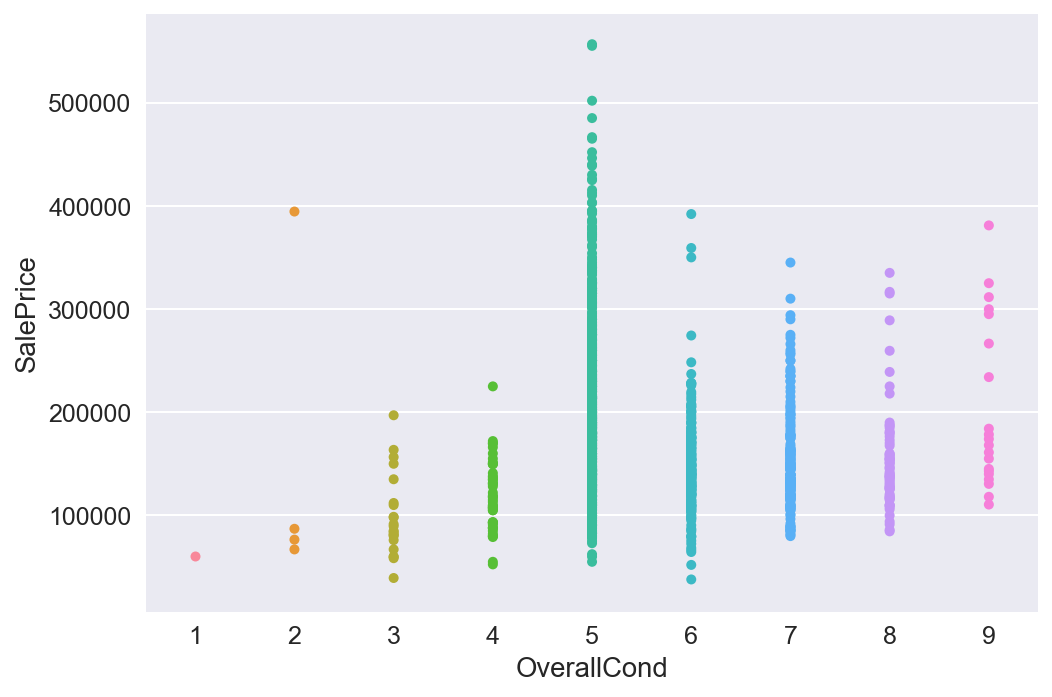

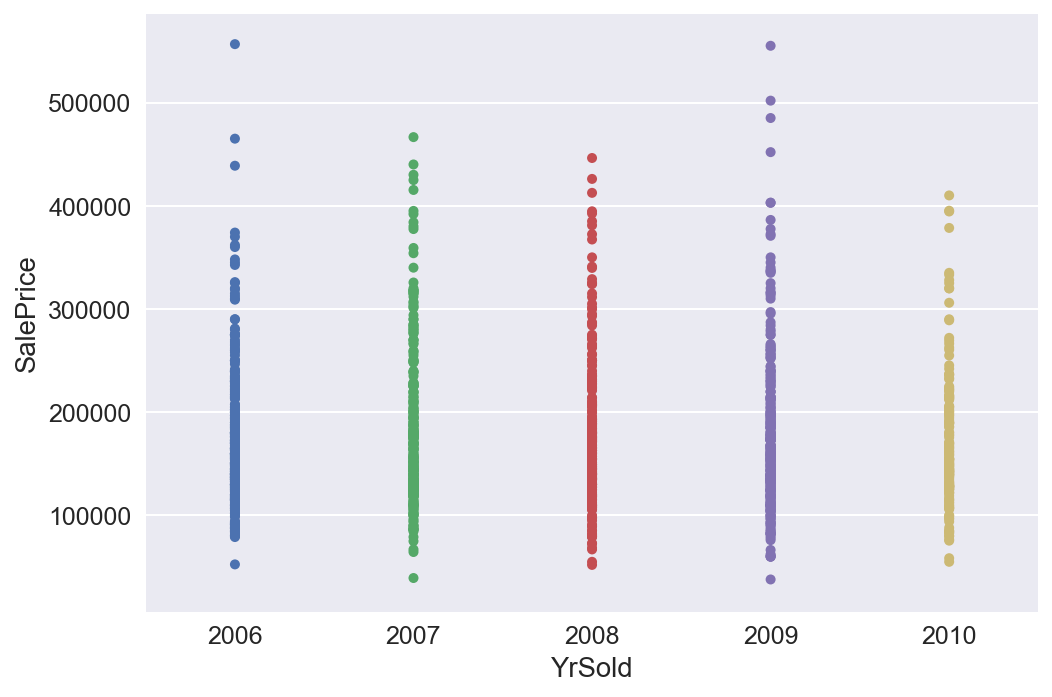

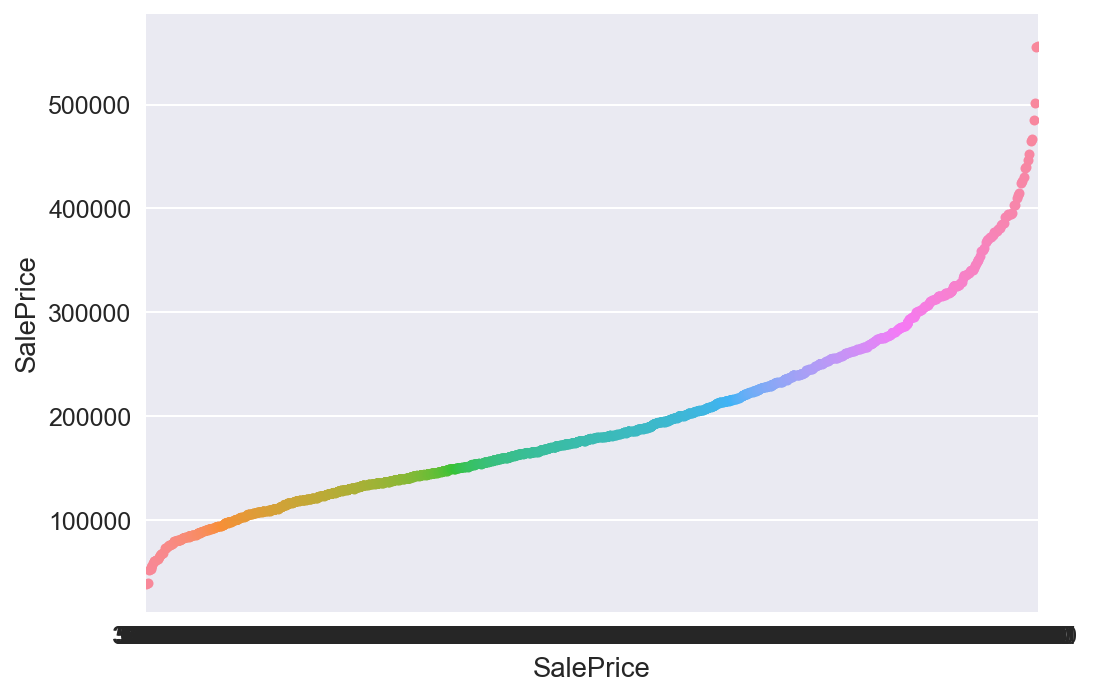

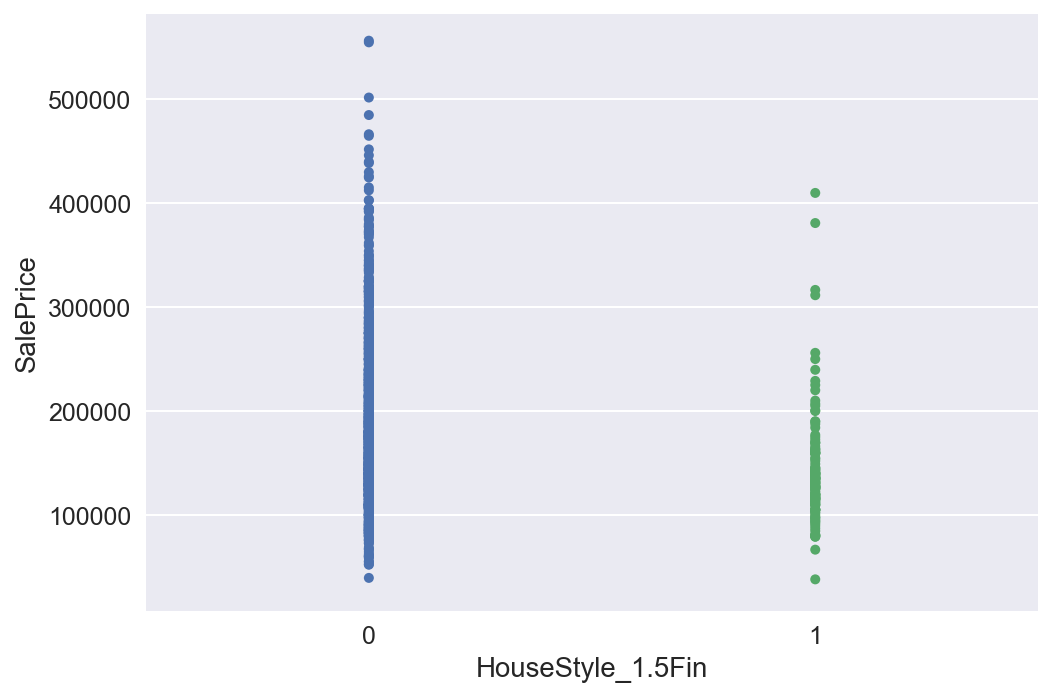

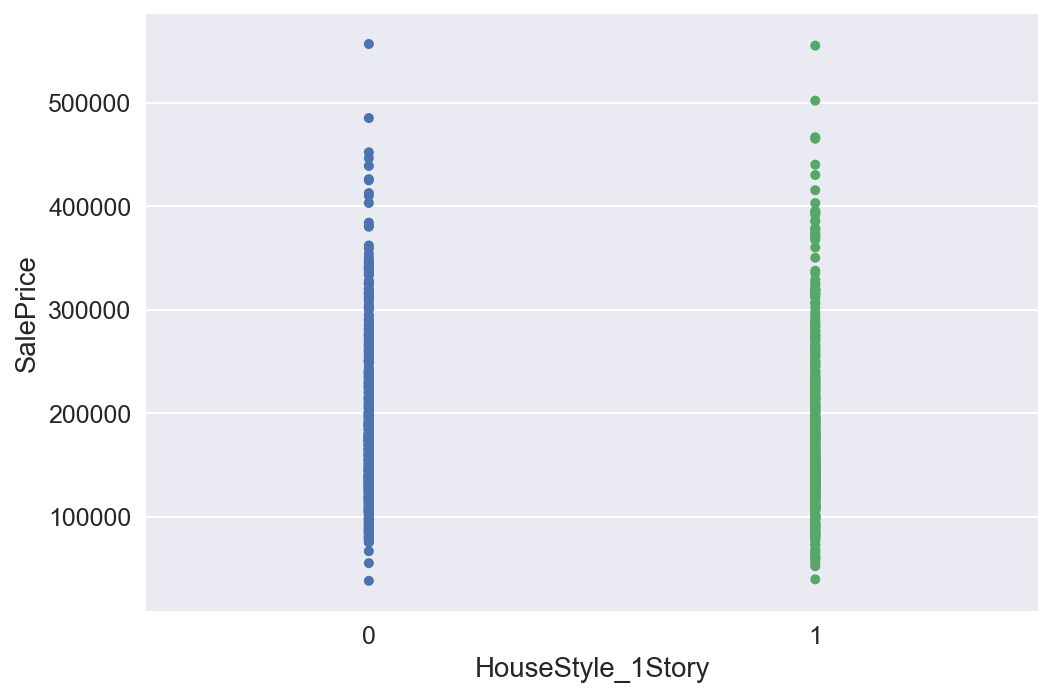

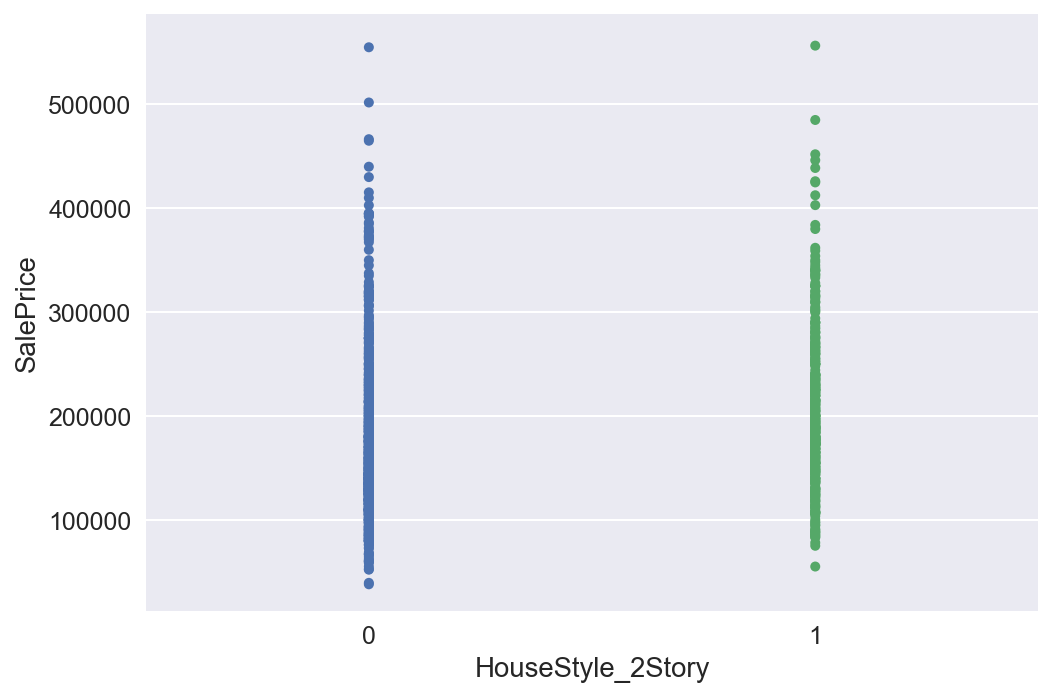

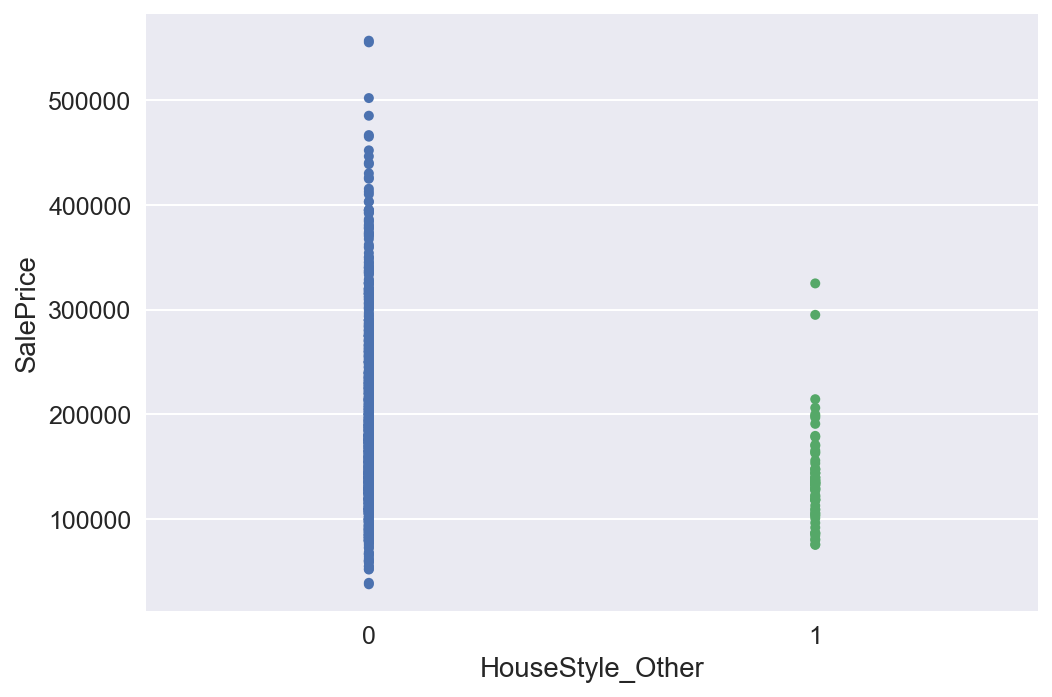

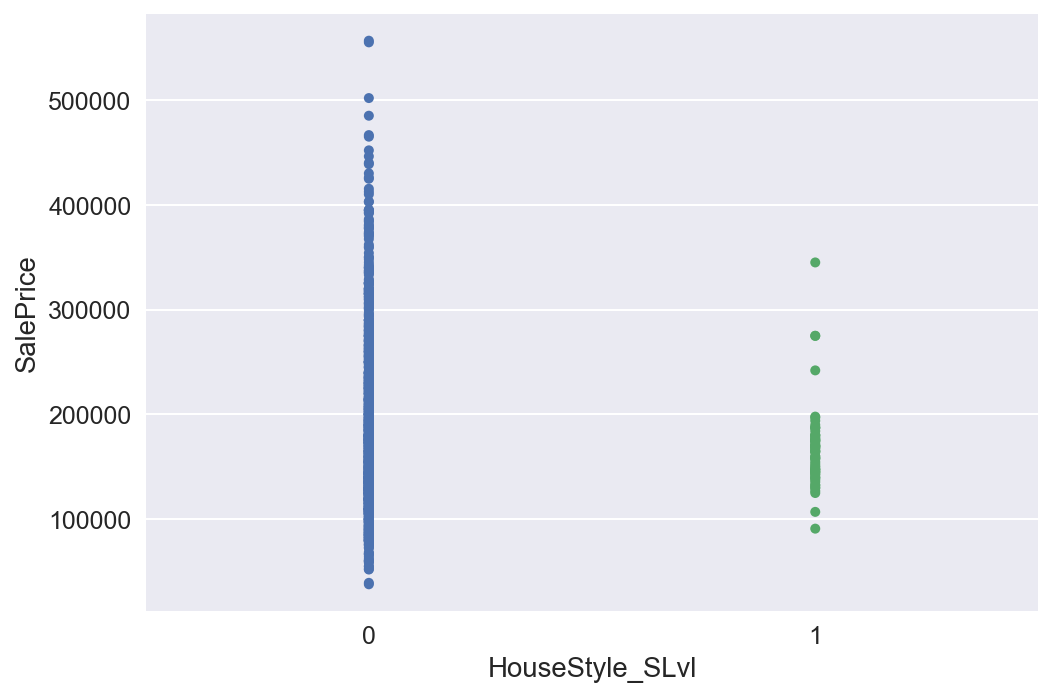

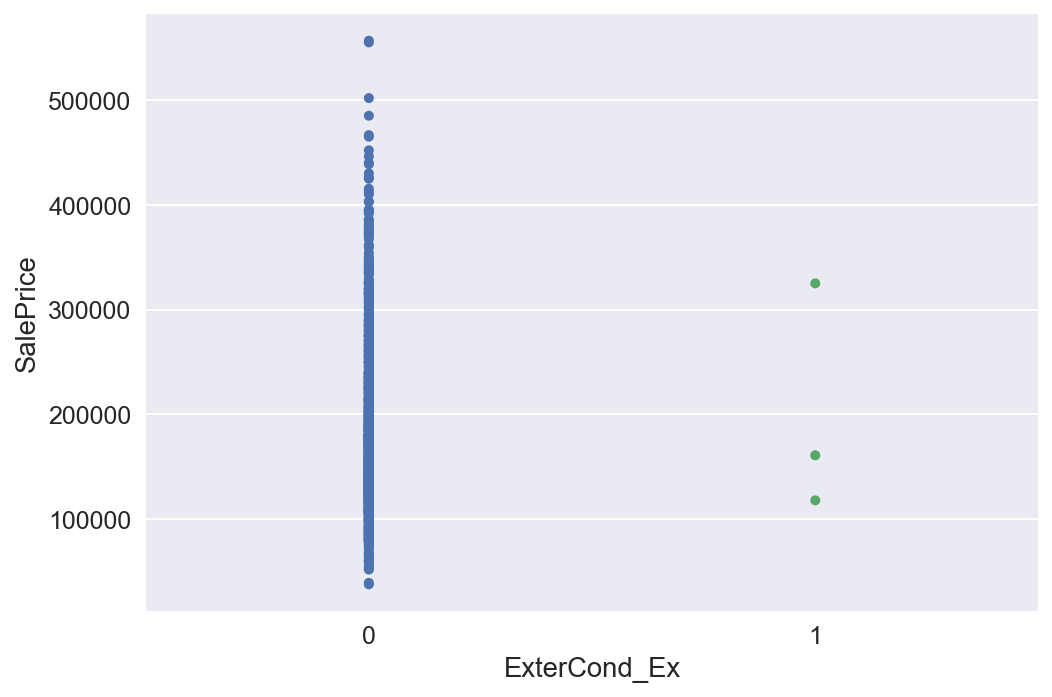

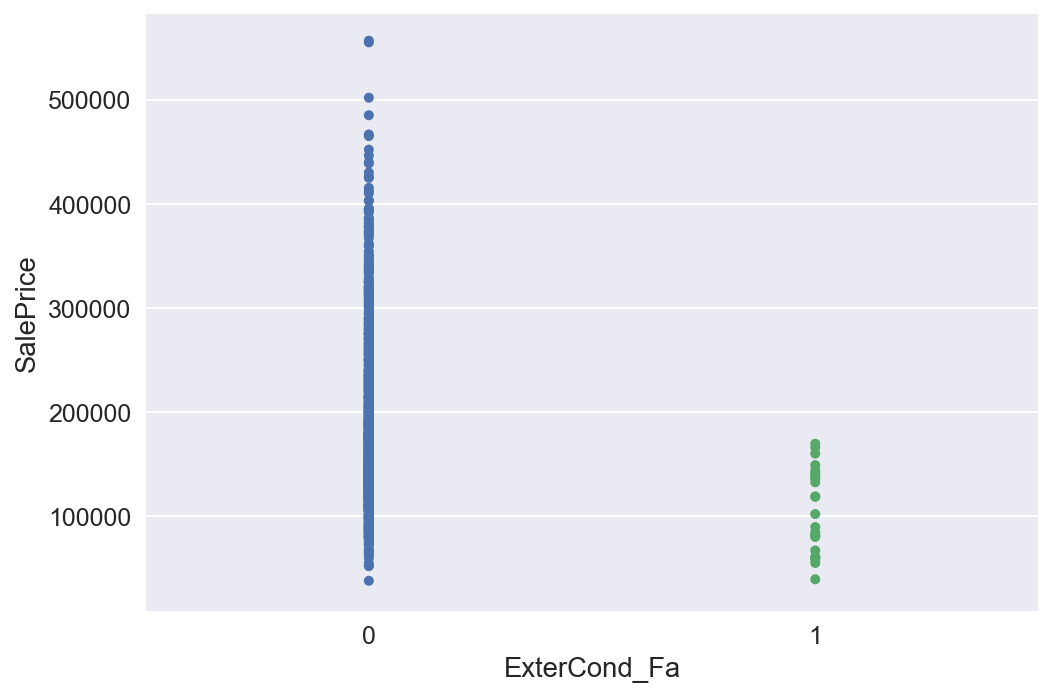

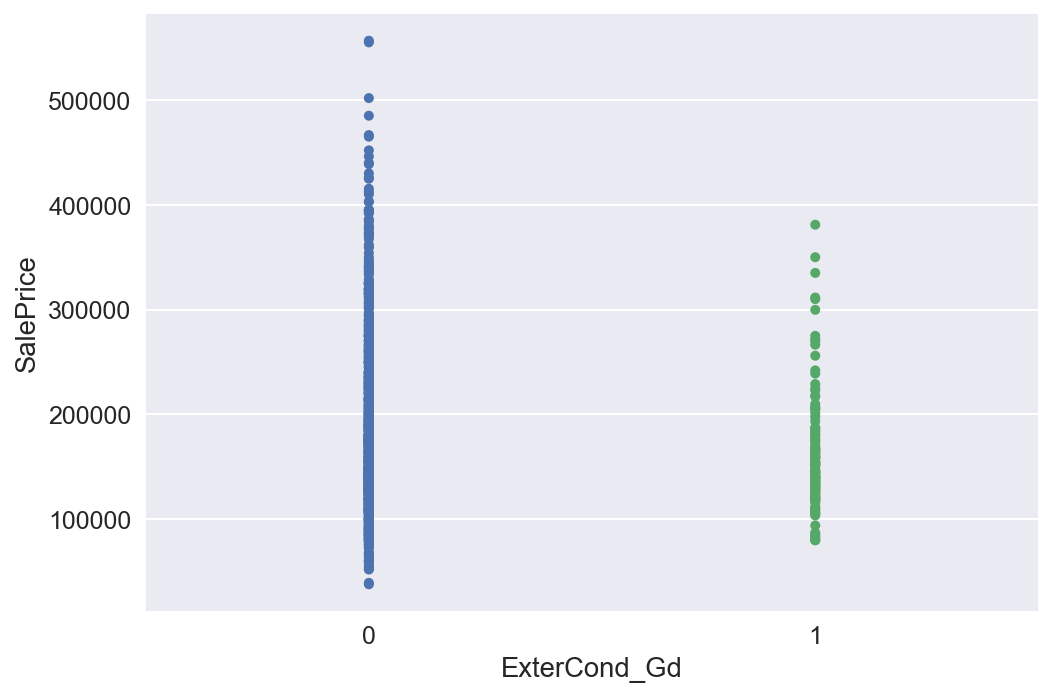

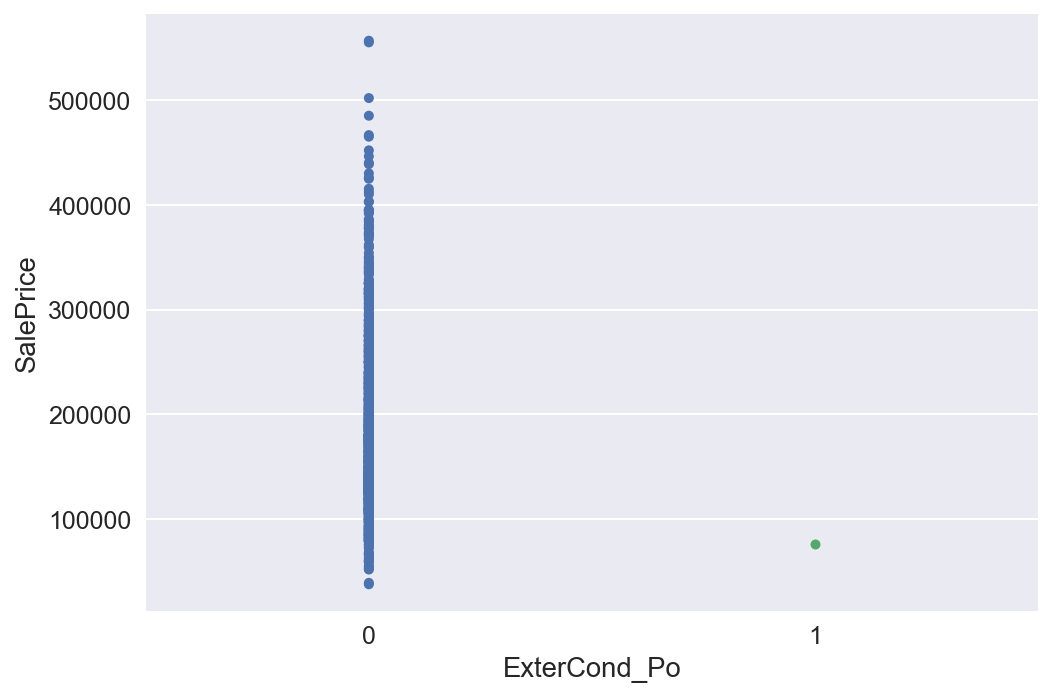

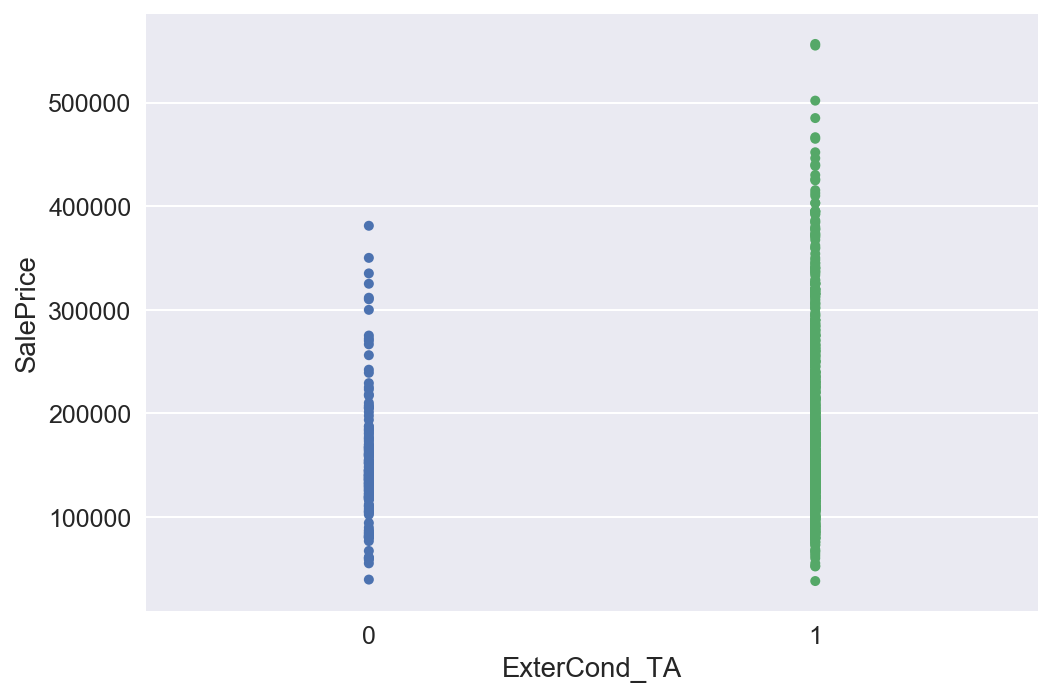

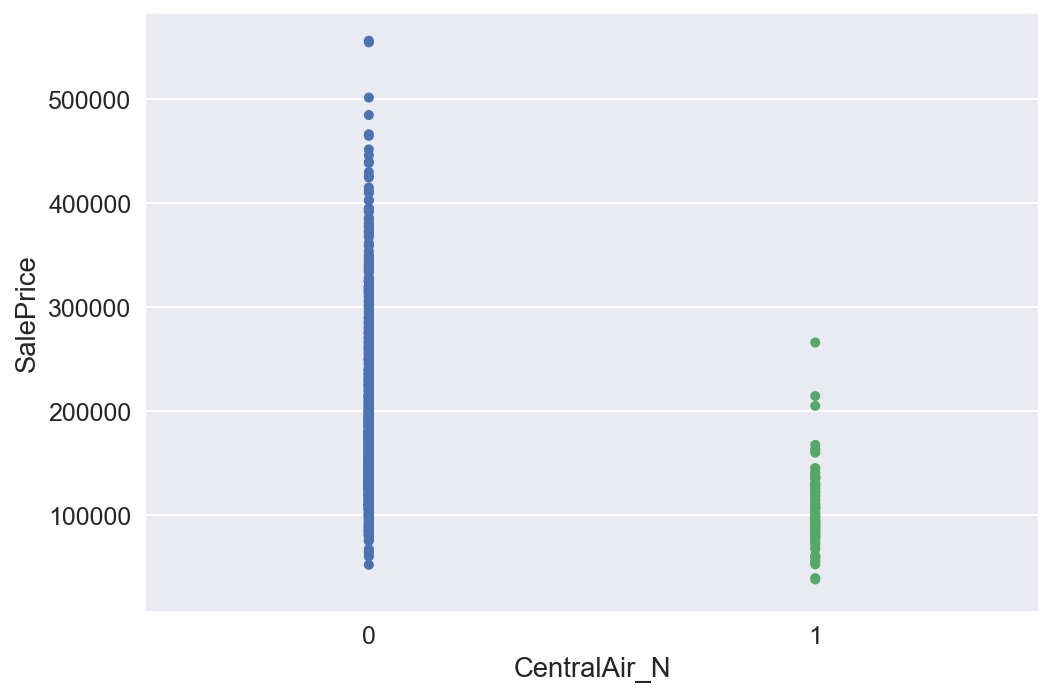

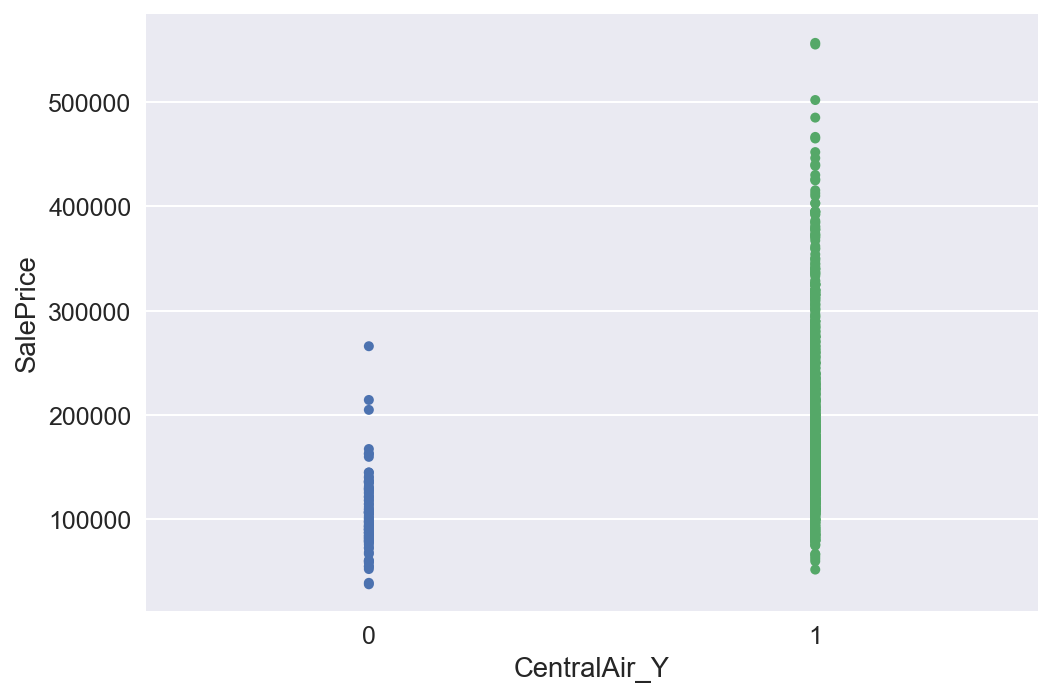

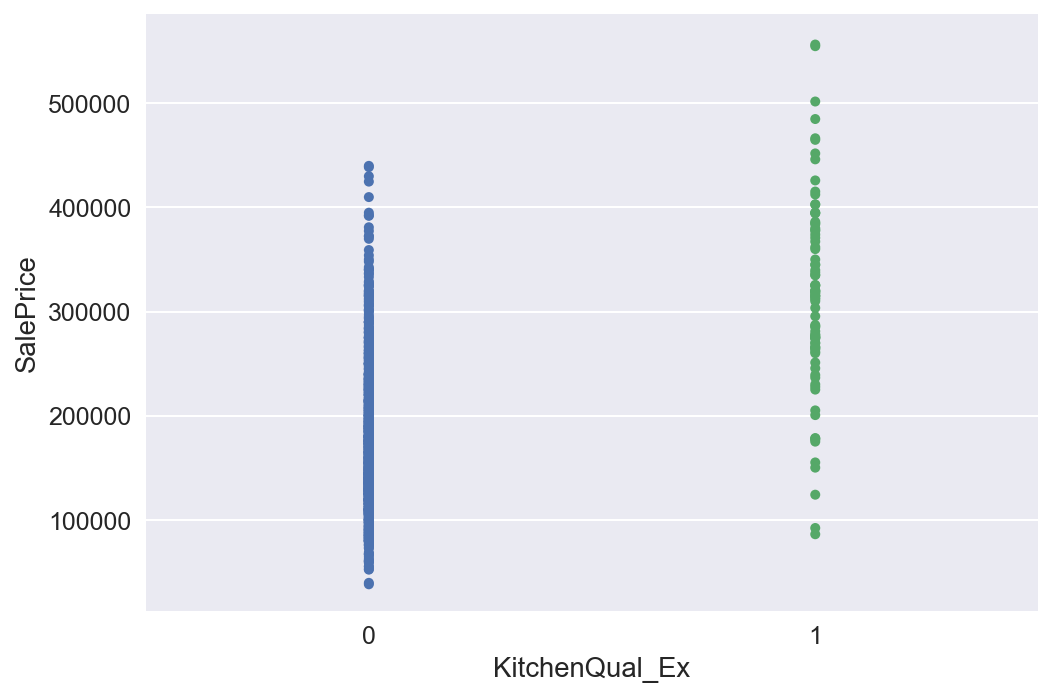

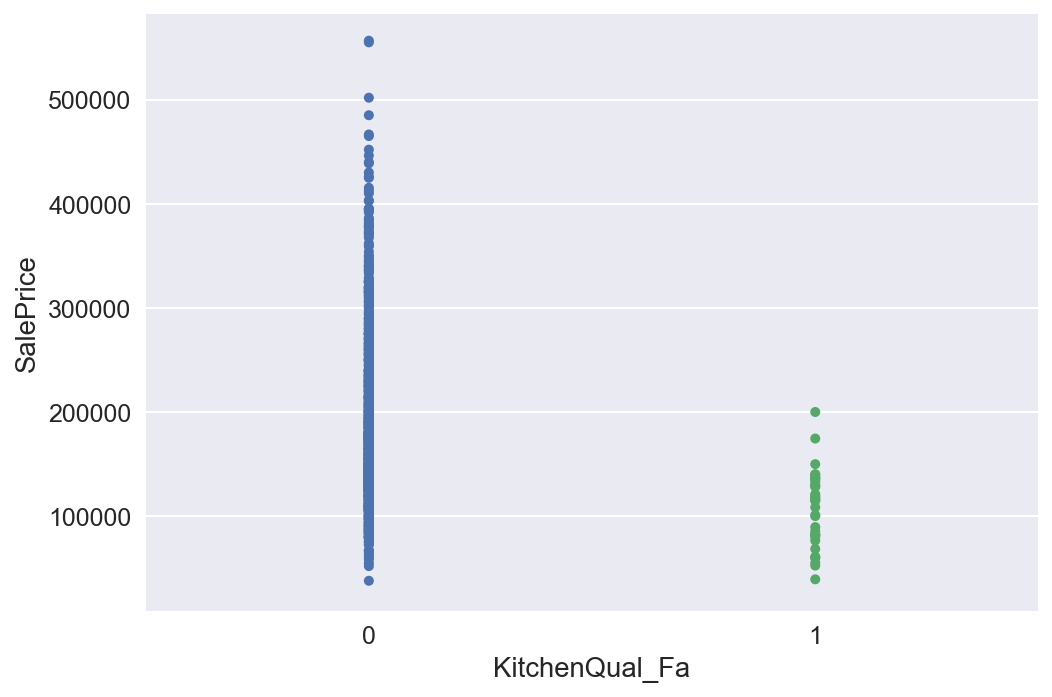

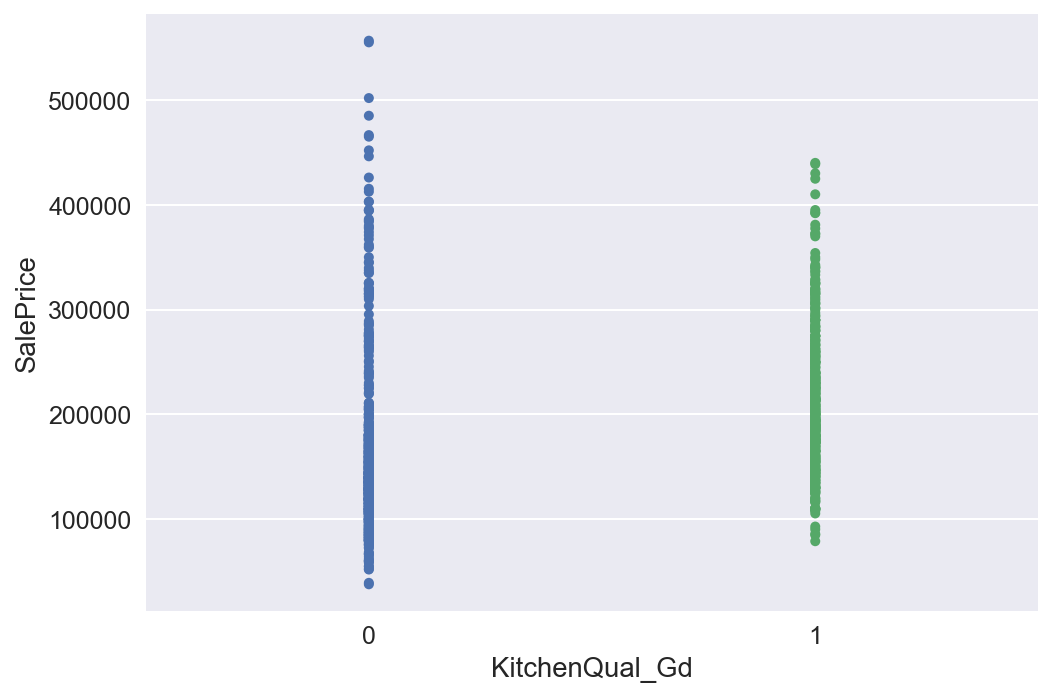

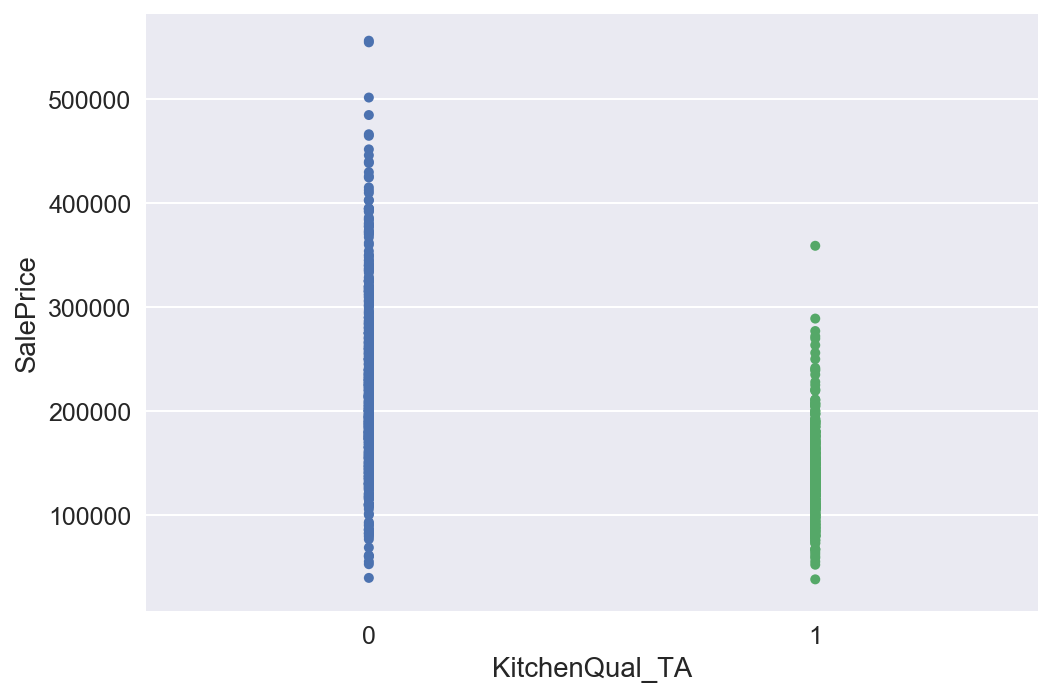

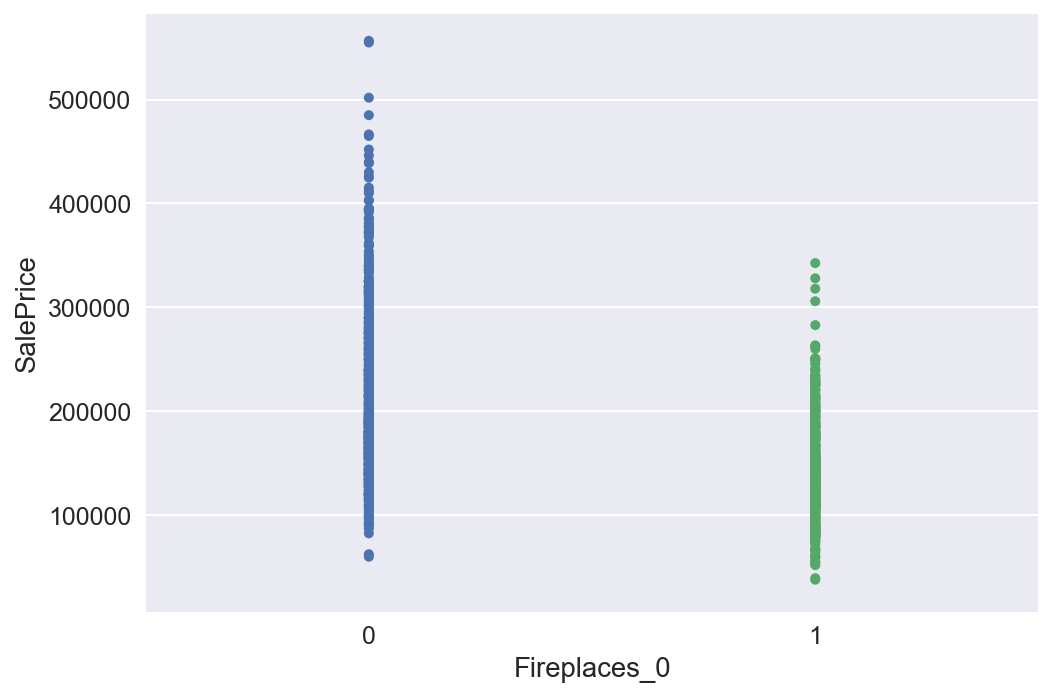

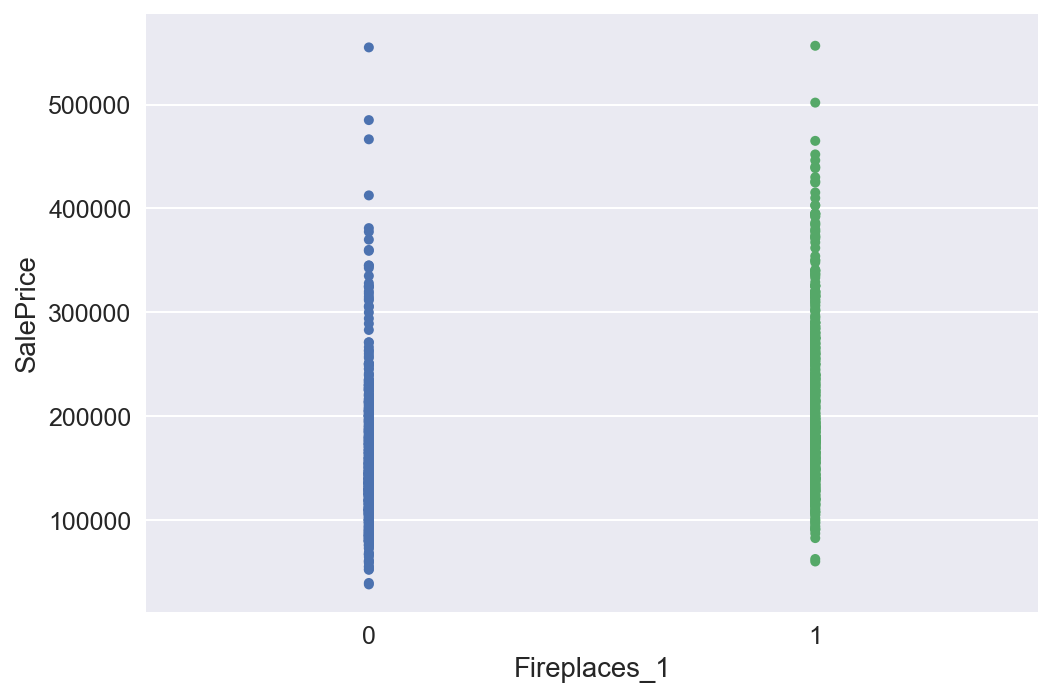

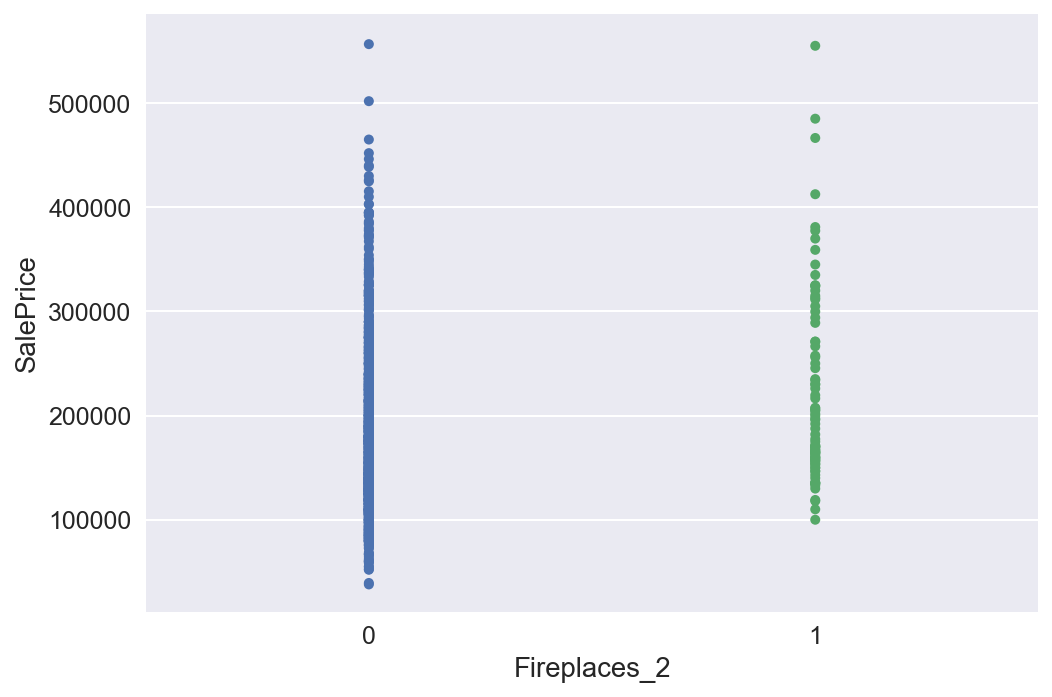

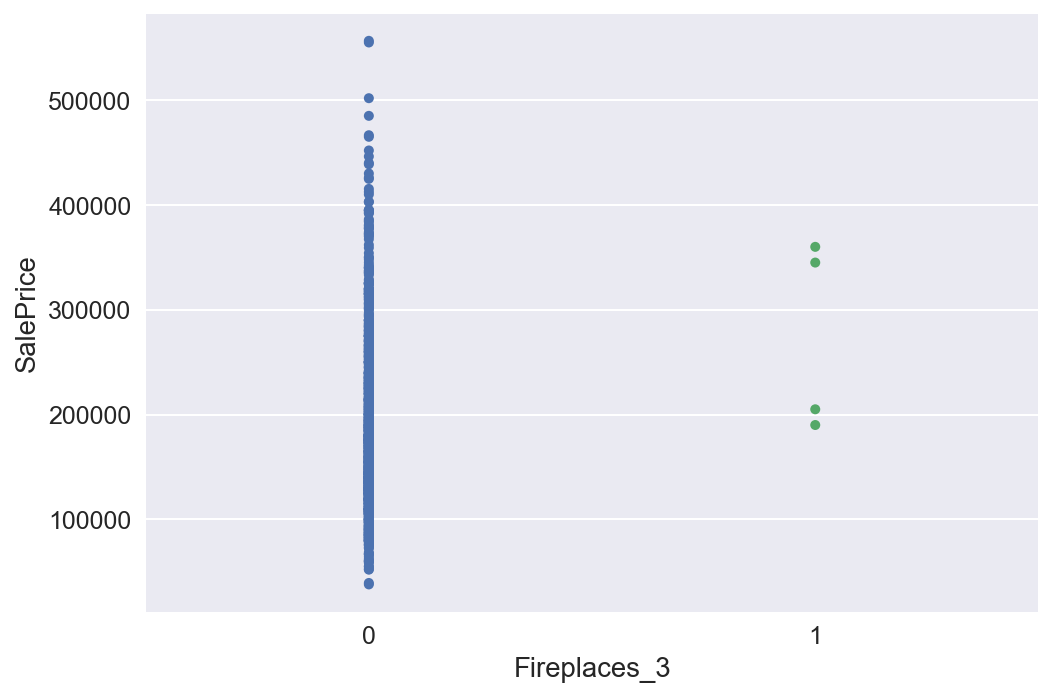

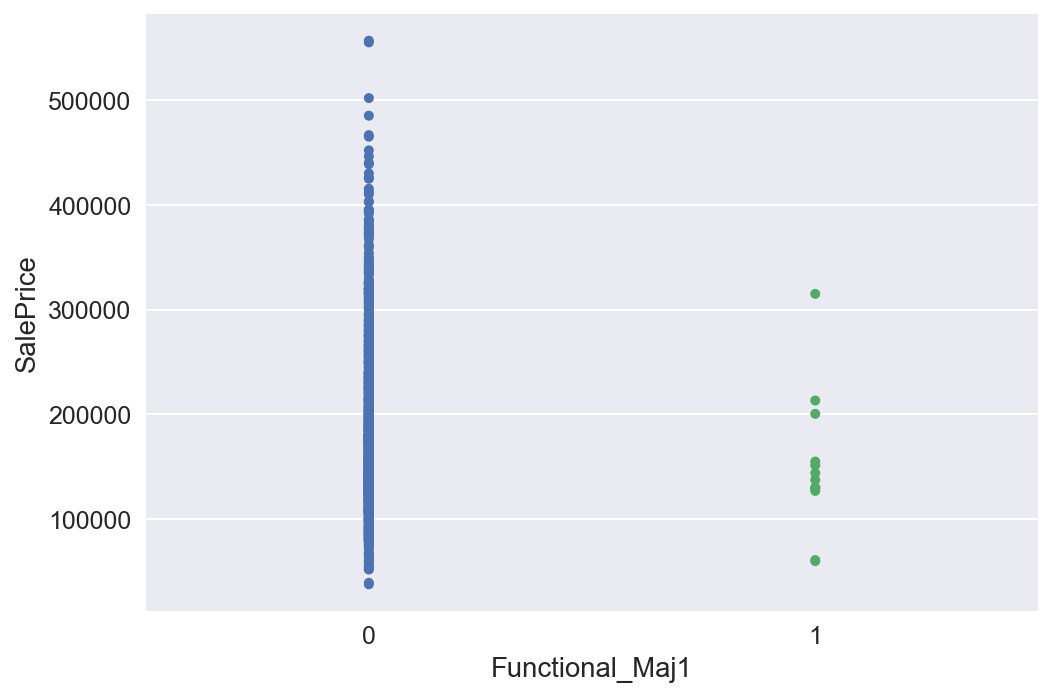

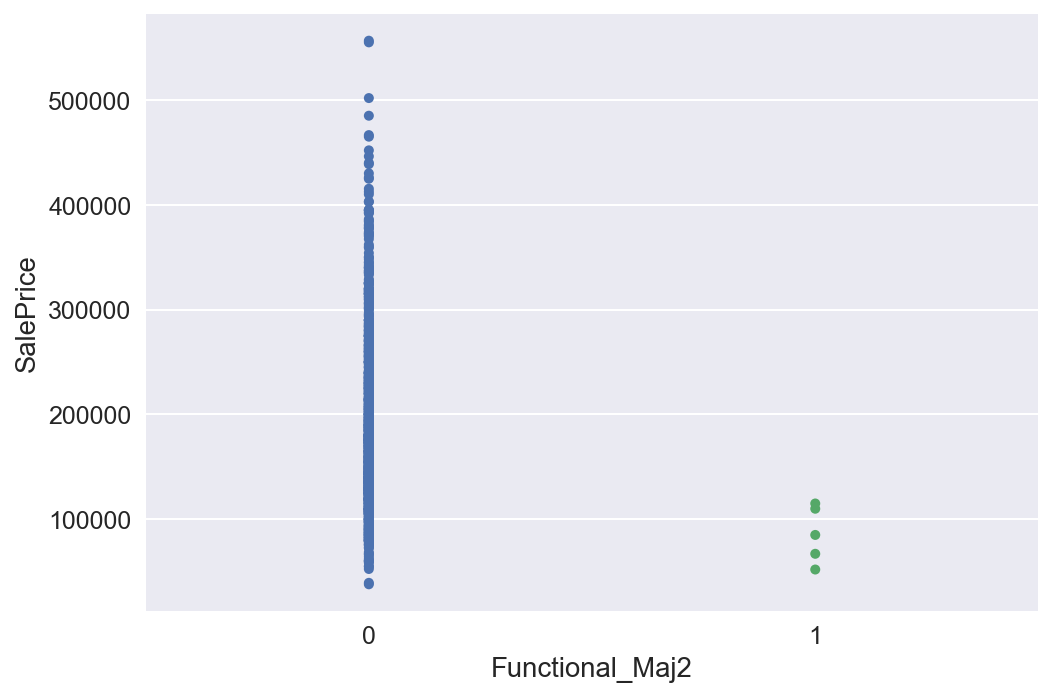

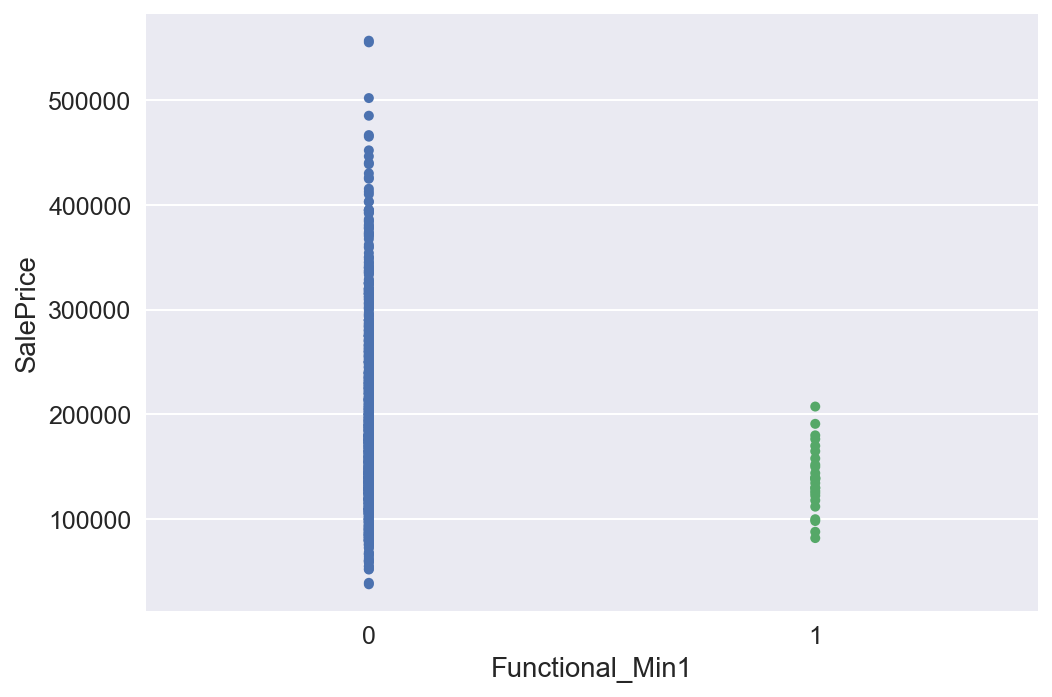

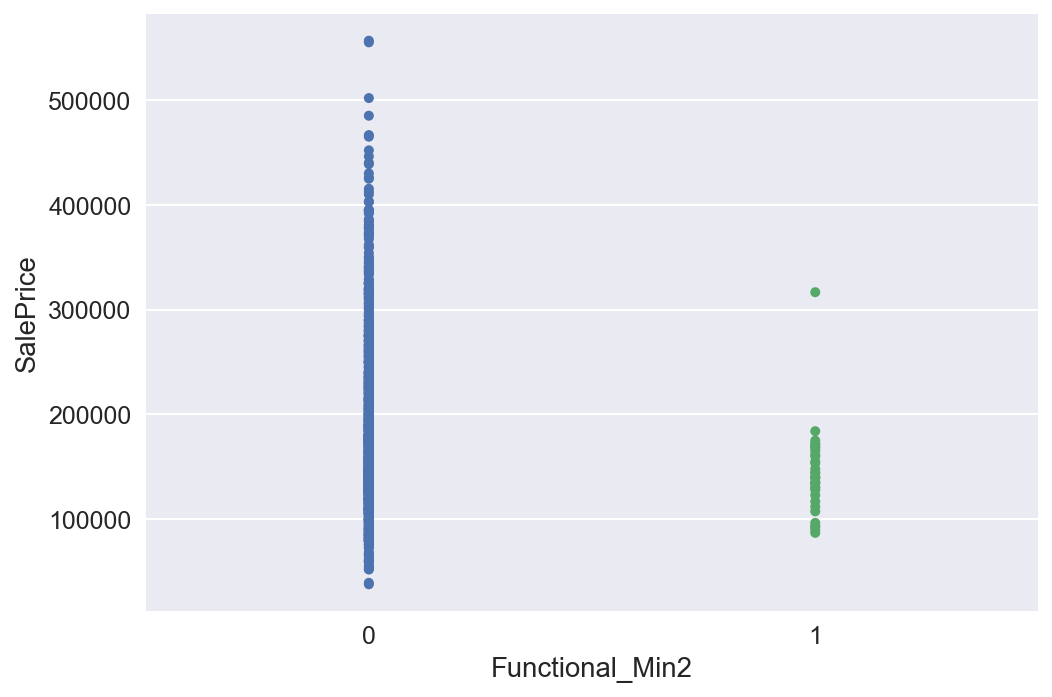

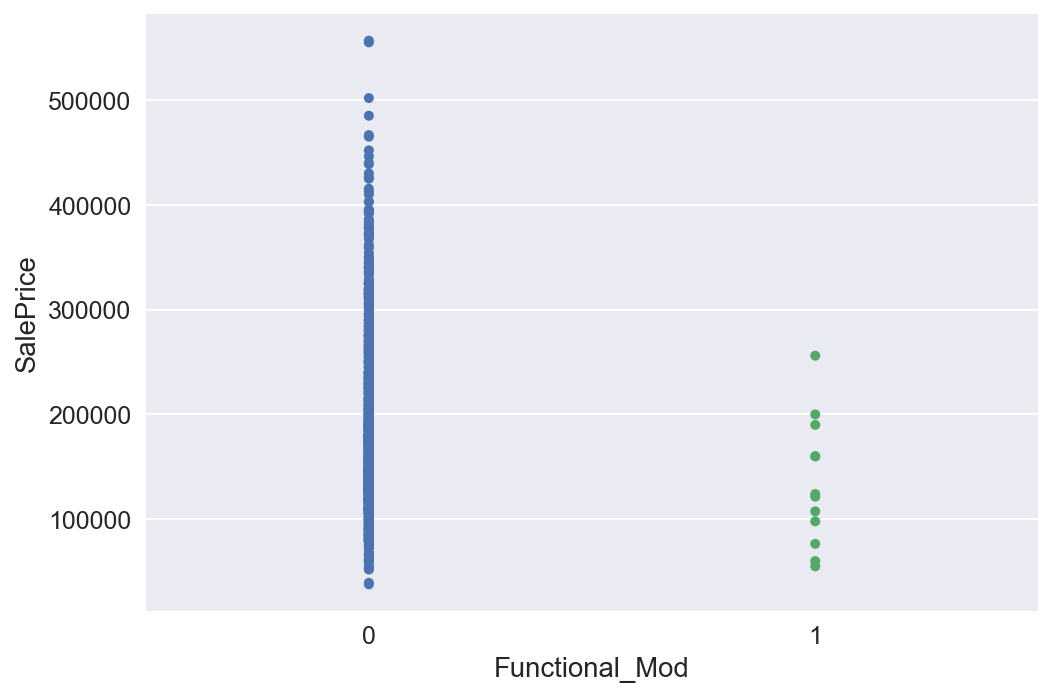

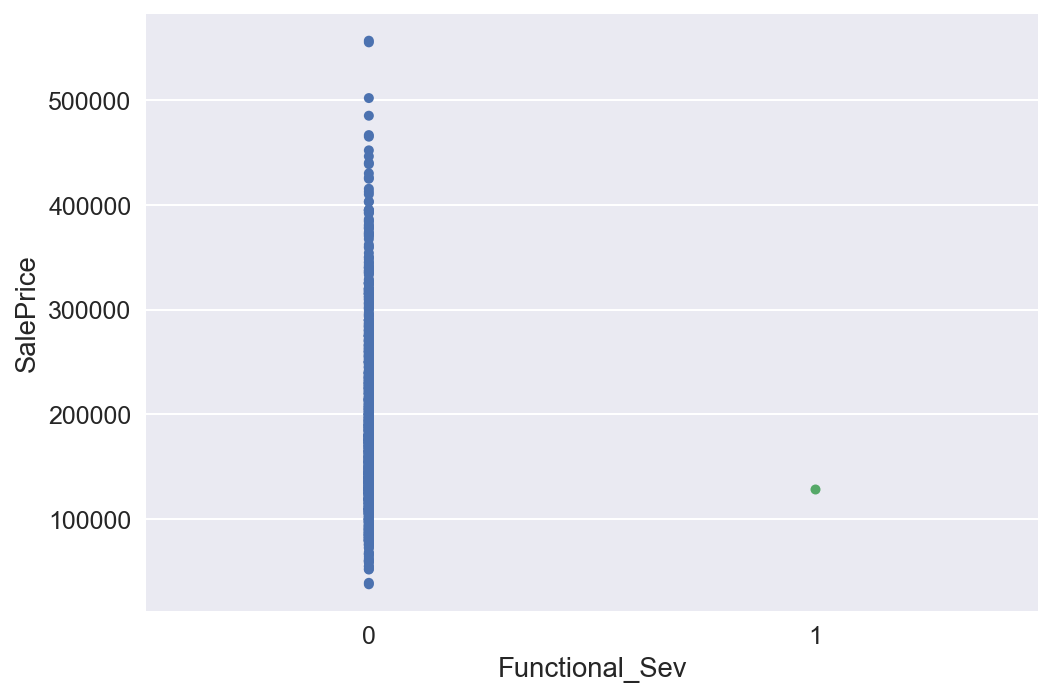

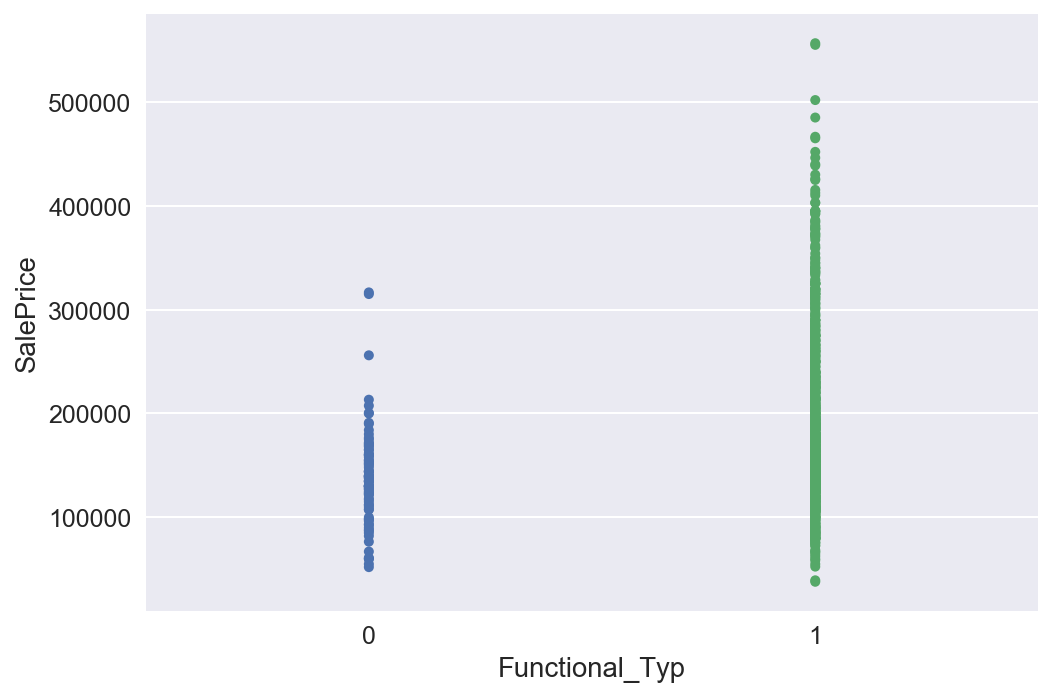

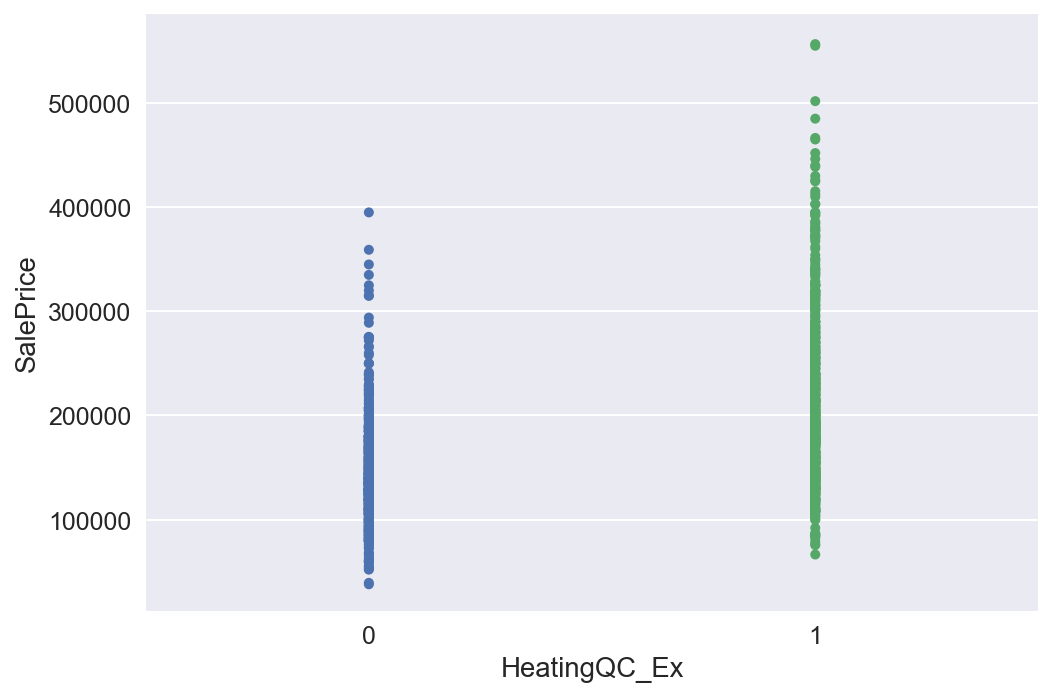

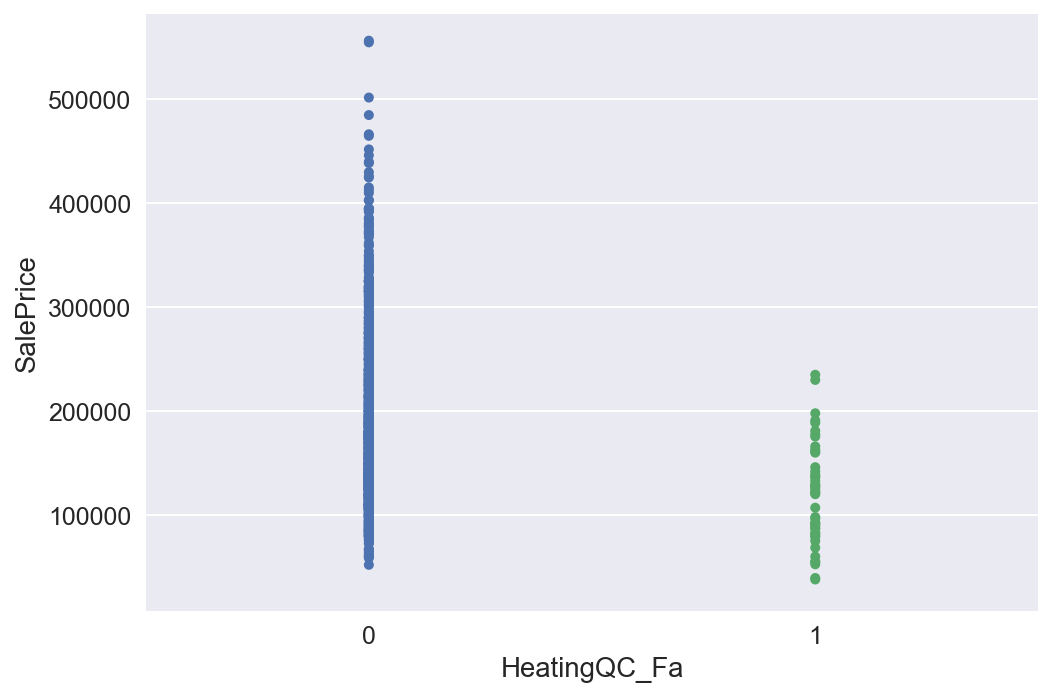

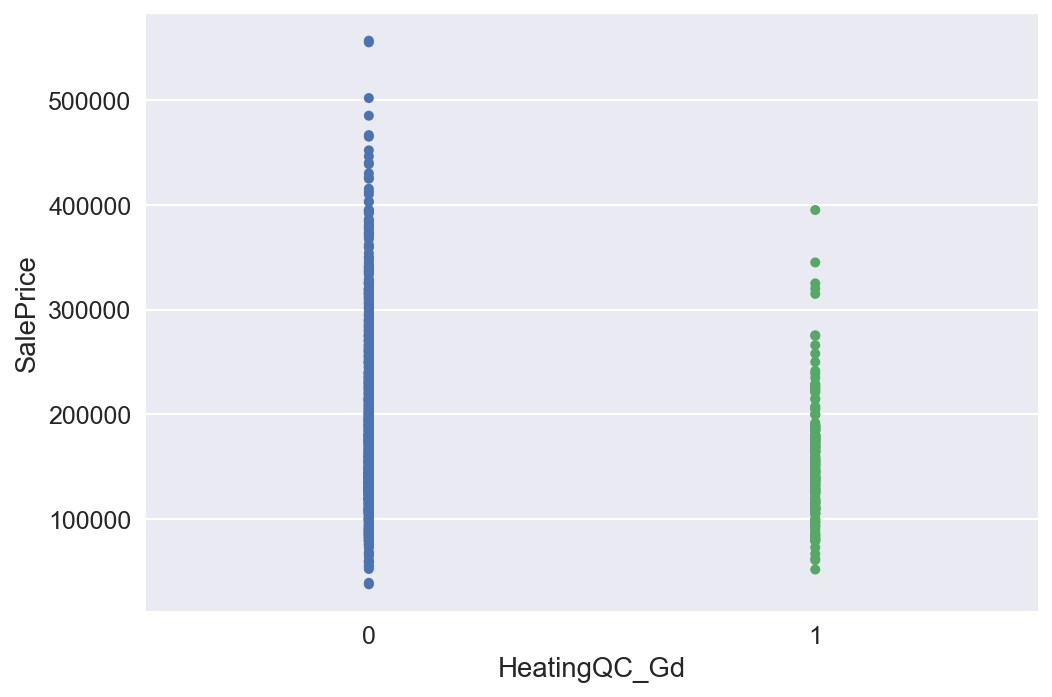

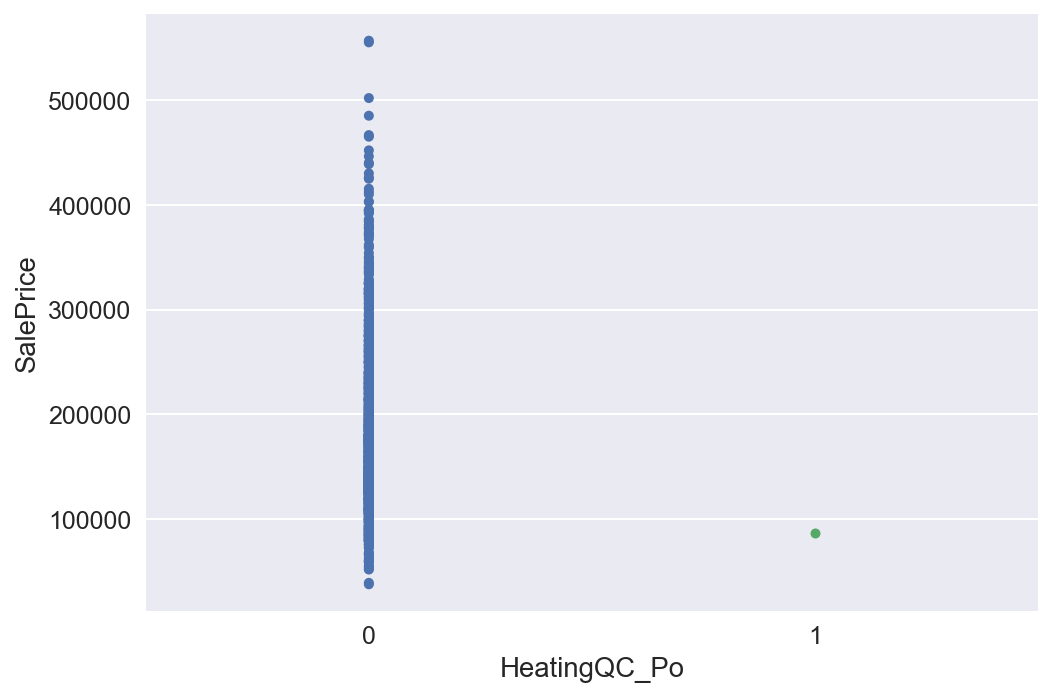

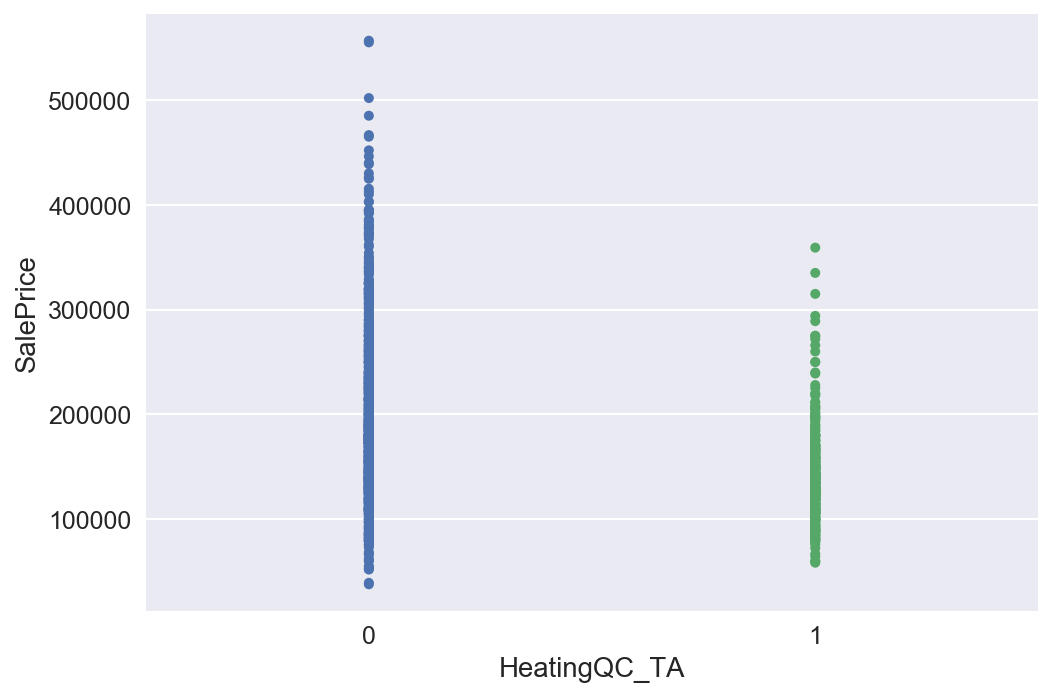

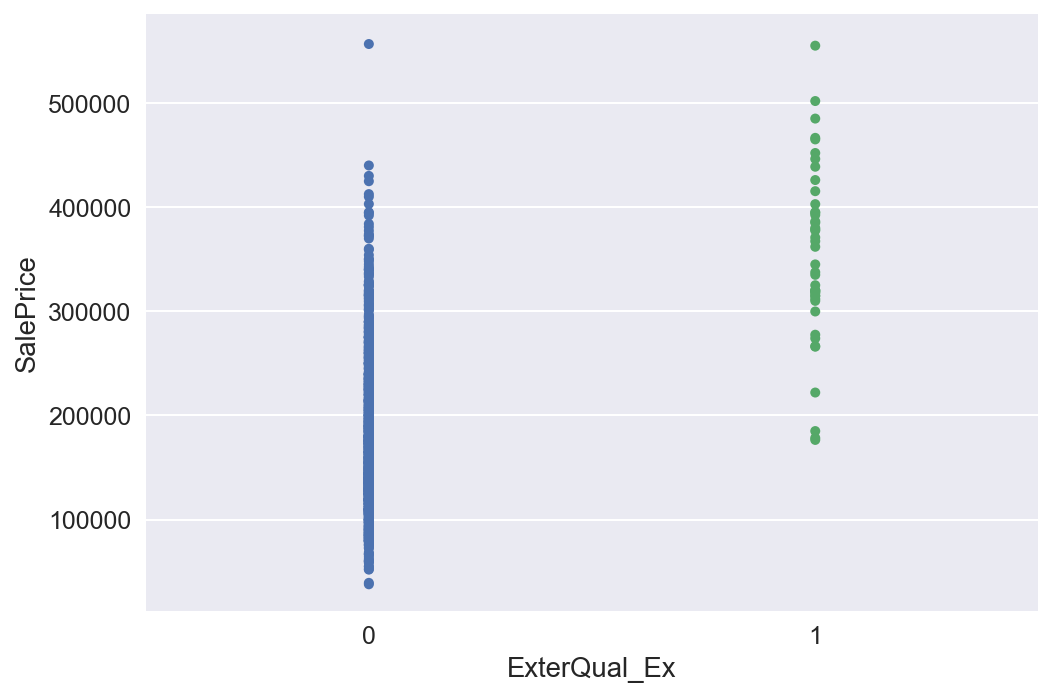

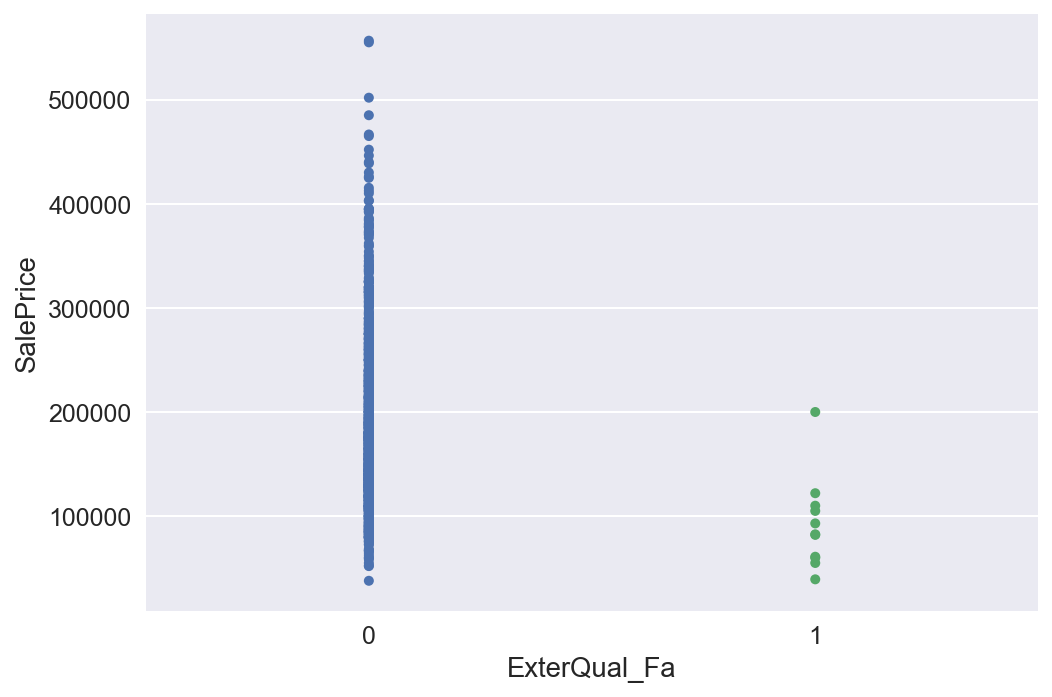

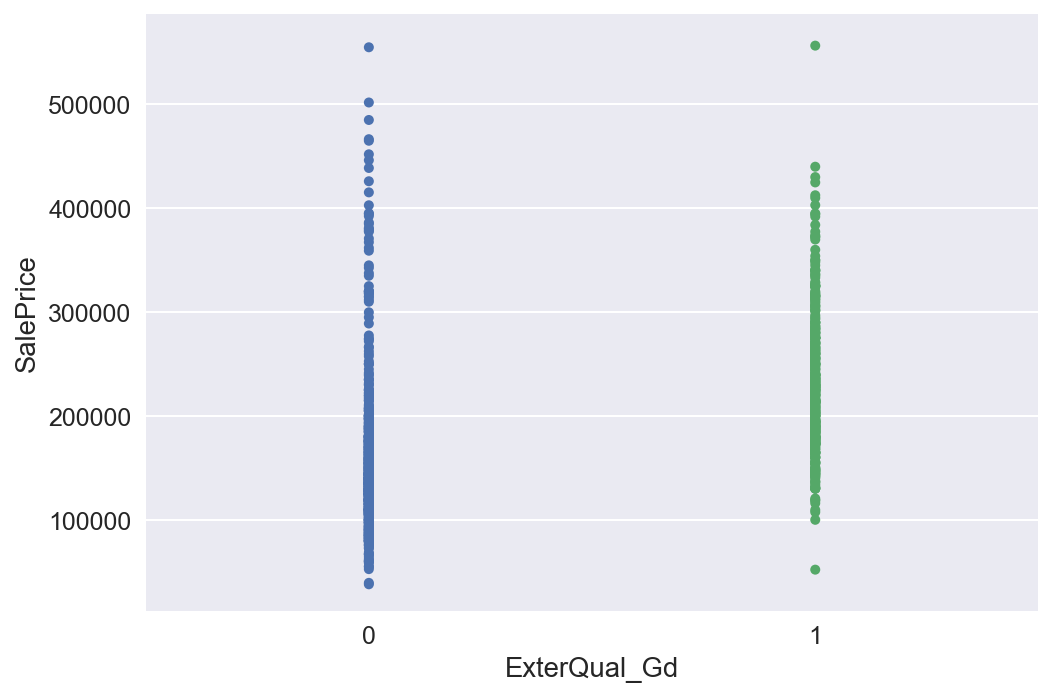

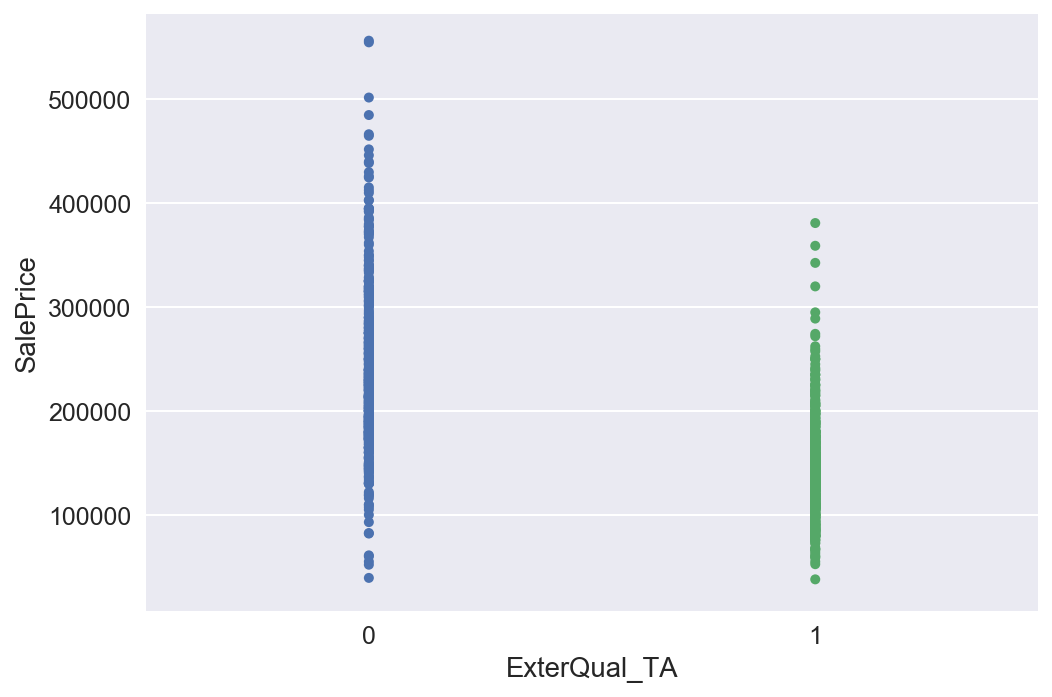

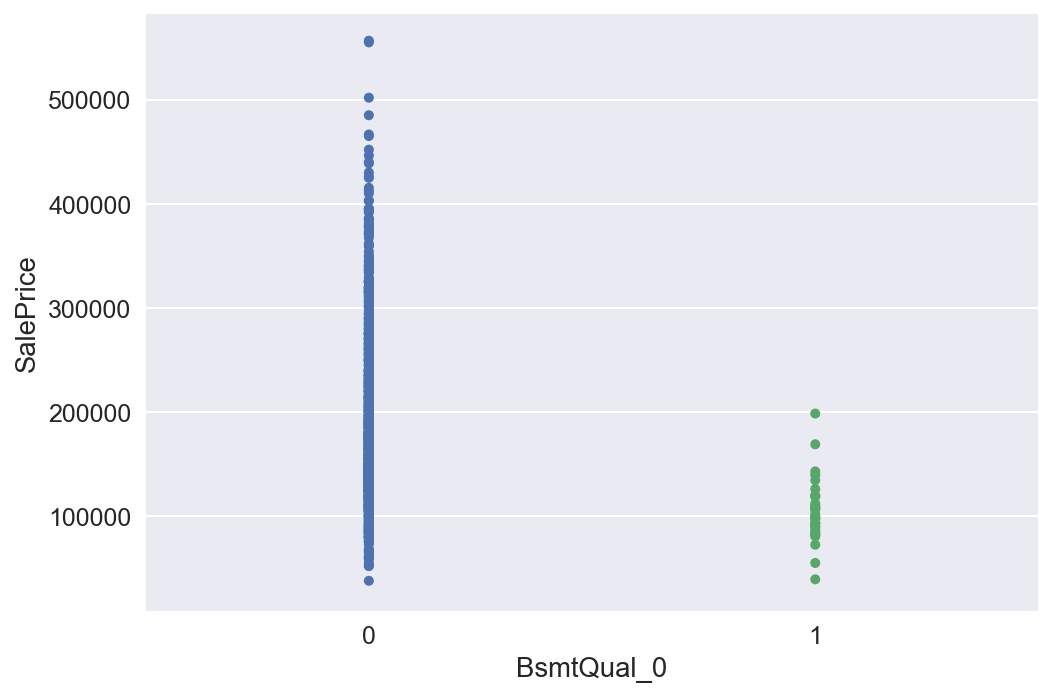

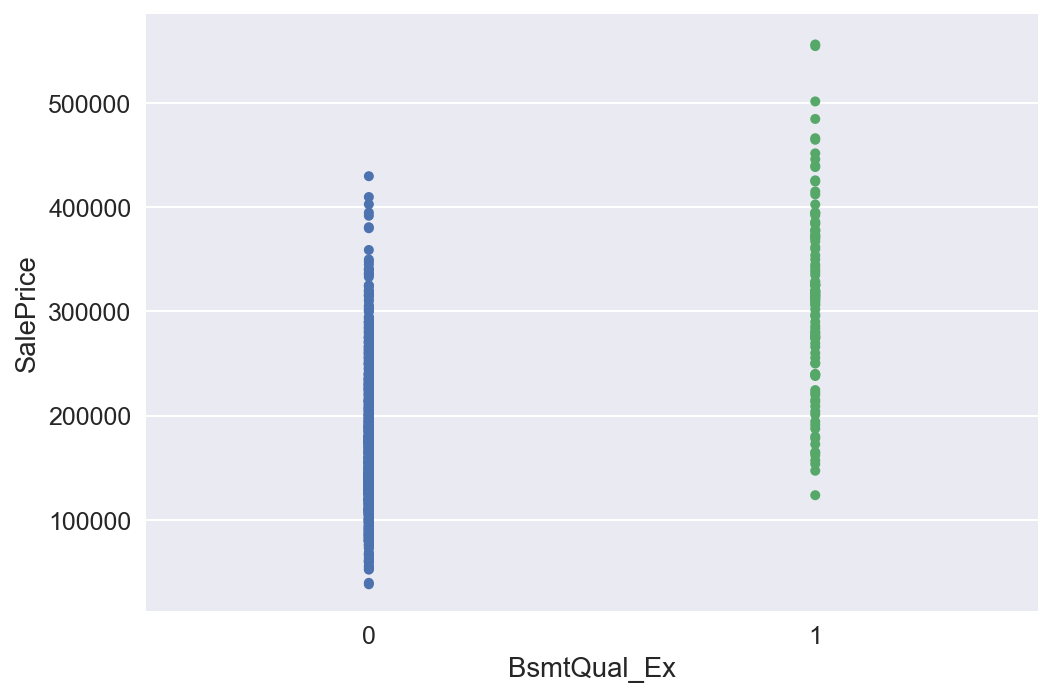

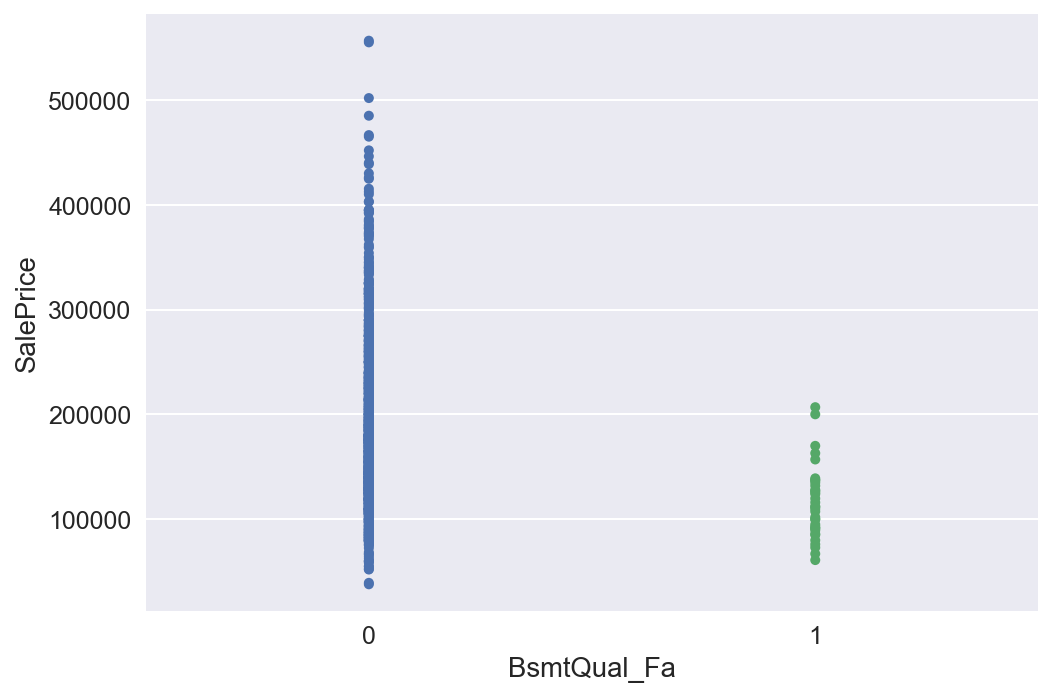

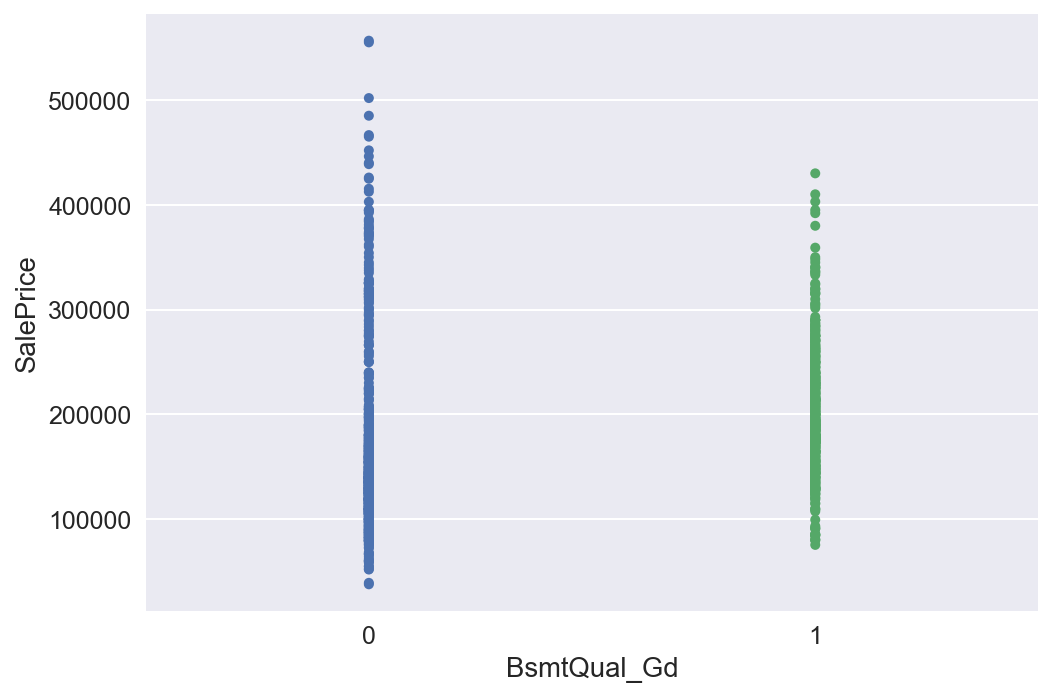

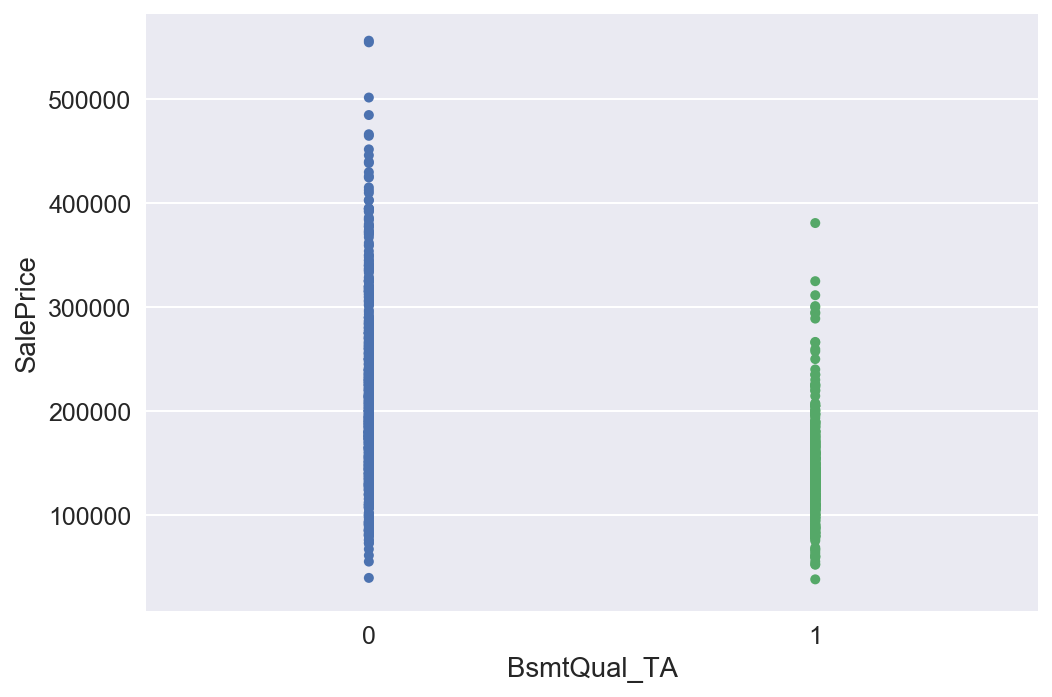

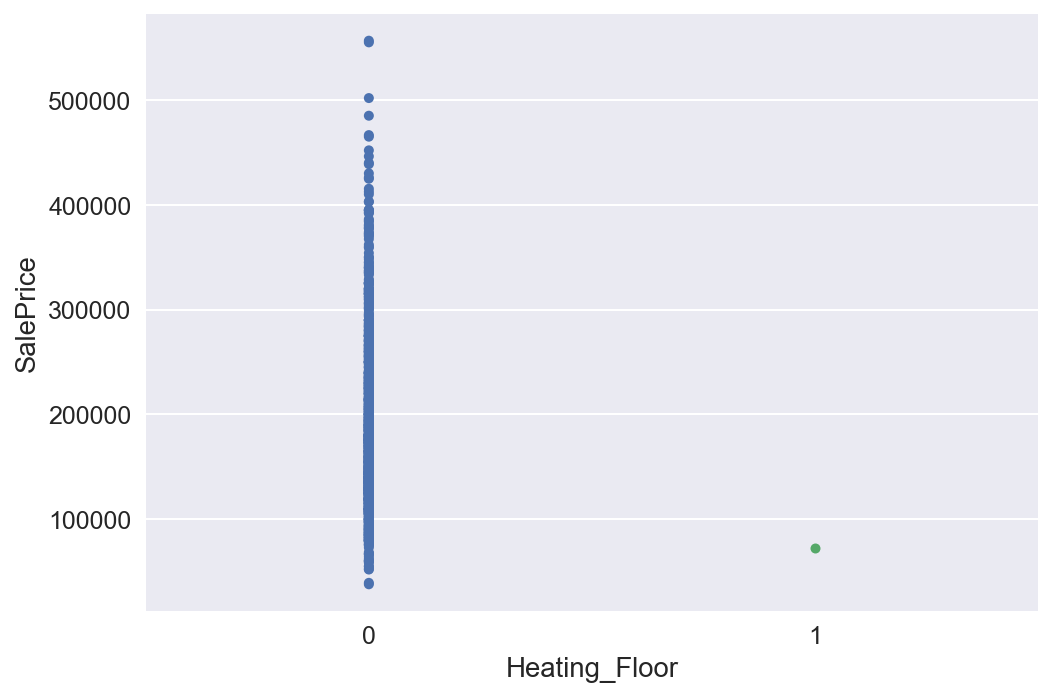

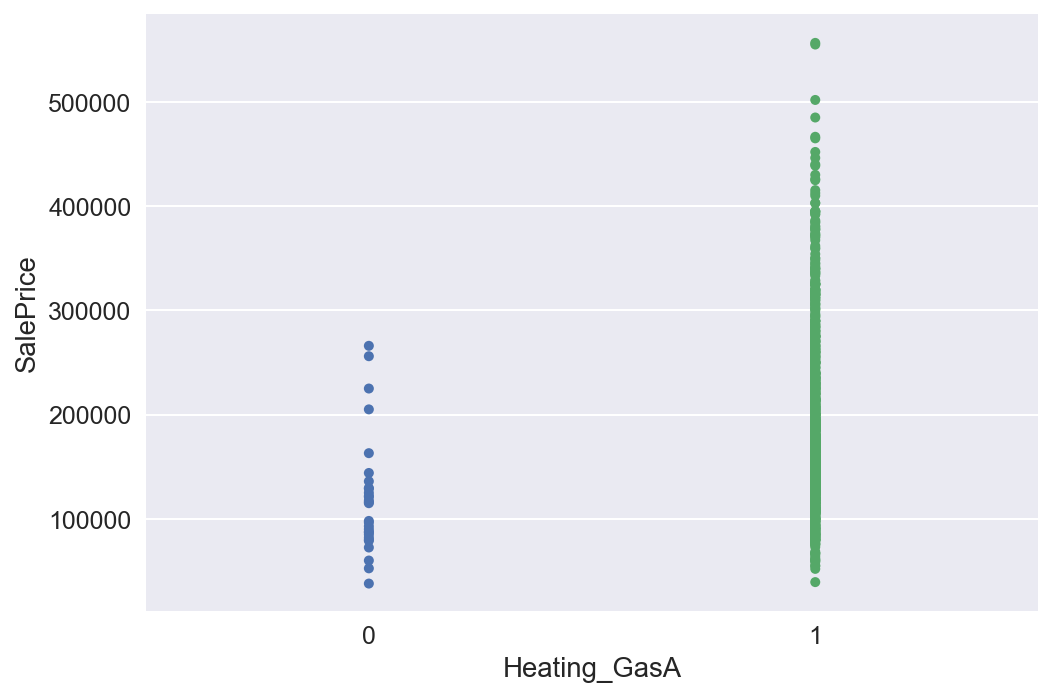

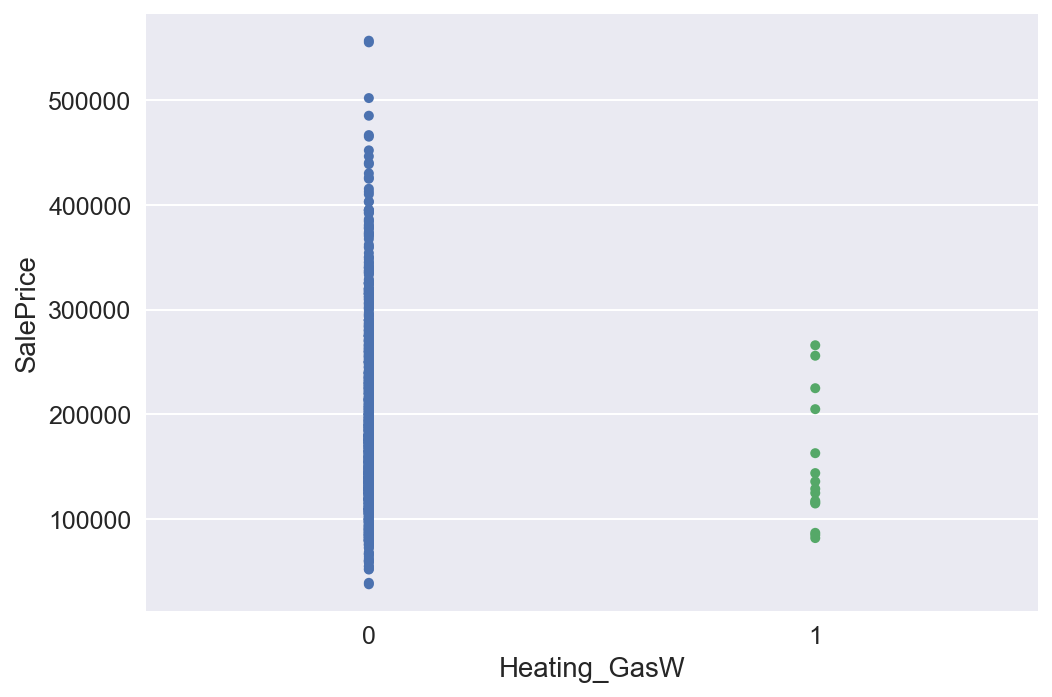

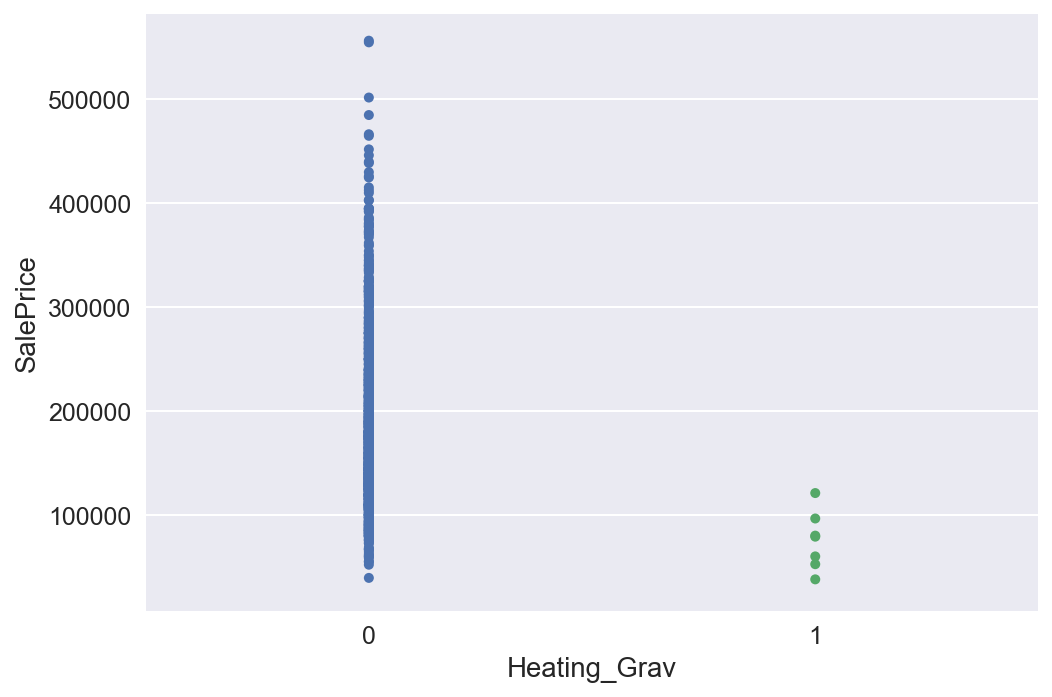

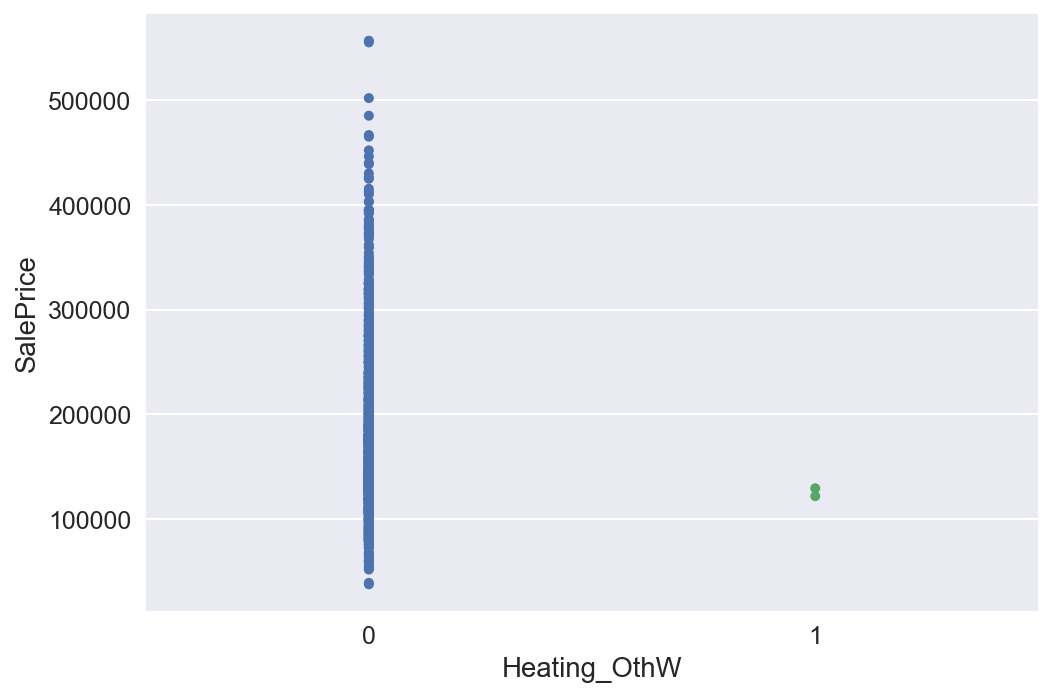

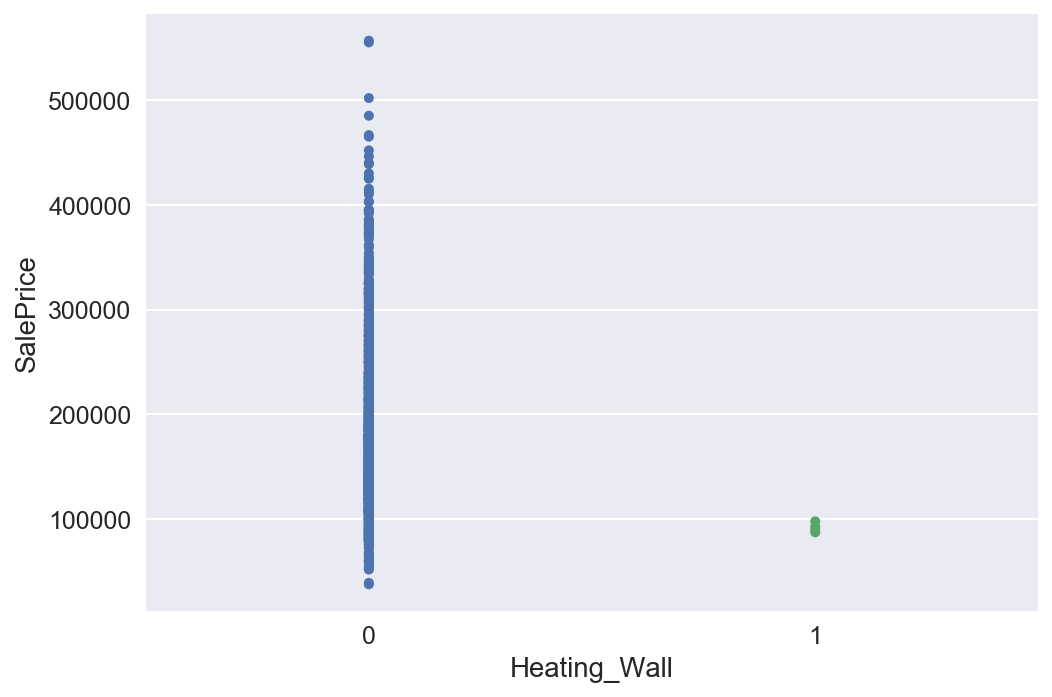

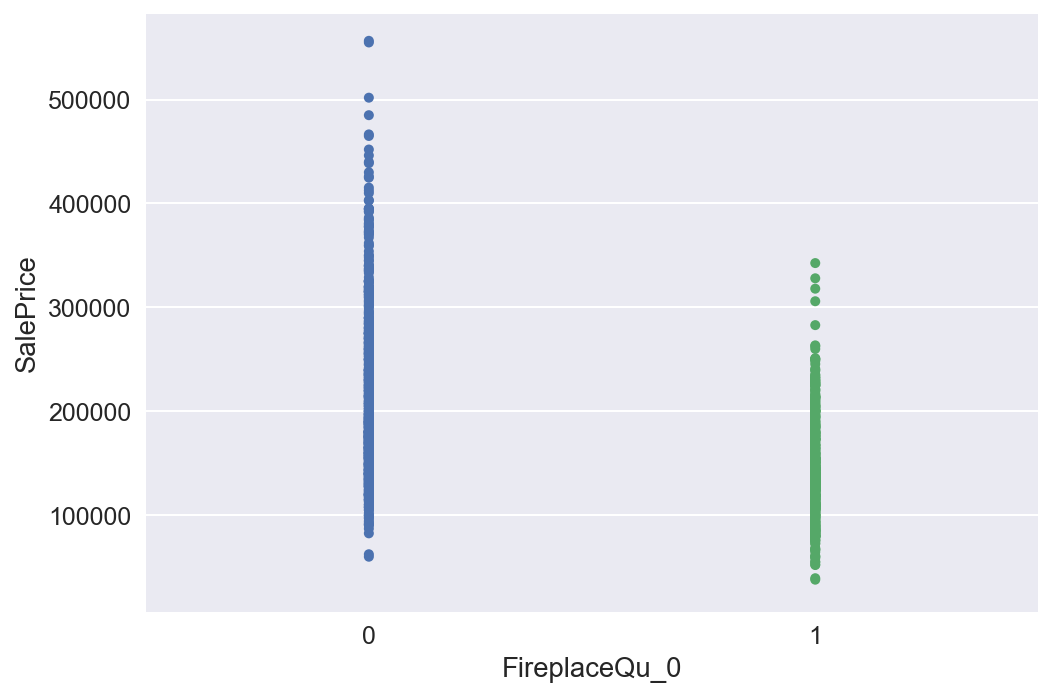

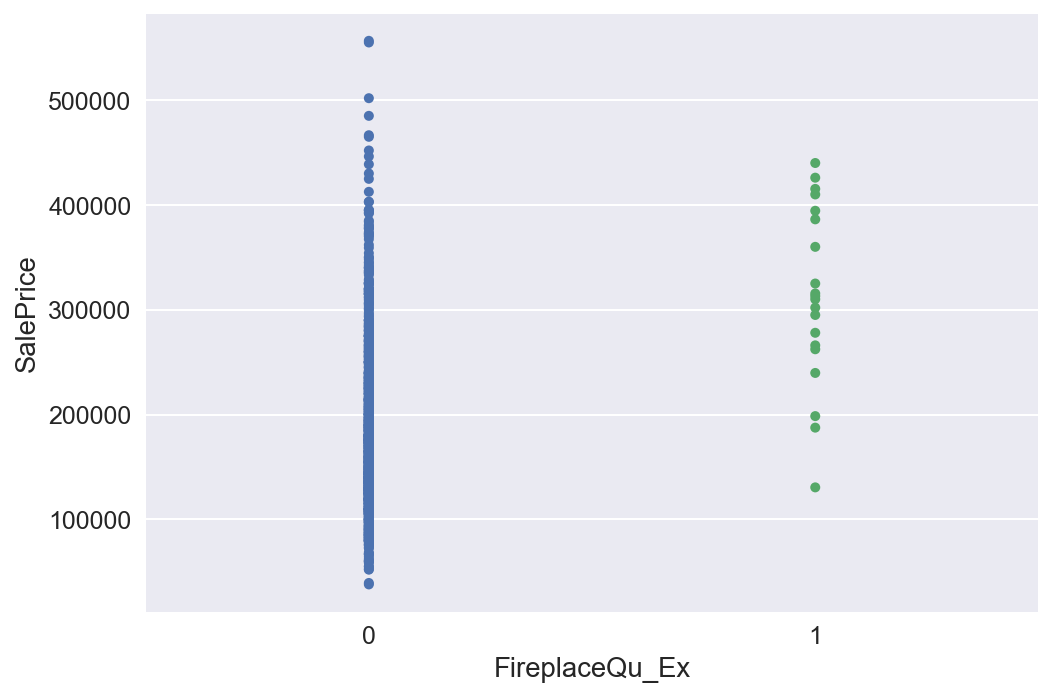

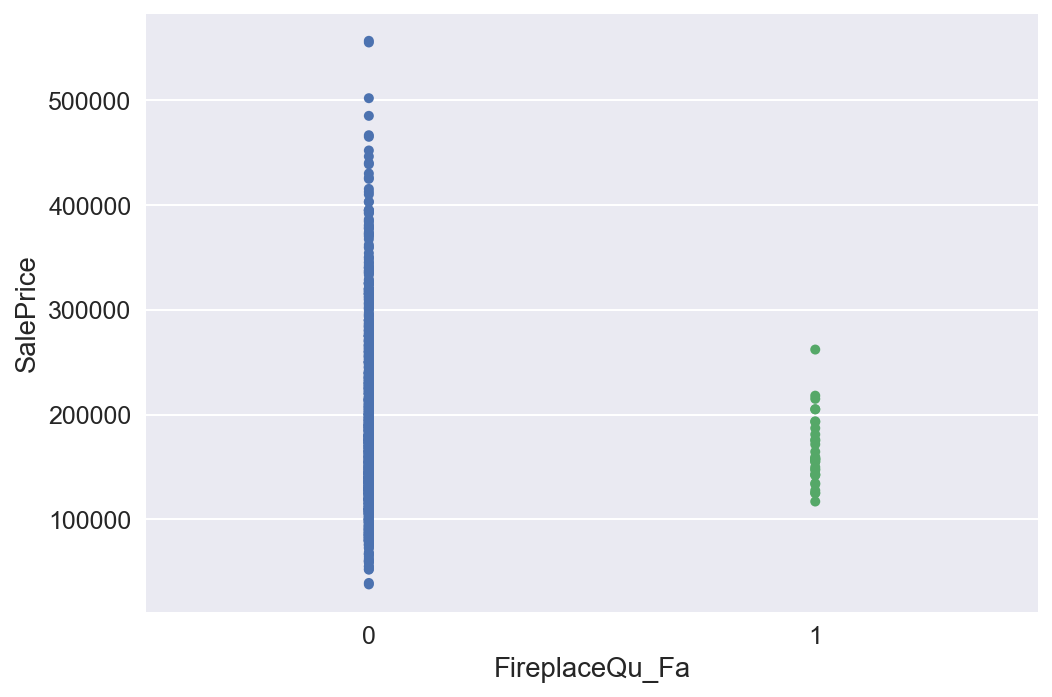

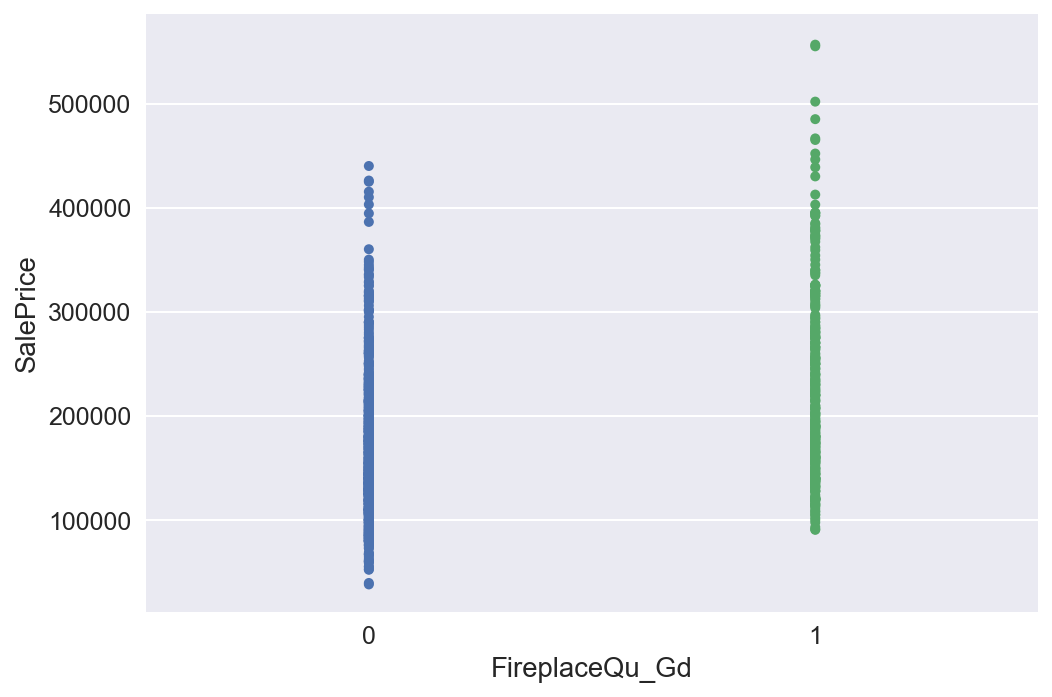

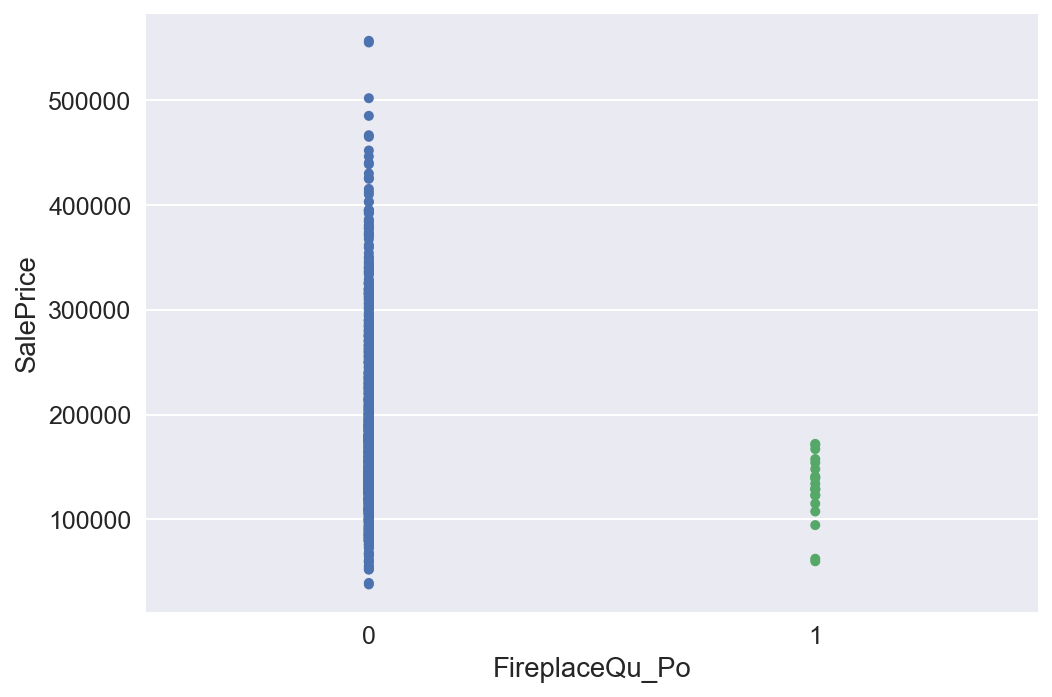

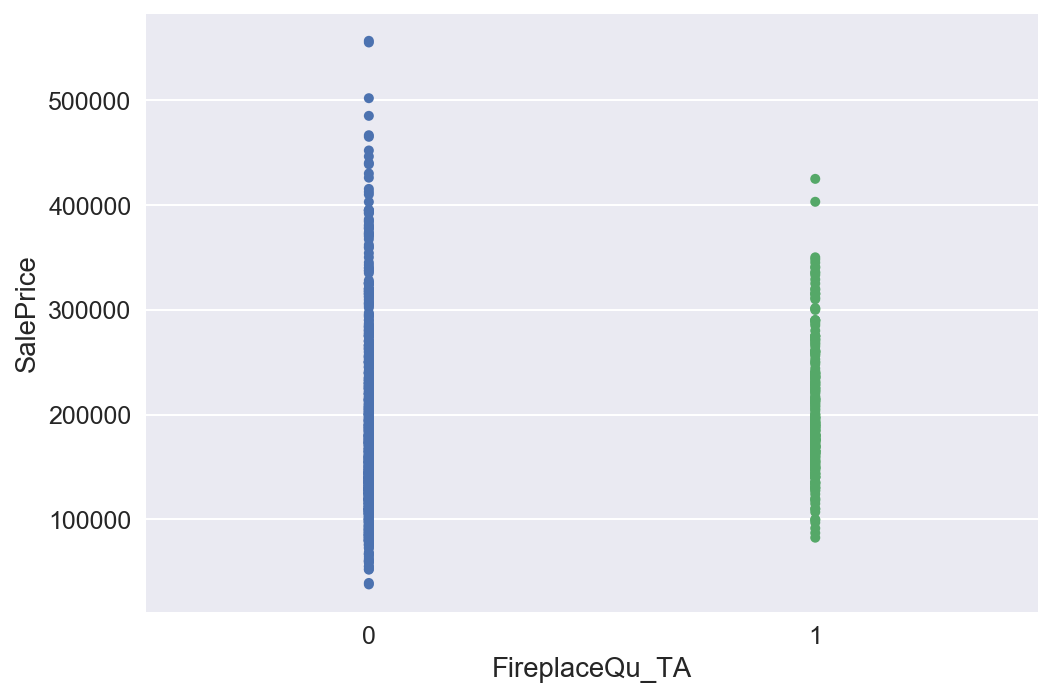

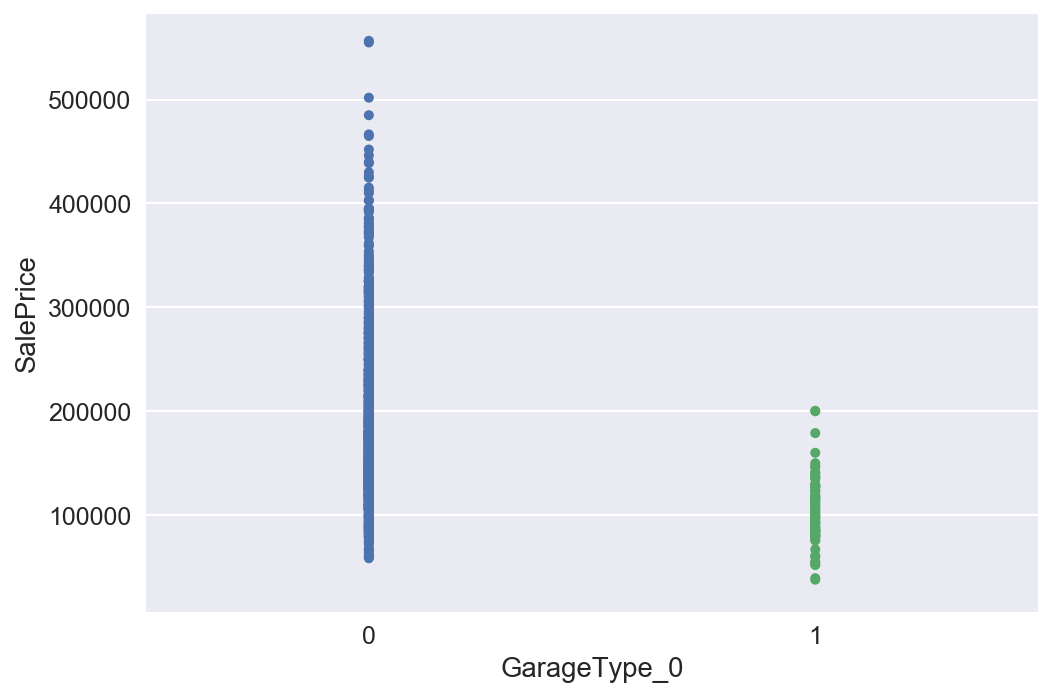

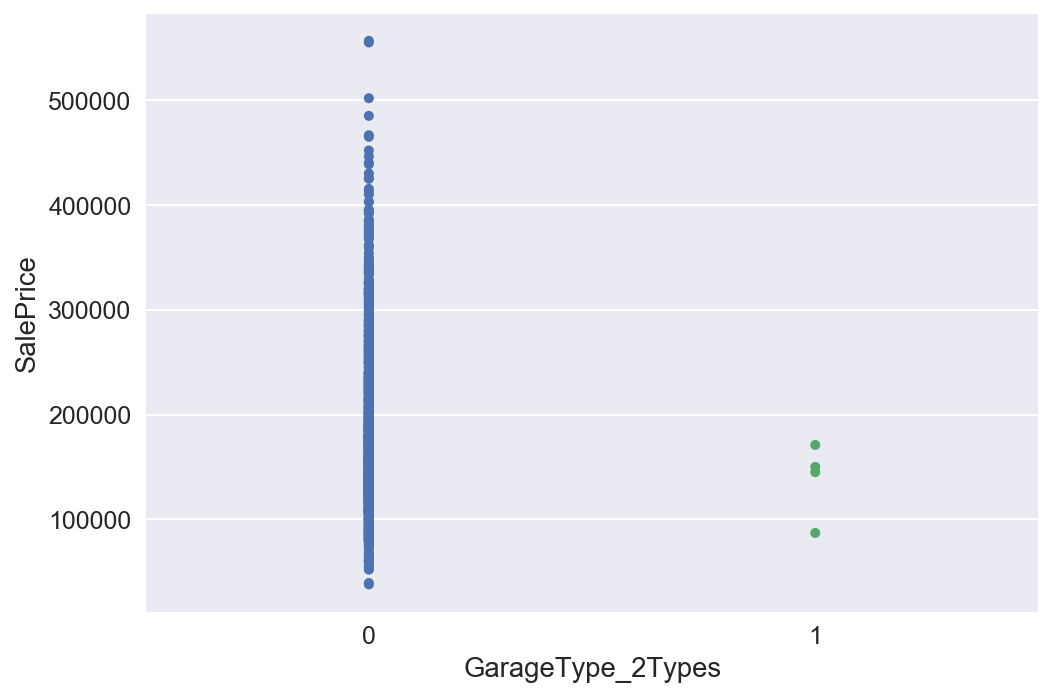

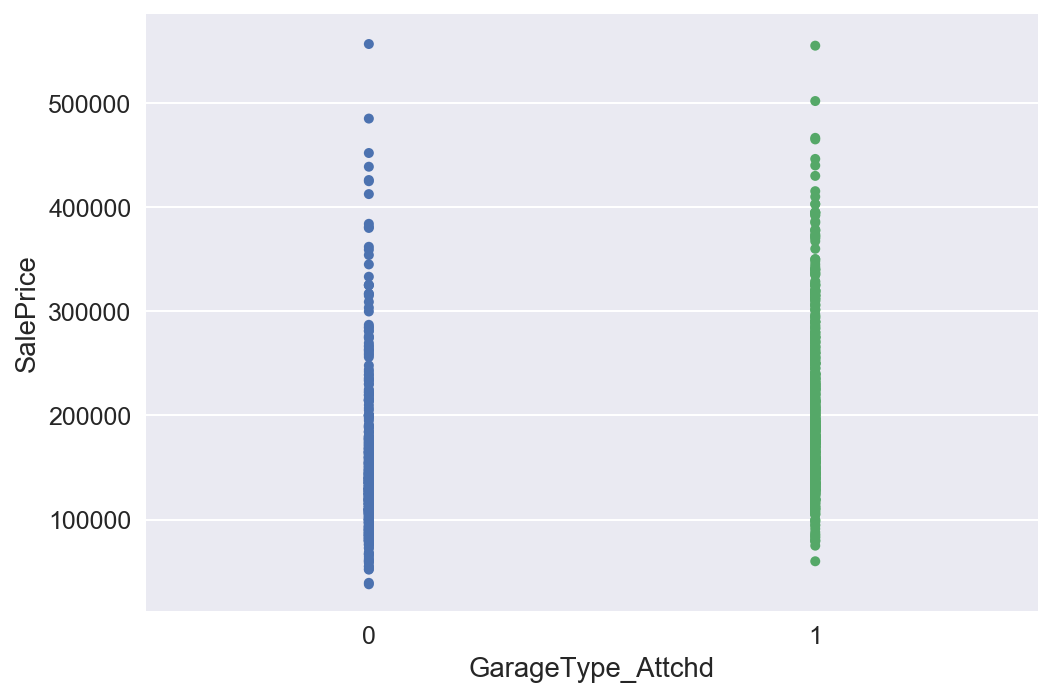

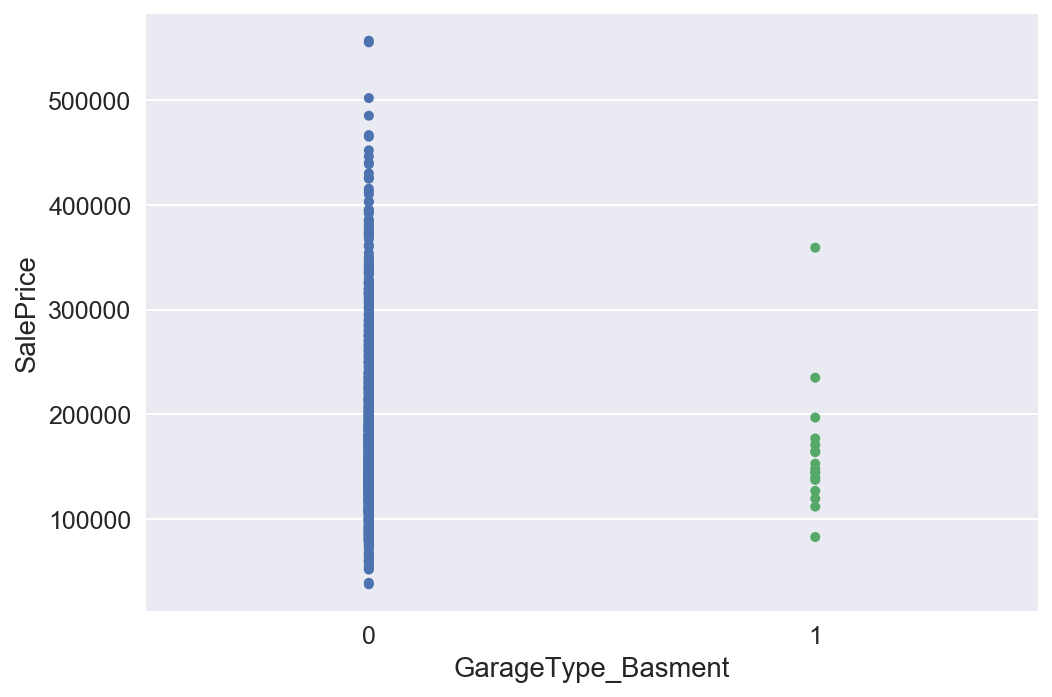

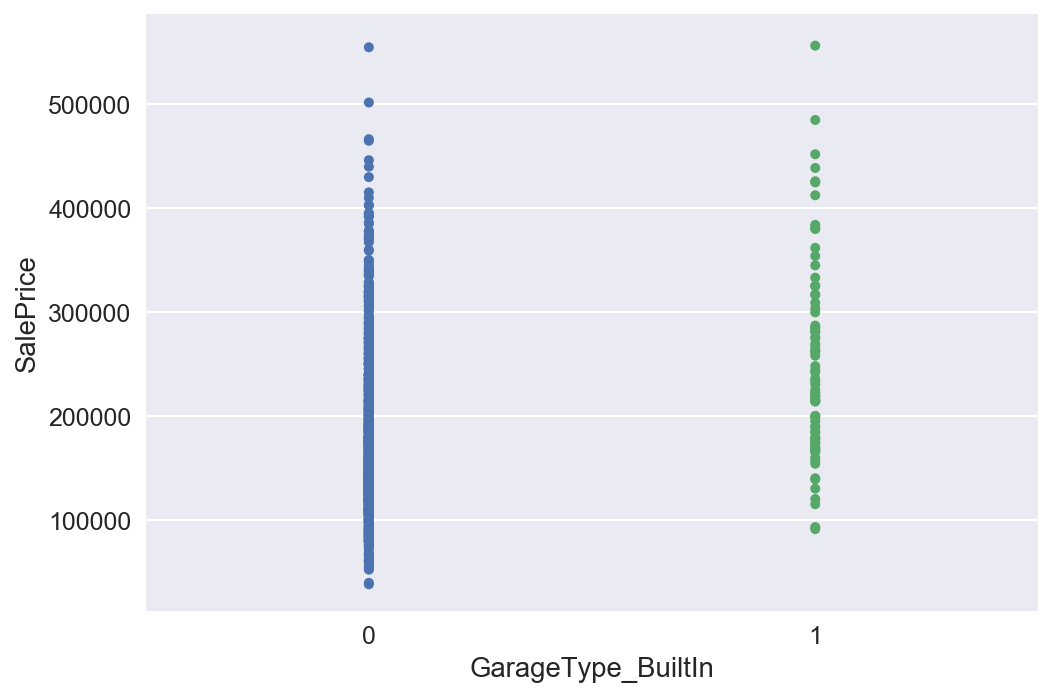

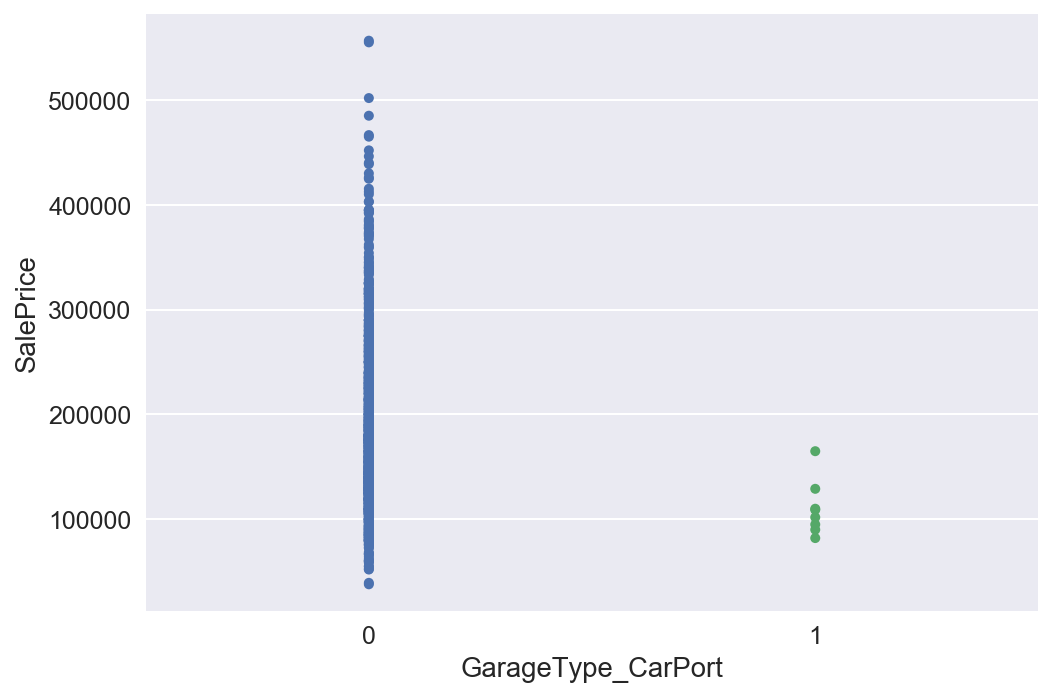

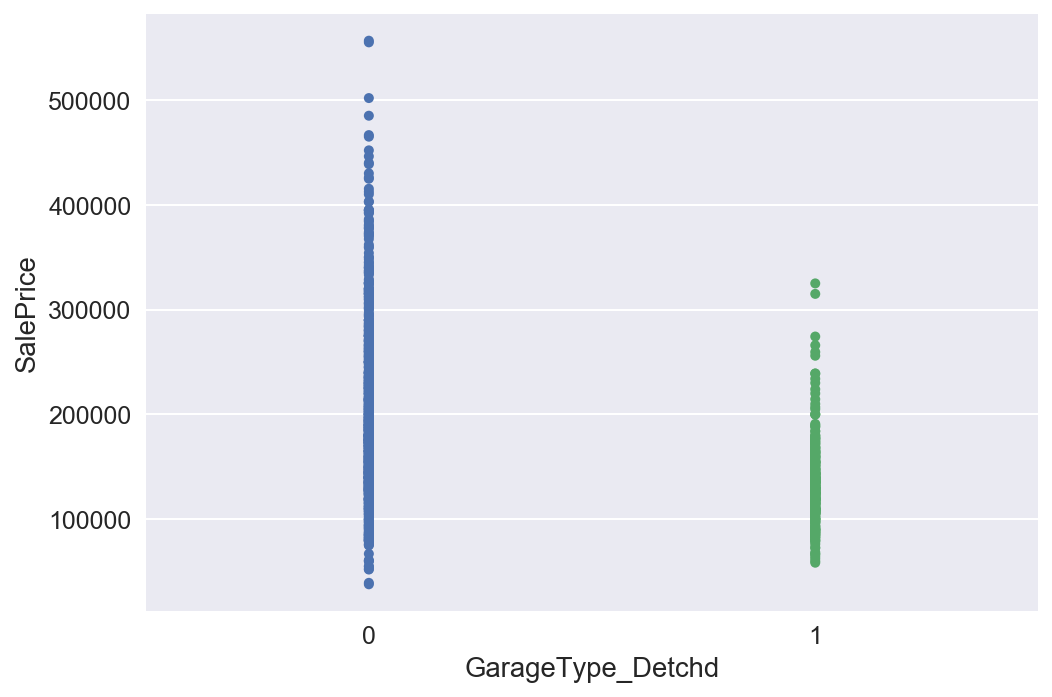

In [71]:
for i in house2.columns:
    sns.stripplot(i, 'SalePrice', data=house2)
    plt.show()


In [72]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 64)




### train_size = 0.7

In [73]:
y = house2.loc[:,'SalePrice']
x = house2.loc[:, house2.columns!='SalePrice']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=8)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 17)
(162, 64)


### Linear Reg. Score is terrible.

In [74]:
#Trying linear regression
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape

cls_scores = cross_val_score(LinearRegression(), x,y, cv=4)

print cls_scores
np.mean(cls_scores)


(162, 17)
(162, 64)
[ -1.37670061e+19   7.51788371e-01   7.46551471e-01  -1.63122168e+16]


-3.4458295758449239e+18

### Try Elastic net. Score after gridsearch: 0.73191011290635488

In [75]:
cls_scores = cross_val_score(ElasticNet(alpha=0.5, l1_ratio=0.001), x,y, cv=4)

print 'Here are my elastic net scores'
print cls_scores
cls_scores.dtype

from sklearn.model_selection import GridSearchCV

enet_params = {'alpha': [0.01,0.1,0.5,1], 'l1_ratio':[0.1,0.5]}
enet_gridsearch = GridSearchCV(ElasticNet(), enet_params, cv=2, verbose=1)
enet_gridsearch.fit(x, y)
print 'gridsearching: best score'
print enet_gridsearch.best_score_
print 'gridsearch best params'
print enet_gridsearch.best_params_
best_enet = enet_gridsearch.best_estimator_
best_enet.score(X_test, y_test)

Here are my elastic net scores
[ 0.72114688  0.6810809   0.70494833  0.69493043]
Fitting 2 folds for each of 8 candidates, totalling 16 fits
gridsearching: best score
0.762851827165
gridsearch best params
{'alpha': 0.01, 'l1_ratio': 0.5}


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


0.76237875754477402

### Make (yhat - y) my target variable. 

In [76]:
#We have 162 yhats. Predict our yhats ?
new_house2 = house2.loc[house2['YrSold'] == 2010]
print y_hat.shape
print new_house2.shape
new_house2.assign(resi = residuals) 

y = residuals
x = new_house2.loc[:, house2.columns!='residuals']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=8)

from xgboost import XGBRegressor
model = XGBRegressor(seed=42, learning_rate=0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)



(162L,)
(162, 64)


0.21225870683015546

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [77]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house1['YrSold'] == 2010].shape


(162, 17)
(162, 64)
